In [1]:
# Import libraries i will need
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from osgeo import gdal
import random as python_random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
import gc
import keras

#import the libraries necessary for confusion plot
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2 # imports the computer vision package
from tensorflow.keras.models import Model
from matplotlib import colors

In [9]:
# Load in images from wherever they are located 
inputPath="D:/final_data/2017_2"
filelist = []

# Load the images, and append them to a list.
for filepath in os.listdir(inputPath):
    if filepath.endswith((".tif")):
    #print(filepath)
        tempfile=inputPath+'/{0}'.format(filepath)
        filelist.append(tempfile)


In [2]:
# load in some loss dependencies
from keras import backend as K

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    sum_ = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def dice_metric(y_pred, y_true):
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    union = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    # if y_pred.sum() == 0 and y_pred.sum() == 0:
    #     return 1.0

    return 2*intersection / union

# define my own jaccard metric, should be same as IoU
def jaccard_coef(y_true, y_pred):
    y_true_f=K.flatten(y_true)
    y_pred_f=K.flatten(y_pred)
    intersection=K.sum(y_true_f + y_pred_f)
    return (intersection +1.0)/ (K.sum(y_true_f) + K.sum(y_pred_f) - intersection +1.0)
    
def jaccard_coef_loss(y_true, y_pred):
    return -jaccard_coef(y_true, y_pred)

In [3]:
# initialize the data generator used to create the data for the UNet model
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=25, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y1, Y2, Y3 = self.__data_generation(list_IDs_temp)
        y=[Y1,Y2,Y3]

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        images = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            dataset = gdal.Open(ID)
            image = dataset.ReadAsArray()  # Returned image is a NumPy array with shape (16, 60, 60) for example.
            images.append(image)  # Append the NumPy array to the list.

        all_data= np.stack(images, axis= 0)
        all_data[all_data < .0000001] = 0
        X=all_data[:,:14,:,:] # separate out the band values
        X = np.transpose(X, axes=[0, 2, 3, 1])
        # normalize values of the input data to 0,1
        X = X/X.max(axis=(3),keepdims=1)
        # For RGB uncomment this
        #X = X[:,:,:,:3]
        
        # canopy_height,tree/not tree,ndvi
        all_data= np.stack( images, axis= 0)
        Y = all_data[:,14:]
        Y[Y  < .0000001] = 0
        #Y[:,0][Y[:,0]  > 1] = 1
        Y1=Y[:,0] # 0 for height, 1 for tree/not, 2 for NDVI 
        Y1 = Y1/Y1.max()          
        Y2=Y[:,1]
        Y2[Y2  >0 ] = 1 
        all_data= np.stack( images, axis= 0)
        Y3 = all_data[:,14:]
        Y3[(Y3 < .0000001) & (Y3 >= 0) ] = 1
        Y3=Y3[:,2] # 0 for height, 1 for tree/not, 2 for NDVI 
        Y3[Y3  >0 ] = 0
        Y3[Y3  <0 ] = 1
        
        
        #Y[:,0][Y[:,0]  > 1] = 1
        #Y3=Y[:,2] # 0 for height, 1 for tree/not, 2 for NDVI 
        #Y3 = Y3/Y3.max()
        self.X=X
        self.Y1=Y1
        self.Y2=Y2
        self.Y3=Y3

        return X, Y1, Y2, Y3
    
    
    def get_true_values_x(self, indexes):
        'Generate one batch of data'
        # Return validation data for plotting 

        # Find list of IDs - (give input of validation indexes)
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y1, Y2, Y3 = self.__data_generation(list_IDs_temp)
        y=[Y1,Y2,Y3]
        
        # only need to return the RGB data for plotting
        X = X[:,:,:,0:3]

        return X
    
    def get_true_values_y(self, indexes):
        'Generate one batch of data'
        # Return validation data for plotting 

        # Find list of IDs - (give input of validation indexes)
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y1, Y2, Y3 = self.__data_generation(list_IDs_temp)
        y=[Y1,Y2,Y3]

        return y

In [10]:
# set up the data with the generators
params = {'batch_size':12,
         'shuffle': True}

# need a dictionary which has a list of training paths and a list of validations paths
filelist_temp = filelist # can  edits this to be a subset of the files
np.random.seed(14)
mask = np.random.rand(len(filelist_temp)) <=.75

training_data = np.array(filelist_temp)[mask]
val_data = np.array(filelist_temp)[~mask]


mydict = {}
mydict["training"] = training_data
mydict["validation"] = val_data

# generators
training_generator = DataGenerator(mydict["training"], **params)
val_generator = DataGenerator(mydict["validation"], **params)

In [4]:
# =====================================================
# define U-Net model architecture - All shared layers

def build_unet(img_shape):
    # input layer shape is equal to patch image size
    inputs = layers.Input(shape=img_shape)

    # rescale images from (0, 255) to (0, 1)
 #   rescale = Rescaling(scale=1. / 255, input_shape=(img_height, img_width, img_channels))(inputs)
 #   previous_block_activation = rescale  # Set aside residual
    previous_block_activation = inputs

    contraction = {}
    # # Contraction path: Blocks 1 through 5 are identical apart from the feature depth
    for f in [32, 64]:
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
        x = layers.Dropout(0.1)(x)
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        contraction[f'conv{f}'] = x
        x = layers.MaxPooling2D((2, 2))(x)
        previous_block_activation = x

    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
    x = layers.Dropout(0.1)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    contraction[f'conv{128}'] = x
    x = layers.MaxPooling2D((3, 3))(x)
    previous_block_activation = x
        
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
    c5 = layers.Dropout(0.2)(c5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    previous_block_activation = c5
    
    x = layers.Conv2DTranspose(128, (2, 2), strides=(3, 3), padding='same')(previous_block_activation)
    x = layers.concatenate([x, contraction[f'conv{128}']])
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    previous_block_activation = x
        
    # Expansive path: Second half of the network: upsampling inputs
    # could we use upsampling layers here instead of Conv2dTRanspose layers? might that help
    for f in reversed([32, 64]):
        x = layers.Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(previous_block_activation)
        x = layers.concatenate([x, contraction[f'conv{f}']])
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        previous_block_activation = x

    output_tree_height = layers.Conv2D(filters=1, kernel_size=(1, 1), activation="linear", name="tree_height")(previous_block_activation)

    output_tree_binary = layers.Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid", name="tree_binary")(previous_block_activation)
    
    output_vegetation_task = layers.Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid", name="vegetation_task")(previous_block_activation)


    return Model(inputs=inputs, outputs=[output_tree_height,output_tree_binary,output_vegetation_task])




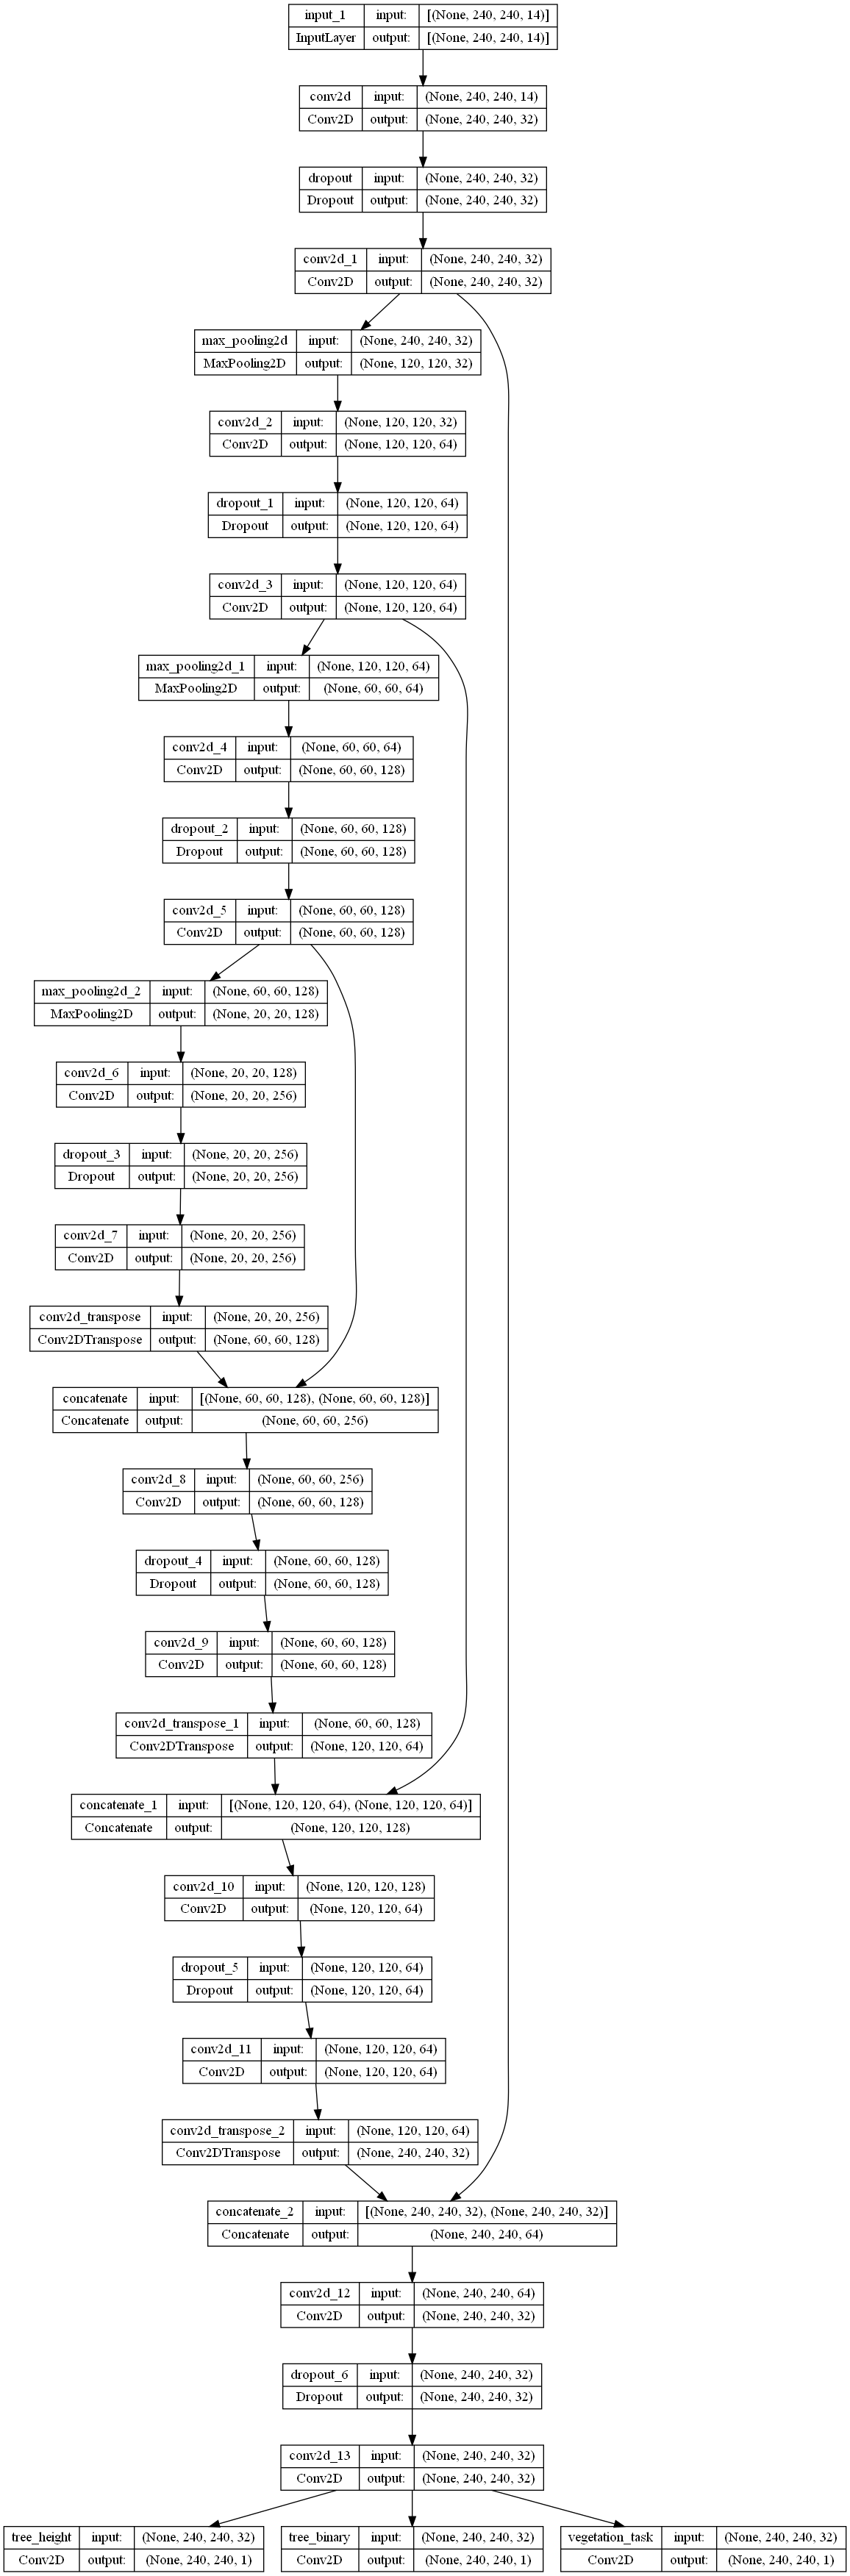

In [7]:
plot_model(model_multi_all_shared,"multi_task_model_all_shared_final.png" , show_shapes=True, show_layer_names=True)

In [5]:
# build model
model_multi_all_shared= build_unet(img_shape=(240, 240, 14))
model_multi_all_shared.summary()

model_multi_all_shared.compile(optimizer="adam", 
              loss={'tree_height': 'mse',
                    'tree_binary': jaccard_distance_loss,
                    'vegetation_task': jaccard_distance_loss,},
               loss_weights={'tree_binary': .5, 
                             'tree_height': .6,
                             'vegetation_task': .1,},
              metrics={'tree_height': ["mae", 'accuracy'],
                       'tree_binary': [tf.keras.metrics.BinaryCrossentropy(),tf.keras.metrics.MeanIoU(num_classes=2),dice_metric], 
                       'vegetation_task': [tf.keras.metrics.BinaryCrossentropy(),tf.keras.metrics.MeanIoU(num_classes=2),dice_metric]}
)
#print(model_multi_all_shared.metrics_names)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                4)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 240, 240, 32  4064        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 240, 240, 32  0           ['conv2d[0][0]']                 
                                )                                                             

                                )                                                                 
                                                                                                  
 tree_height (Conv2D)           (None, 240, 240, 1)  33          ['conv2d_13[0][0]']              
                                                                                                  
 tree_binary (Conv2D)           (None, 240, 240, 1)  33          ['conv2d_13[0][0]']              
                                                                                                  
 vegetation_task (Conv2D)       (None, 240, 240, 1)  33          ['conv2d_13[0][0]']              
                                                                                                  
Total params: 1,928,835
Trainable params: 1,928,835
Non-trainable params: 0
__________________________________________________________________________________________________


In [9]:
%%time

callback = tf.keras.callbacks.EarlyStopping(monitor="val_tree_binary_mean_io_u", patience=10, restore_best_weights=True,
                                           mode="max", verbose=1)

# Train our model
history=model_multi_all_shared.fit(
    training_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=callback
)

Epoch 1/100
597/597 [==============================] - 1075s 2s/step - loss: 41.3027 - tree_height_loss: 0.1021 - tree_binary_loss: 79.6189 - vegetation_task_loss: 14.3202 - tree_height_mae: 0.2031 - tree_height_accuracy: 0.0732 - tree_binary_binary_crossentropy: 0.9011 - tree_binary_mean_io_u: 0.5244 - tree_binary_dice_metric: 0.3330 - vegetation_task_binary_crossentropy: 0.6713 - vegetation_task_mean_io_u_1: 0.1687 - vegetation_task_dice_metric: 0.9207 - val_loss: 37.6090 - val_tree_height_loss: 0.0369 - val_tree_binary_loss: 73.8903 - val_vegetation_task_loss: 6.4172 - val_tree_height_mae: 0.1507 - val_tree_height_accuracy: 0.0767 - val_tree_binary_binary_crossentropy: 0.7689 - val_tree_binary_mean_io_u: 0.5444 - val_tree_binary_dice_metric: 0.4123 - val_vegetation_task_binary_crossentropy: 0.2344 - val_vegetation_task_mean_io_u_1: 0.3516 - val_vegetation_task_dice_metric: 0.9668
Epoch 2/100
597/597 [==============================] - 616s 1s/step - loss: 36.9805 - tree_height_loss: 

597/597 [==============================] - 732s 1s/step - loss: 33.4591 - tree_height_loss: 0.0149 - tree_binary_loss: 66.1468 - vegetation_task_loss: 3.7680 - tree_height_mae: 0.0861 - tree_height_accuracy: 0.0765 - tree_binary_binary_crossentropy: 0.8369 - tree_binary_mean_io_u: 0.6364 - tree_binary_dice_metric: 0.5039 - vegetation_task_binary_crossentropy: 0.3112 - vegetation_task_mean_io_u_1: 0.7717 - vegetation_task_dice_metric: 0.9808 - val_loss: 33.5056 - val_tree_height_loss: 0.0153 - val_tree_binary_loss: 66.3903 - val_vegetation_task_loss: 3.0128 - val_tree_height_mae: 0.0739 - val_tree_height_accuracy: 0.0768 - val_tree_binary_binary_crossentropy: 0.7776 - val_tree_binary_mean_io_u: 0.6341 - val_tree_binary_dice_metric: 0.5011 - val_vegetation_task_binary_crossentropy: 0.2429 - val_vegetation_task_mean_io_u_1: 0.8562 - val_vegetation_task_dice_metric: 0.9847
Epoch 20/100
597/597 [==============================] - 687s 1s/step - loss: 33.5065 - tree_height_loss: 0.0168 - tree

597/597 [==============================] - 748s 1s/step - loss: 32.6835 - tree_height_loss: 0.0150 - tree_binary_loss: 64.6692 - vegetation_task_loss: 3.3992 - tree_height_mae: 0.0864 - tree_height_accuracy: 0.0765 - tree_binary_binary_crossentropy: 0.8125 - tree_binary_mean_io_u: 0.6456 - tree_binary_dice_metric: 0.5199 - vegetation_task_binary_crossentropy: 0.3071 - vegetation_task_mean_io_u_1: 0.8514 - vegetation_task_dice_metric: 0.9827 - val_loss: 33.4520 - val_tree_height_loss: 0.0228 - val_tree_binary_loss: 66.2804 - val_vegetation_task_loss: 2.9801 - val_tree_height_mae: 0.1323 - val_tree_height_accuracy: 0.0768 - val_tree_binary_binary_crossentropy: 0.8717 - val_tree_binary_mean_io_u: 0.6382 - val_tree_binary_dice_metric: 0.5025 - val_vegetation_task_binary_crossentropy: 0.2901 - val_vegetation_task_mean_io_u_1: 0.9339 - val_vegetation_task_dice_metric: 0.9849
Epoch 38/100
597/597 [==============================] - 770s 1s/step - loss: 32.5136 - tree_height_loss: 0.0151 - tree

In [10]:
#model_multi_all_shared.save('save_location/multi_all_shared')

INFO:tensorflow:Assets written to: C:/Users/johnf/Documents/UCL/thesis/code/models/multi_all_shared\assets


INFO:tensorflow:Assets written to: C:/Users/johnf/Documents/UCL/thesis/code/models/multi_all_shared\assets


In [11]:
hist_df = pd.DataFrame(history.history)

In [12]:
hist_df
hist_df.to_csv('save_location/multi_all_shared_hist.csv')  

In [6]:
# repeat process for other types of multi-spectral models
params = {'batch_size':8,
         'shuffle': True}

# need a dictionary which has a list of training paths and a list of validations paths
filelist_temp = filelist
np.random.seed(14)
mask = np.random.rand(len(filelist_temp)) <=.75

training_data = np.array(filelist_temp)[mask]
val_data = np.array(filelist_temp)[~mask]


mydict = {}
mydict["training"] = training_data
mydict["validation"] = val_data

# generators
training_generator = DataGenerator(mydict["training"], **params)
val_generator = DataGenerator(mydict["validation"], **params)

In [7]:
# =====================================================
# define U-Net model architecture - proof_concept_2
def build_unet(img_shape):
    # input layer shape is equal to patch image size
    inputs = layers.Input(shape=img_shape)

    # rescale images from (0, 255) to (0, 1)
 #   rescale = Rescaling(scale=1. / 255, input_shape=(img_height, img_width, img_channels))(inputs)
 #   previous_block_activation = rescale  # Set aside residual
    previous_block_activation = inputs

    contraction = {}
    # # Contraction path: Blocks 1 through 5 are identical apart from the feature depth
    for f in [32, 64]:
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
        x = layers.Dropout(0.1)(x)
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        contraction[f'conv{f}'] = x
        x = layers.MaxPooling2D((2, 2))(x)
        previous_block_activation = x

    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
    x = layers.Dropout(0.1)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    contraction[f'conv{128}'] = x
    x = layers.MaxPooling2D((3, 3))(x)
    previous_block_activation = x
        
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
    c5 = layers.Dropout(0.2)(c5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    previous_block_activation0 = c5
    
    x = layers.Conv2DTranspose(128, (2, 2), strides=(3, 3), padding='same')(previous_block_activation0)
    x = layers.concatenate([x, contraction[f'conv{128}']])
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    previous_block_activation_1 = x
    
    x = layers.Conv2DTranspose(128, (2, 2), strides=(3, 3), padding='same')(previous_block_activation0)
    x = layers.concatenate([x, contraction[f'conv{128}']])
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    previous_block_activation_2 = x
    
    x = layers.Conv2DTranspose(128, (2, 2), strides=(3, 3), padding='same')(previous_block_activation0)
    x = layers.concatenate([x, contraction[f'conv{128}']])
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    previous_block_activation_3 = x  

    # Expansive path: Second half of the network: upsampling inputs
    # could we use upsampling layers here instead of Conv2dTRanspose layers? might that help
    for f in reversed([32, 64]):
        x = layers.Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(previous_block_activation_1)
        x = layers.concatenate([x, contraction[f'conv{f}']])
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        previous_block_activation_1 = x

            # Expansive path: Second half of the network: upsampling inputs
    # could we use upsampling layers here instead of Conv2dTRanspose layers? might that help
    for f in reversed([32, 64]):
        x = layers.Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(previous_block_activation_2)
        x = layers.concatenate([x, contraction[f'conv{f}']])
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        previous_block_activation_2 = x

            # Expansive path: Second half of the network: upsampling inputs
    # could we use upsampling layers here instead of Conv2dTRanspose layers? might that help
    for f in reversed([32, 64]):
        x = layers.Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(previous_block_activation_3)
        x = layers.concatenate([x, contraction[f'conv{f}']])
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        previous_block_activation_3 = x
        
    output_tree_height = layers.Conv2D(filters=1, kernel_size=(1, 1), activation="linear", name="tree_height")(previous_block_activation_1)
    output_tree_binary = layers.Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid", name="tree_binary")(previous_block_activation_2)    
    output_vegetation_task = layers.Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid", name="vegetation_task")(previous_block_activation_3)


    return Model(inputs=inputs, outputs=[output_tree_height,output_tree_binary,output_vegetation_task])




In [8]:
# build model
model_multi_partial_shared= build_unet(img_shape=(240, 240, 14))
model_multi_partial_shared.summary()
# plot_model(model_unet_multitask_noweights,"multi_task_model_fuller_attempt.png" , show_shapes=True, show_layer_names=True)
model_multi_partial_shared.compile(optimizer="adam", 
              loss={'tree_height': 'mse',
                    'tree_binary': jaccard_distance_loss,
                    'vegetation_task': jaccard_distance_loss,},
               loss_weights={'tree_binary': .6, 
                             'tree_height': .6,
                             'vegetation_task': .1,},
              metrics={'tree_height': ["mae", 'accuracy'],
                       'tree_binary': [tf.keras.metrics.BinaryCrossentropy(),tf.keras.metrics.MeanIoU(num_classes=2),dice_metric], 
                       'vegetation_task': [tf.keras.metrics.BinaryCrossentropy(),tf.keras.metrics.MeanIoU(num_classes=2),dice_metric]}
)
#print(model_multi_all_shared.metrics_names)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                4)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 240, 240, 32  4064        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 240, 240, 32  0           ['conv2d[0][0]']                 
                                )                                                             

 spose)                         )                                                                 
                                                                                                  
 conv2d_transpose_7 (Conv2DTran  (None, 120, 120, 64  32832      ['conv2d_13[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 120, 120, 12  0           ['conv2d_transpose_3[0][0]',     
                                8)                                'conv2d_3[0][0]']               
                                                                                                  
 concatenate_5 (Concatenate)    (None, 120, 120, 12  0           ['conv2d_transpose_5[0][0]',     
                                8)                                'conv2d_3[0][0]']               
          

 conv2d_25 (Conv2D)             (None, 240, 240, 32  9248        ['dropout_12[0][0]']             
                                )                                                                 
                                                                                                  
 tree_height (Conv2D)           (None, 240, 240, 1)  33          ['conv2d_17[0][0]']              
                                                                                                  
 tree_binary (Conv2D)           (None, 240, 240, 1)  33          ['conv2d_21[0][0]']              
                                                                                                  
 vegetation_task (Conv2D)       (None, 240, 240, 1)  33          ['conv2d_25[0][0]']              
                                                                                                  
Total params: 3,435,459
Trainable params: 3,435,459
Non-trainable params: 0
_________________________________

In [9]:
%%time

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)

# Train our model
history=model_multi_partial_shared.fit(
    training_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=callback
)

Epoch 1/100
896/896 [==============================] - 714s 788ms/step - loss: 48.7624 - tree_height_loss: 0.0191 - tree_binary_loss: 78.0780 - vegetation_task_loss: 19.0419 - tree_height_mae: 0.0985 - tree_height_accuracy: 0.0764 - tree_binary_binary_crossentropy: 1.1691 - tree_binary_mean_io_u: 0.5577 - tree_binary_dice_metric: 0.3534 - vegetation_task_binary_crossentropy: 2.6244 - vegetation_task_mean_io_u_1: 0.5374 - vegetation_task_dice_metric: 0.8916 - val_loss: 44.3072 - val_tree_height_loss: 0.0160 - val_tree_binary_loss: 72.7862 - val_vegetation_task_loss: 6.2590 - val_tree_height_mae: 0.0935 - val_tree_height_accuracy: 0.0768 - val_tree_binary_binary_crossentropy: 0.8864 - val_tree_binary_mean_io_u: 0.5928 - val_tree_binary_dice_metric: 0.4252 - val_vegetation_task_binary_crossentropy: 0.3636 - val_vegetation_task_mean_io_u_1: 0.7913 - val_vegetation_task_dice_metric: 0.9676
Epoch 2/100
896/896 [==============================] - 733s 818ms/step - loss: 43.6719 - tree_height_l

896/896 [==============================] - 772s 861ms/step - loss: 40.1733 - tree_height_loss: 0.0120 - tree_binary_loss: 66.3013 - vegetation_task_loss: 3.8530 - tree_height_mae: 0.0735 - tree_height_accuracy: 0.0765 - tree_binary_binary_crossentropy: 0.8958 - tree_binary_mean_io_u: 0.6353 - tree_binary_dice_metric: 0.5012 - vegetation_task_binary_crossentropy: 0.3659 - vegetation_task_mean_io_u_1: 0.9199 - vegetation_task_dice_metric: 0.9803 - val_loss: 39.8814 - val_tree_height_loss: 0.0116 - val_tree_binary_loss: 65.9273 - val_vegetation_task_loss: 3.1801 - val_tree_height_mae: 0.0716 - val_tree_height_accuracy: 0.0768 - val_tree_binary_binary_crossentropy: 0.8630 - val_tree_binary_mean_io_u: 0.6378 - val_tree_binary_dice_metric: 0.5056 - val_vegetation_task_binary_crossentropy: 0.2979 - val_vegetation_task_mean_io_u_1: 0.9392 - val_vegetation_task_dice_metric: 0.9838
Epoch 20/100
896/896 [==============================] - 769s 857ms/step - loss: 40.0903 - tree_height_loss: 0.0121 

In [10]:
model_multi_partial_shared.save('save_location/multi_partial_shared')

hist_df = pd.DataFrame(history.history)

hist_df
hist_df.to_csv('save_location/multi_partial_shared_hist.csv')  

INFO:tensorflow:Assets written to: C:/Users/johnf/Documents/UCL/thesis/code/models/multi_partial_shared\assets


INFO:tensorflow:Assets written to: C:/Users/johnf/Documents/UCL/thesis/code/models/multi_partial_shared\assets


# need to do three separate models with all of the data to compare against...

###### tree yes/no #######

In [11]:

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=25, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        images = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            dataset = gdal.Open(ID)
            image = dataset.ReadAsArray()  # Returned image is a NumPy array with shape (16, 60, 60) for example.
            images.append(image)  # Append the NumPy array to the list.

        all_data= np.stack(images, axis= 0)
        all_data[all_data < .0000001] = 0
        X=all_data[:,:14,:,:] # separate out the band values
        X = np.transpose(X, axes=[0, 2, 3, 1])
        # normalize values of the input data to 0,1
        X = X/X.max(axis=(3),keepdims=1)
        # For RGB uncomment this
        #X = X[:,:,:,:3]
        
        # canopy_height,tree/not tree,ndvi
        all_data= np.stack( images, axis= 0)
        Y = all_data[:,14:]
        Y[Y  < .0000001] = 0
        Y[:,1][Y[:,1]  > 1] = 1
        Y=Y[:,1]
        self.X=X
        self.Y=Y

        return X, Y
    
    def get_true_values_x(self, indexes):
        'Generate one batch of data'
        # Return validation data for plotting 

        # Find list of IDs - (give input of validation indexes)
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        
        # only need to return the RGB data for plotting
        X = X[:,:,:,0:3]

        return X
    
    def get_true_values_y(self, indexes):
        'Generate one batch of data'
        # Return validation data for plotting 

        # Find list of IDs - (give input of validation indexes)
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return y

In [12]:
params = {'batch_size':20,
         'shuffle': True}

# need a dictionary which has a list of training paths and a list of validations paths
filelist_temp = filelist
np.random.seed(14)
mask = np.random.rand(len(filelist_temp)) <=.75

training_data = np.array(filelist_temp)[mask]
val_data = np.array(filelist_temp)[~mask]


mydict = {}
mydict["training"] = training_data
mydict["validation"] = val_data

# generators
training_generator = DataGenerator(mydict["training"], **params)
val_generator = DataGenerator(mydict["validation"], **params)

In [13]:
# =====================================================
# define U-Net model architecture - proof_concept_2

def build_unet(img_shape):
    # input layer shape is equal to patch image size
    inputs = layers.Input(shape=img_shape)

    # rescale images from (0, 255) to (0, 1)
 #   rescale = Rescaling(scale=1. / 255, input_shape=(img_height, img_width, img_channels))(inputs)
 #   previous_block_activation = rescale  # Set aside residual
    previous_block_activation = inputs

    contraction = {}
    # # Contraction path: Blocks 1 through 5 are identical apart from the feature depth
    for f in [32, 64]:
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
        x = layers.Dropout(0.1)(x)
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        contraction[f'conv{f}'] = x
        x = layers.MaxPooling2D((2, 2))(x)
        previous_block_activation = x

    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
    x = layers.Dropout(0.1)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    contraction[f'conv{128}'] = x
    x = layers.MaxPooling2D((3, 3))(x)
    previous_block_activation = x
        
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
    c5 = layers.Dropout(0.2)(c5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    previous_block_activation = c5
    
    x = layers.Conv2DTranspose(128, (2, 2), strides=(3, 3), padding='same')(previous_block_activation)
    x = layers.concatenate([x, contraction[f'conv{128}']])
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    previous_block_activation = x
        
    # Expansive path: Second half of the network: upsampling inputs
    # could we use upsampling layers here instead of Conv2dTRanspose layers? might that help
    for f in reversed([32, 64]):
        x = layers.Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(previous_block_activation)
        x = layers.concatenate([x, contraction[f'conv{f}']])
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        previous_block_activation = x

    outputs = layers.Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(previous_block_activation)

    return Model(inputs=inputs, outputs=outputs)




In [14]:
%%time
# build model
model_unet_tree_footprint_all = build_unet(img_shape=(240, 240, 14))
model_unet_tree_footprint_all.summary()

# compile model
model_unet_tree_footprint_all.compile(optimizer="adam",
              loss="binary_crossentropy", 
              metrics=[tf.keras.metrics.BinaryCrossentropy(),'accuracy',tf.keras.metrics.MeanIoU(num_classes=2)])

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train our model
history=model_unet_tree_footprint_all.fit(
    training_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=callback
)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                4)]                                                               
                                                                                                  
 conv2d_26 (Conv2D)             (None, 240, 240, 25  3175        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_13 (Dropout)           (None, 240, 240, 25  0           ['conv2d_26[0][0]']              
                                )                                                           

                                )                                                                 
                                                                                                  
 conv2d_40 (Conv2D)             (None, 240, 240, 1)  26          ['conv2d_39[0][0]']              
                                                                                                  
Total params: 778,001
Trainable params: 778,001
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/100
358/358 [==============================] - 811s 2s/step - loss: 0.1415 - binary_crossentropy: 0.1415 - accuracy: 0.9518 - mean_io_u_2: 0.4759 - val_loss: 0.1243 - val_binary_crossentropy: 0.1243 - val_accuracy: 0.9518 - val_mean_io_u_2: 0.4759
Epoch 2/100
358/358 [==============================] - 811s 2s/step - loss: 0.1209 - binary_crossentropy: 0.1209 - accuracy: 0.9518 - mean_io_u_2: 0.4759 - val_loss: 0.1161 - va

In [15]:
model_unet_tree_footprint_all.save('save_location/tree_model')

hist_df = pd.DataFrame(history.history)

hist_df
hist_df.to_csv('save_location/tree_binary_hist.csv')  

INFO:tensorflow:Assets written to: C:/Users/johnf/Documents/UCL/thesis/code/models/tree_model\assets


INFO:tensorflow:Assets written to: C:/Users/johnf/Documents/UCL/thesis/code/models/tree_model\assets


## Canopy Height

In [54]:

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=25, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        images = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            dataset = gdal.Open(ID)
            image = dataset.ReadAsArray()  # Returned image is a NumPy array with shape (16, 60, 60) for example.
            images.append(image)  # Append the NumPy array to the list.

        all_data= np.stack(images, axis= 0)
        all_data[all_data < .0000001] = 0
        X=all_data[:,:14,:,:] # separate out the band values
        X = np.transpose(X, axes=[0, 2, 3, 1])
        # normalize values of the input data to 0,1
        X = X/X.max(axis=(3),keepdims=1)
        # For RGB uncomment this
        #X = X[:,:,:,:3]
        
        # canopy_height,tree/not tree,ndvi
        all_data= np.stack( images, axis= 0)
        Y = all_data[:,14:]
        Y[Y  < .0000001] = 0
        #Y[:,0][Y[:,0]  > 1] = 1
        Y=Y[:,0]
        Y = Y/Y.max()
        self.X=X
        self.Y=Y

        return X, Y
    
    def get_true_values_x(self, indexes):
        'Generate one batch of data'
        # Return validation data for plotting 

        # Find list of IDs - (give input of validation indexes)
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        images = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            dataset = gdal.Open(ID)
            image = dataset.ReadAsArray()  # Returned image is a NumPy array with shape (16, 60, 60) for example.
            images.append(image)  # Append the NumPy array to the list.

        all_data= np.stack(images, axis= 0)
        all_data[all_data < .0000001] = 0
        X=all_data[:,:14,:,:] # separate out the band values
        X = np.transpose(X, axes=[0, 2, 3, 1])
        
        # only need to return the RGB data for plotting
        X = X[:,:,:,0:3]

        return X
    
    def get_true_values_y(self, indexes):
        'Generate one batch of data'
        # Return validation data for plotting 

        # Find list of IDs - (give input of validation indexes)
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y1 = self.__data_generation(list_IDs_temp)
        y=[Y1]

        return y

In [23]:
params = {'batch_size':15,
         'shuffle': True}

# need a dictionary which has a list of training paths and a list of validations paths
filelist_temp = filelist
np.random.seed(14)
mask = np.random.rand(len(filelist_temp)) <=.75

training_data = np.array(filelist_temp)[mask]
val_data = np.array(filelist_temp)[~mask]


mydict = {}
mydict["training"] = training_data
mydict["validation"] = val_data

# generators
training_generator = DataGenerator(mydict["training"], **params)
val_generator = DataGenerator(mydict["validation"], **params)

In [16]:
# =====================================================
# define U-Net model architecture - proof_concept_2

def build_unet(img_shape):
    # input layer shape is equal to patch image size
    inputs = layers.Input(shape=img_shape)

    # rescale images from (0, 255) to (0, 1)
 #   rescale = Rescaling(scale=1. / 255, input_shape=(img_height, img_width, img_channels))(inputs)
 #   previous_block_activation = rescale  # Set aside residual
    previous_block_activation = inputs

    contraction = {}
    # # Contraction path: Blocks 1 through 5 are identical apart from the feature depth
    for f in [32, 64]:
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
        x = layers.Dropout(0.1)(x)
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        contraction[f'conv{f}'] = x
        x = layers.MaxPooling2D((2, 2))(x)
        previous_block_activation = x

    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
    x = layers.Dropout(0.1)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    contraction[f'conv{128}'] = x
    x = layers.MaxPooling2D((3, 3))(x)
    previous_block_activation = x
        
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
    c5 = layers.Dropout(0.2)(c5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    previous_block_activation = c5
    
    x = layers.Conv2DTranspose(128, (2, 2), strides=(3, 3), padding='same')(previous_block_activation)
    x = layers.concatenate([x, contraction[f'conv{128}']])
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    previous_block_activation = x
        
    # Expansive path: Second half of the network: upsampling inputs
    # could we use upsampling layers here instead of Conv2dTRanspose layers? might that help
    for f in reversed([32, 64]):
        x = layers.Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(previous_block_activation)
        x = layers.concatenate([x, contraction[f'conv{f}']])
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        previous_block_activation = x

    outputs = layers.Conv2D(filters=1, kernel_size=(1, 1), activation="linear")(previous_block_activation)

    return Model(inputs=inputs, outputs=outputs)


# build model
model_unet_canopy_ht_all = build_unet(img_shape=(240, 240, 14))
model_unet_canopy_ht_all.summary()

# compile model
model_unet_canopy_ht_all.compile(optimizer="adam",
              loss="mse", 
              metrics=["mae", 'accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                4)]                                                               
                                                                                                  
 conv2d_30 (Conv2D)             (None, 240, 240, 32  4064        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_14 (Dropout)           (None, 240, 240, 32  0           ['conv2d_30[0][0]']              
                                )                                                           

                                )                                                                 
                                                                                                  
 conv2d_44 (Conv2D)             (None, 240, 240, 1)  33          ['conv2d_43[0][0]']              
                                                                                                  
Total params: 1,928,769
Trainable params: 1,928,769
Non-trainable params: 0
__________________________________________________________________________________________________


In [17]:
%%time

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train our model
history=model_unet_canopy_ht_all.fit(
    training_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=callback
)

Epoch 1/100
478/478 [==============================] - 924s 2s/step - loss: 0.0160 - mae: 0.0850 - accuracy: 0.0763 - val_loss: 0.0112 - val_mae: 0.0763 - val_accuracy: 0.0768
Epoch 2/100
478/478 [==============================] - 907s 2s/step - loss: 0.0124 - mae: 0.0800 - accuracy: 0.0765 - val_loss: 0.0125 - val_mae: 0.0888 - val_accuracy: 0.0768
Epoch 3/100
478/478 [==============================] - 917s 2s/step - loss: 0.0118 - mae: 0.0775 - accuracy: 0.0765 - val_loss: 0.0111 - val_mae: 0.0702 - val_accuracy: 0.0768
Epoch 4/100
478/478 [==============================] - 894s 2s/step - loss: 0.0113 - mae: 0.0752 - accuracy: 0.0765 - val_loss: 0.0114 - val_mae: 0.0716 - val_accuracy: 0.0768
Epoch 5/100
478/478 [==============================] - 886s 2s/step - loss: 0.0111 - mae: 0.0734 - accuracy: 0.0765 - val_loss: 0.0107 - val_mae: 0.0723 - val_accuracy: 0.0768
Epoch 6/100
478/478 [==============================] - 894s 2s/step - loss: 0.0107 - mae: 0.0722 - accuracy: 0.0765 - va

In [18]:
model_unet_canopy_ht_all.save('C:/Users/johnf/Documents/UCL/thesis/code/models/height_model')

hist_df = pd.DataFrame(history.history)

hist_df
hist_df.to_csv('C:/Users/johnf/Documents/UCL/thesis/code/models/tree_height_hist.csv')  

INFO:tensorflow:Assets written to: C:/Users/johnf/Documents/UCL/thesis/code/models/height_model\assets


INFO:tensorflow:Assets written to: C:/Users/johnf/Documents/UCL/thesis/code/models/height_model\assets


# vegetation mask ###

In [8]:

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=25, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        images = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            dataset = gdal.Open(ID)
            image = dataset.ReadAsArray()  # Returned image is a NumPy array with shape (16, 60, 60) for example.
            images.append(image)  # Append the NumPy array to the list.

        all_data= np.stack(images, axis= 0)
        all_data[all_data < .0000001] = 0
        X=all_data[:,:14,:,:] # separate out the band values
        X = np.transpose(X, axes=[0, 2, 3, 1])
        # normalize values of the input data to 0,1
        X = X/X.max(axis=(3),keepdims=1)
        # For RGB uncomment this
        #X = X[:,:,:,:3]
        
        # canopy_height,tree/not tree,ndvi
        all_data= np.stack( images, axis= 0)
        Y = all_data[:,14:]
        Y[(Y < .0000001) & (Y >= 0) ] = 1
        #Y[:,0][Y[:,0]  > 1] = 1
        Y=Y[:,2] # 0 for height, 1 for tree/not, 2 for NDVI 
        Y[Y  >0 ] = 0
        Y[Y  <0 ] = 1
        #Y = Y/Y.max()
        self.X=X
        self.Y=Y

        return X, Y
    
    def get_true_values_x(self, indexes):
        'Generate one batch of data'
        # Return validation data for plotting 

        # Find list of IDs - (give input of validation indexes)
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        
        # only need to return the RGB data for plotting
        X = X[:,:,:,0:3]

        return X
    
    def get_true_values_y(self, indexes):
        'Generate one batch of data'
        # Return validation data for plotting 

        # Find list of IDs - (give input of validation indexes)
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return y

In [8]:
params = {'batch_size':15,
         'shuffle': True}

# need a dictionary which has a list of training paths and a list of validations paths
filelist_temp = filelist
np.random.seed(14)
mask = np.random.rand(len(filelist_temp)) <=.75

training_data = np.array(filelist_temp)[mask]
val_data = np.array(filelist_temp)[~mask]


mydict = {}
mydict["training"] = training_data
mydict["validation"] = val_data

# generators
training_generator = DataGenerator(mydict["training"], **params)
val_generator = DataGenerator(mydict["validation"], **params)

NameError: name 'filelist' is not defined

In [10]:
# =====================================================
# define U-Net model architecture - proof_concept_2

def build_unet(img_shape):
    # input layer shape is equal to patch image size
    inputs = layers.Input(shape=img_shape)

    # rescale images from (0, 255) to (0, 1)
 #   rescale = Rescaling(scale=1. / 255, input_shape=(img_height, img_width, img_channels))(inputs)
 #   previous_block_activation = rescale  # Set aside residual
    previous_block_activation = inputs

    contraction = {}
    # # Contraction path: Blocks 1 through 5 are identical apart from the feature depth
    for f in [32, 64]:
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
        x = layers.Dropout(0.1)(x)
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        contraction[f'conv{f}'] = x
        x = layers.MaxPooling2D((2, 2))(x)
        previous_block_activation = x

    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
    x = layers.Dropout(0.1)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    contraction[f'conv{128}'] = x
    x = layers.MaxPooling2D((3, 3))(x)
    previous_block_activation = x
        
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
    c5 = layers.Dropout(0.2)(c5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    previous_block_activation = c5
    
    x = layers.Conv2DTranspose(128, (2, 2), strides=(3, 3), padding='same')(previous_block_activation)
    x = layers.concatenate([x, contraction[f'conv{128}']])
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    previous_block_activation = x
        
    # Expansive path: Second half of the network: upsampling inputs
    # could we use upsampling layers here instead of Conv2dTRanspose layers? might that help
    for f in reversed([32, 64]):
        x = layers.Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(previous_block_activation)
        x = layers.concatenate([x, contraction[f'conv{f}']])
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        previous_block_activation = x

    outputs = layers.Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(previous_block_activation)

    return Model(inputs=inputs, outputs=outputs)

In [11]:
%%time

# build model
model_unet_ndvi_ht_all = build_unet(img_shape=(240, 240, 14))
model_unet_ndvi_ht_all.summary()

# compile model


# model_unet_ndvi_ht_all.compile(optimizer="adam",
#               loss="mse", 
#               metrics=["mae", 'accuracy'])
model_unet_ndvi_ht_all.compile(optimizer="adam",
              loss="binary_crossentropy", 
              metrics=[tf.keras.metrics.BinaryCrossentropy(),'accuracy',tf.keras.metrics.MeanIoU(num_classes=2)])



callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train our model
history=model_unet_ndvi_ht_all.fit(
    training_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=callback
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                4)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 240, 240, 32  4064        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 240, 240, 32  0           ['conv2d[0][0]']                 
                                )                                                             

                                )                                                                 
                                                                                                  
 conv2d_14 (Conv2D)             (None, 240, 240, 1)  33          ['conv2d_13[0][0]']              
                                                                                                  
Total params: 1,928,769
Trainable params: 1,928,769
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/100
478/478 [==============================] - 1448s 3s/step - loss: 0.1882 - binary_crossentropy: 0.1882 - accuracy: 0.9176 - mean_io_u: 0.1251 - val_loss: 0.0901 - val_binary_crossentropy: 0.0901 - val_accuracy: 0.9612 - val_mean_io_u: 0.1277
Epoch 2/100
478/478 [==============================] - 887s 2s/step - loss: 0.0750 - binary_crossentropy: 0.0750 - accuracy: 0.9683 - mean_io_u: 0.1401 - val_loss: 0.0633 - val

Epoch 31/100
478/478 [==============================] - 965s 2s/step - loss: 0.0219 - binary_crossentropy: 0.0219 - accuracy: 0.9907 - mean_io_u: 0.6412 - val_loss: 0.0140 - val_binary_crossentropy: 0.0140 - val_accuracy: 0.9943 - val_mean_io_u: 0.6851
Epoch 32/100
478/478 [==============================] - 964s 2s/step - loss: 0.0217 - binary_crossentropy: 0.0217 - accuracy: 0.9909 - mean_io_u: 0.6230 - val_loss: 0.0139 - val_binary_crossentropy: 0.0139 - val_accuracy: 0.9943 - val_mean_io_u: 0.6620
Epoch 33/100
478/478 [==============================] - 952s 2s/step - loss: 0.0265 - binary_crossentropy: 0.0265 - accuracy: 0.9888 - mean_io_u: 0.6012 - val_loss: 0.0233 - val_binary_crossentropy: 0.0233 - val_accuracy: 0.9902 - val_mean_io_u: 0.6213
Epoch 34/100
478/478 [==============================] - 980s 2s/step - loss: 0.0267 - binary_crossentropy: 0.0267 - accuracy: 0.9887 - mean_io_u: 0.6245 - val_loss: 0.0382 - val_binary_crossentropy: 0.0382 - val_accuracy: 0.9827 - val_mean_i

In [12]:
model_unet_ndvi_ht_all.save('save_location/vegetation_model')

hist_df = pd.DataFrame(history.history)

hist_df
hist_df.to_csv('save_location/vegetation_hist.csv')  

INFO:tensorflow:Assets written to: C:/Users/johnf/Documents/UCL/thesis/code/models/vegetation_model\assets


INFO:tensorflow:Assets written to: C:/Users/johnf/Documents/UCL/thesis/code/models/vegetation_model\assets


# do some testing to see what the best breakpoint value for tree/not is
# also need to create some images and other tables to show how well the models performed

In [4]:
class DataGenerator2(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=25, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y1, Y2, Y3 = self.__data_generation(list_IDs_temp)
        y=[Y1,Y2,Y3]

        return X, y 

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        images = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            dataset = gdal.Open(ID)
            image = dataset.ReadAsArray()  # Returned image is a NumPy array with shape (16, 60, 60) for example.
            images.append(image)  # Append the NumPy array to the list.

        all_data= np.stack(images, axis= 0)
        all_data[all_data < .0000001] = 0
        X=all_data[:,:14,:,:] # separate out the band values
        X = np.transpose(X, axes=[0, 2, 3, 1])
        # normalize values of the input data to 0,1
        X = X/X.max(axis=(3),keepdims=1)
        # For RGB uncomment this
        #X = X[:,:,:,:3]
        
        # canopy_height,tree/not tree,ndvi
        all_data= np.stack( images, axis= 0)
        Y = all_data[:,14:]
        Y[Y  < .0000001] = 0
        #Y[:,0][Y[:,0]  > 1] = 1
        Y1=Y[:,0] # 0 for height, 1 for tree/not, 2 for NDVI 
        Y1 = Y1/Y1.max()          
        Y2=Y[:,1]
        Y2[Y2  >0 ] = 1 
        all_data= np.stack( images, axis= 0)
        Y3 = all_data[:,14:]
        Y3[(Y3 < .0000001) & (Y3 >= 0) ] = 1
        Y3=Y3[:,2] # 0 for height, 1 for tree/not, 2 for NDVI 
        Y3[Y3  >0 ] = 0
        Y3[Y3  <0 ] = 1
        
        
        #Y[:,0][Y[:,0]  > 1] = 1
        #Y3=Y[:,2] # 0 for height, 1 for tree/not, 2 for NDVI 
        #Y3 = Y3/Y3.max()
        self.X=X
        self.Y1=Y1
        self.Y2=Y2
        self.Y3=Y3

        return X, Y1, Y2, Y3
    
    
    def get_true_values_x(self, indexes):
        'Generate one batch of data'
        # Return validation data for plotting 

        # Find list of IDs - (give input of validation indexes)
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        images = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            dataset = gdal.Open(ID)
            image = dataset.ReadAsArray()  # Returned image is a NumPy array with shape (16, 60, 60) for example.
            images.append(image)  # Append the NumPy array to the list.

        all_data= np.stack(images, axis= 0)
        all_data[all_data < .0000001] = 0
        X=all_data[:,:14,:,:] # separate out the band values
        X = np.transpose(X, axes=[0, 2, 3, 1])
        
        # only need to return the RGB data for plotting
        X = X[:,:,:,0:3]

        return X
    
    def get_true_values_y(self, indexes):
        'Generate one batch of data'
        # Return validation data for plotting 

        # Find list of IDs - (give input of validation indexes)
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y1, Y2, Y3 = self.__data_generation(list_IDs_temp)
        y=[Y1,Y2,Y3]

        return y

In [5]:
# final models: all shared for tree, height_model for height 
# 


model_final = keras.models.load_model('save_location/multi_all_shared',
                                     custom_objects={'dice_metric':dice_metric,
                                                    "jaccard_distance_loss":jaccard_distance_loss})

In [6]:
#model_final.summary()

In [12]:
mydict["validation"][1:2]

array(['D:/final_data/2017_2/P_1_X0_1_X1_240_Y0_1_Y1_240_100.tif'],
      dtype='<U61')

In [13]:
# look at how well it did
params = {'batch_size':10,
         'shuffle': False}

val_generator = DataGenerator2(mydict["validation"][:400], **params)

predictions = model_final.predict(val_generator)
#display(test_data, predictions)

# code to extra the true y values
y_test = val_generator.get_true_values_y(val_generator.indexes)
# code to extra the true y values
x_test = val_generator.get_true_values_x(val_generator.indexes)

predictions = np.asarray(predictions)
print(predictions.shape)
# print(y_test.shape)
# print(x_test.shape)
# print(predictions[1,:].min())
# print(predictions[1,:].max())

print(predictions[0,:].shape)
print(predictions[0,:].min())
print(predictions[0,:].max())
print(predictions[1,:].shape)
print(predictions[1,:].min())
print(predictions[1,:].max())
print(predictions[2,:].shape)
print(predictions[2,:].min())
print(predictions[2,:].max())
print(x_test.shape)

40/40 [==============================] - 60s 1s/step
(3, 400, 240, 240, 1)
(400, 240, 240, 1)
-1.2343509
0.8514774
(400, 240, 240, 1)
0.0
1.0
(400, 240, 240, 1)
0.0
1.0
(400, 240, 240, 3)


In [14]:
# function to display images
def display2(array1, array2, array3):
    """
    Displays 5 random images from each one of the supplied arrays.
    """

    n = 5

    indices = np.random.choice(len(array1), size=n, replace=False)
    images1 = array1[indices]
    images2 = array2[indices,:,:,0:3]/255
    images3 = array3[indices]

        
    plt.figure(figsize=(12, 12))
    for i, (image1, image2, image3) in enumerate(zip(images1, images2, images3)):
        ax = plt.subplot(5, n, i + 1)
        plt.imshow(image1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(5, n, i + 1 + n)
        plt.imshow(image2)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(5, n, i + 1 + n + n)
        plt.imshow(image3)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [83]:
# plt.imshow(x_test[4]/255)
# #x_test[4]/255

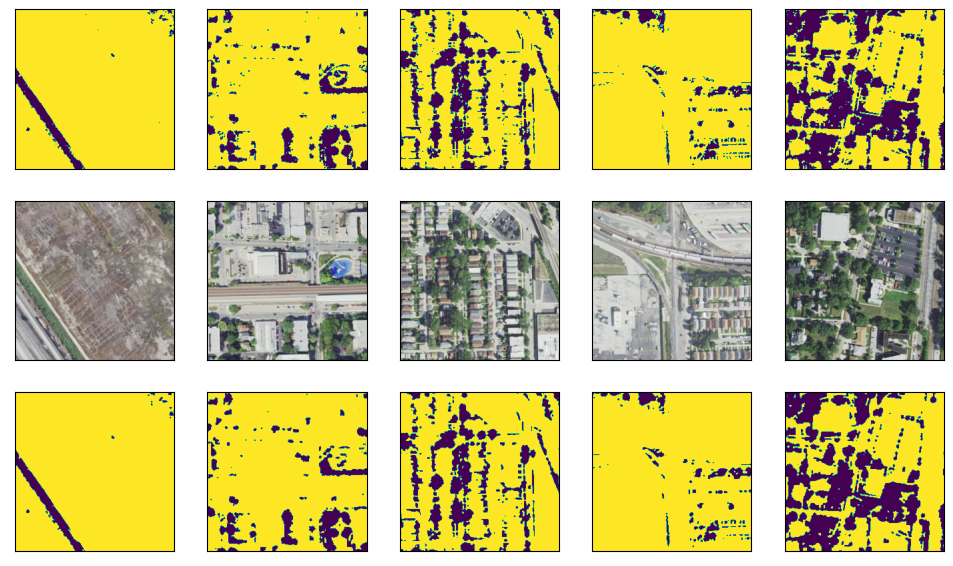

In [25]:
y_test_tree = y_test[1]
predictions_tree = predictions[1,:].copy()
#predictions_tree[predictions_tree  >= .9] = 1
#predictions_tree[predictions_tree  < .9 ] = 0
display2(y_test_tree, x_test, predictions_tree)

In [ ]:
# need to do a similar thing for height

In [55]:
# look at how well it did
params = {'batch_size':10,
         'shuffle': False}

val_generator = DataGenerator(mydict["validation"][:400], **params)

predictions = model_tree_height.predict(val_generator)
#display(test_data, predictions)

# code to extra the true y values
y_test = val_generator.get_true_values_y(val_generator.indexes)
# code to extra the true y values
x_test = val_generator.get_true_values_x(val_generator.indexes)

predictions = np.asarray(predictions)
print(predictions.shape)
# print(y_test.shape)
# print(x_test.shape)
# print(predictions[1,:].min())
# print(predictions[1,:].max())

# print(predictions[0,:].shape)
# print(predictions[0,:].min())
# print(predictions[0,:].max())
# print(predictions[1,:].shape)
# print(predictions[1,:].min())
# print(predictions[1,:].max())
# print(predictions[2,:].shape)
# print(predictions[2,:].min())
# print(predictions[2,:].max())
# print(x_test.shape)

40/40 [==============================] - 29s 721ms/step
(400, 240, 240, 1)


In [84]:
def display2(array1, array2, array3):
    """
    Displays 5 random images from each one of the supplied arrays.
    """

    n = 5

    indices = np.random.choice(len(array1), size=n, replace=False)
    images1 = array1[indices]
    images2 = array2[indices,:,:,0:3]/255
    images3 = array3[indices]

        
    plt.figure(figsize=(12, 12))
    for i, (image1, image2, image3) in enumerate(zip(images1, images2, images3)):
        ax = plt.subplot(5, n, i + 1)
        plt.imshow(image1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(5, n, i + 1 + n)
        plt.imshow(image2)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(5, n, i + 1 + n + n)
        plt.imshow(image3)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

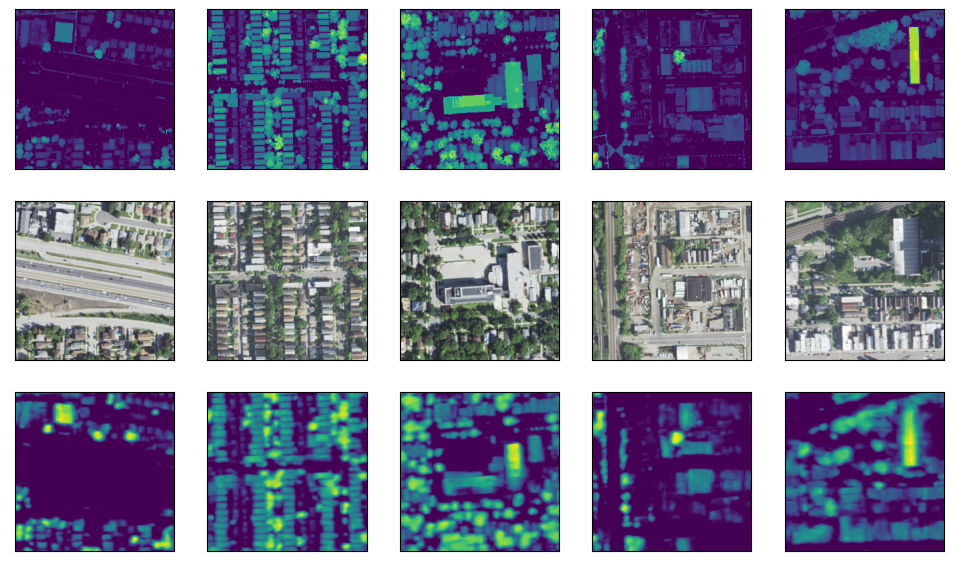

In [148]:
y_test_tree = y_test[0]
predictions_tree = predictions.copy()
#predictions_tree[predictions_tree  >= .9] = 1
#predictions_tree[predictions_tree  < .9 ] = 0
display2(y_test_tree, x_test, predictions_tree)

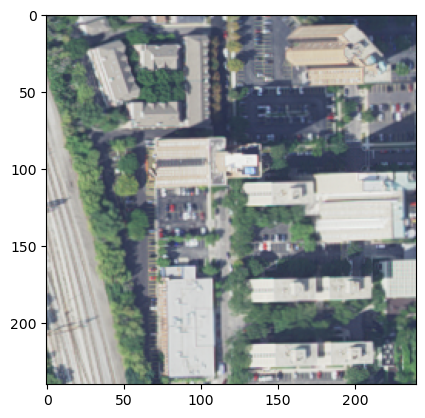

In [88]:
plt.imshow(x_test[2,:,:,:3]/255)

In [95]:
# test to see what cutpoint makes the most sense
iou_mean_list = []
k=np.arange(0.09,1.09,0.1)

for i in k:
    predictions_temp = predictions[1,:].copy()
    y_test3 = y_test[1]
    predictions_temp[predictions_temp  >= i] = 1
    predictions_temp[predictions_temp  < i ] = 0
    iou_calcuate = []
    print(i)
    for j in range(200):
        try:
            tp=confusion_matrix(y_test3[j].reshape(57600), predictions_temp[j].reshape(57600))[1,1] # true_positives
            fp=confusion_matrix(y_test3[j].reshape(57600), predictions_temp[j].reshape(57600))[0,1] # false_positives 
            fn=confusion_matrix(y_test3[j].reshape(57600), predictions_temp[j].reshape(57600))[1,0] # false_negatives
            
            tp2=confusion_matrix(y_test3[j].reshape(57600), predictions_temp[j].reshape(57600))[0,0] # true_positives
            fp2=confusion_matrix(y_test3[j].reshape(57600), predictions_temp[j].reshape(57600))[0,1] # false_positives 
            fn2=confusion_matrix(y_test3[j].reshape(57600), predictions_temp[j].reshape(57600))[1,0] # false_negatives
            
            iou1=(tp/(tp+fp+fn))
            iou2=(tp2/(tp2+fp2+fn2))
            iou= (iou1+iou2)/2
            iou_calcuate.append(iou)
        except IndexError:
            print("case {} has no trees at a breakpoint of {}".format(j,i))
            pass
    iou_mean=np.mean(iou_calcuate)
    iou_mean_list.append(iou_mean)

print(iou_mean_list)

0.09
0.19
0.29000000000000004
0.39
0.49
0.59
0.6900000000000001
0.79
0.89
0.99
[0.6511489985773568, 0.6512810631934977, 0.65133058398455, 0.6513675664411522, 0.651438465812277, 0.6514772009541813, 0.6515132679528466, 0.6515762310210921, 0.6516634286258878, 0.6516544434914553]


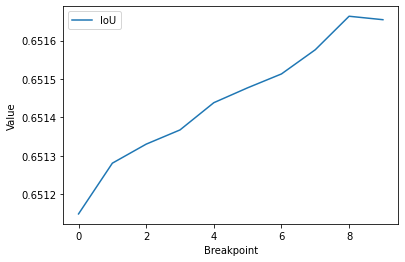

In [96]:
plt.plot(iou_mean_list, label = "IoU", linestyle="-")
plt.xlabel('Breakpoint')
plt.ylabel('Value')

plt.legend()

0.5

Now that i have saved the models, i need to read back in the better one and then get results that can be fitted back onto chicago

In [55]:
model_tree_binary = keras.models.load_model('C:/Users/johnf/Documents/UCL/thesis/code/models/multi_all_shared',
                                     custom_objects={'dice_metric':dice_metric,
                                                    "jaccard_distance_loss":jaccard_distance_loss})

In [26]:
model_tree_height = keras.models.load_model('C:/Users/johnf/Documents/UCL/thesis/code/models/height_model',
                                     custom_objects={'dice_metric':dice_metric,
                                                    "jaccard_distance_loss":jaccard_distance_loss})

In [58]:
inputPath="D:/final_data/2019_predictions"
filelist = []

# Load the images, and append them to a list.
for filepath in os.listdir(inputPath):
    if filepath.endswith((".tif")):
    #print(filepath)
        tempfile=inputPath+'/{0}'.format(filepath)
        filelist.append(tempfile)

len(filelist)

12972

In [59]:
# need to predict on all of the 2019 values
# need a dictionary which has a list of training paths and a list of validations paths
pred_data = np.array(filelist)

In [80]:
dataset = gdal.Open(pred_data[0])

In [81]:
images = []

# Generate data
# Store sample
dataset = gdal.Open(pred_data[72])
image = dataset.ReadAsArray()  # Returned image is a NumPy array with shape (16, 60, 60) for example.
images.append(image)  # Append the NumPy array to the list.

all_data= np.stack(images, axis= 0)
all_data[all_data < .0000001] = 0
X=all_data[:,:14,:,:] # separate out the band values
X = np.transpose(X, axes=[0, 2, 3, 1])
# normalize values of the input data to 0,1
X = X/X.max(axis=(3),keepdims=1)


In [83]:
# params = {'batch_size':1,
#          'shuffle': False}

# pred_generator = DataGenerator(mydict["pred_data"][0], **params)

predictions = model_tree_binary.predict(X)
#display(test_data, predictions)

# code to extra the true y values
x_test = X[:,:,:,0:3]

predictions = np.asarray(predictions)
print(predictions.shape)
# print(y_test.shape)
# print(x_test.shape)
# print(predictions[1,:].min())
# print(predictions[1,:].max())

print(predictions[0,:].shape)
print(predictions[0,:].min())
print(predictions[0,:].max())
print(predictions[1,:].shape)
print(predictions[1,:].min())
print(predictions[1,:].max())
print(predictions[2,:].shape)
print(predictions[2,:].min())
print(predictions[2,:].max())

1/1 [==============================] - 0s 22ms/step
(3, 1, 240, 240, 1)
(1, 240, 240, 1)
-0.13122538
0.361575
(1, 240, 240, 1)
0.0
1.0
(1, 240, 240, 1)
0.0
1.0


In [102]:
test=np.append(x_test,predictions[1,:],axis=3)

In [110]:
test[0,:,:,0:].shape

(240, 240, 4)

In [206]:
%%time
# i need to get each tif, append the new raster layers, remove the bands i dont need anymore (maybe keep rgb), and then save
inputPath="D:/final_data/2019_predictions/"


driver = gdal.GetDriverByName("GTiff")
driver.Register()
i=0
# Load the images, and append them to a list.
for filepath in os.listdir(inputPath):
    if filepath.endswith((".tif")):
        print(filepath)
        i=i+1
        print(i)
        images = []
        dataset = gdal.Open(inputPath+'/{0}'.format(filepath))
        gt = dataset.GetGeoTransform()
        proj = dataset.GetProjection()
        
        image = dataset.ReadAsArray()  # Returned image is a NumPy array with shape (16, 60, 60) for example.
        # predict values based on the two different models
        images.append(image)  # Append the NumPy array to the list.
        
        all_data= np.stack(images, axis= 0)
        all_data[all_data < .0000001] = 0
        X=all_data[:,:14,:,:] # separate out the band values
        X = np.transpose(X, axes=[0, 2, 3, 1])
        # normalize values of the input data to 0,1
        X = X/X.max(axis=(3),keepdims=1)
        
        predictions = model_tree_binary.predict(X)
        
        predictions2 = model_tree_height.predict(X)
        
        # code to extract the true y values
        x_test = X[:,:,:,0:3]
        predictions = np.asarray(predictions)
        predictions[predictions  >= .9] = 1
        predictions[predictions  < .9 ] = 0
        
        predictions2 = np.asarray(predictions2)*80
        
        # append the new layers
        final_raster=np.append(x_test,predictions[1,:],axis=3)
        final_raster=np.append(final_raster,predictions2,axis=3)

        
        
        # save solution
        save_raster = driver.Create('D:/final_data/2019_predictions_results'+'/{0}'.format(filepath), 
                                    xsize=240, ysize=240, bands = 5)
#         save_raster = driver.Create('D:/final_data/2019_predictions_results/test.tif', 
#                                     xsize=240, ysize=240, bands = 5)
        save_raster.SetGeoTransform(gt)
        save_raster.SetProjection(proj) 
        
        outband_1 = save_raster.GetRasterBand(1)
        outband_1.WriteArray(final_raster[0,:,:,3].astype(np.float32))
        outband_1.SetNoDataValue(np.nan)
        outband_1.FlushCache()
        #outband_1 = None
        
        outband_2 = save_raster.GetRasterBand(2)
        outband_2.WriteArray(final_raster[0,:,:,4].astype(np.float32))
        outband_2.SetNoDataValue(np.nan)
        outband_2.FlushCache()
        #outband_2 = None
        
        outband_3 = save_raster.GetRasterBand(3)
        outband_3.WriteArray(image[0].astype(np.float32))
        outband_3.SetNoDataValue(np.nan)
        outband_3.FlushCache()
        #outband_3 = None
        
        outband_4 = save_raster.GetRasterBand(4)
        outband_4.WriteArray(image[1].astype(np.float32))
        outband_4.SetNoDataValue(np.nan)
        outband_4.FlushCache()
        #outband_4 = None
        
        outband_5 = save_raster.GetRasterBand(5)
        outband_5.WriteArray(image[2].astype(np.float32))
        outband_5.SetNoDataValue(np.nan)
        outband_5.FlushCache()
        #outband_5 = None
        
        save_raster = None
# this process my change a bit for multiband
#https://gis.stackexchange.com/questions/239517/save-multiband-raster-with-gdal    
#https://gis.stackexchange.com/questions/335749/python-gdal-writing-image-output-all-pixels-as-zeros

# CPU times: total: 48min 56s
# Wall time: 1h 19min 51s

P_100_X0_961_X1_1200_Y0_721_Y1_960_1.tif
1
1/1 [==============================] - 0s 20ms/step
P_100_X0_961_X1_1200_Y0_721_Y1_960_10.tif
2
1/1 [==============================] - 0s 22ms/step
P_100_X0_961_X1_1200_Y0_721_Y1_960_14.tif
3
1/1 [==============================] - 0s 19ms/step
P_100_X0_961_X1_1200_Y0_721_Y1_960_15.tif
4
1/1 [==============================] - 0s 22ms/step
P_100_X0_961_X1_1200_Y0_721_Y1_960_16.tif
5
1/1 [==============================] - 0s 20ms/step
P_100_X0_961_X1_1200_Y0_721_Y1_960_17.tif
6
1/1 [==============================] - 0s 24ms/step
P_100_X0_961_X1_1200_Y0_721_Y1_960_18.tif
7
1/1 [==============================] - 0s 19ms/step
P_100_X0_961_X1_1200_Y0_721_Y1_960_20.tif
8
1/1 [==============================] - 0s 19ms/step
P_100_X0_961_X1_1200_Y0_721_Y1_960_21.tif
9
1/1 [==============================] - 0s 20ms/step
P_100_X0_961_X1_1200_Y0_721_Y1_960_23.tif
10
1/1 [==============================] - 0s 23ms/step
P_100_X0_961_X1_1200_Y0_721_Y1_960_25.ti

1/1 [==============================] - 0s 19ms/step
P_105_X0_961_X1_1200_Y0_1921_Y1_2160_25.tif
110
1/1 [==============================] - 0s 19ms/step
P_105_X0_961_X1_1200_Y0_1921_Y1_2160_26.tif
111
1/1 [==============================] - 0s 20ms/step
P_105_X0_961_X1_1200_Y0_1921_Y1_2160_27.tif
112
1/1 [==============================] - 0s 21ms/step
P_105_X0_961_X1_1200_Y0_1921_Y1_2160_28.tif
113
1/1 [==============================] - 0s 19ms/step
P_105_X0_961_X1_1200_Y0_1921_Y1_2160_3.tif
114
1/1 [==============================] - 0s 20ms/step
P_105_X0_961_X1_1200_Y0_1921_Y1_2160_5.tif
115
1/1 [==============================] - 0s 19ms/step
P_105_X0_961_X1_1200_Y0_1921_Y1_2160_7.tif
116
1/1 [==============================] - 0s 19ms/step
P_105_X0_961_X1_1200_Y0_1921_Y1_2160_8.tif
117
1/1 [==============================] - 0s 19ms/step
P_105_X0_961_X1_1200_Y0_1921_Y1_2160_9.tif
118
1/1 [==============================] - 0s 19ms/step
P_106_X0_961_X1_1200_Y0_2161_Y1_2400_1.tif
119
1/1 [=

<timed exec>:28: RuntimeWarning: invalid value encountered in true_divide


P_10_X0_1_X1_240_Y0_2161_Y1_2400_17.tif
200
1/1 [==============================] - 0s 18ms/step
P_10_X0_1_X1_240_Y0_2161_Y1_2400_20.tif
201
1/1 [==============================] - 0s 20ms/step
P_10_X0_1_X1_240_Y0_2161_Y1_2400_21.tif
202
1/1 [==============================] - 0s 17ms/step
P_10_X0_1_X1_240_Y0_2161_Y1_2400_22.tif
203
1/1 [==============================] - 0s 18ms/step
P_10_X0_1_X1_240_Y0_2161_Y1_2400_23.tif
204
1/1 [==============================] - 0s 21ms/step
P_10_X0_1_X1_240_Y0_2161_Y1_2400_24.tif
205
1/1 [==============================] - 0s 22ms/step
P_10_X0_1_X1_240_Y0_2161_Y1_2400_25.tif
206
1/1 [==============================] - 0s 20ms/step
P_10_X0_1_X1_240_Y0_2161_Y1_2400_26.tif
207
1/1 [==============================] - 0s 21ms/step
P_10_X0_1_X1_240_Y0_2161_Y1_2400_27.tif
208
1/1 [==============================] - 0s 21ms/step
P_10_X0_1_X1_240_Y0_2161_Y1_2400_28.tif
209
1/1 [==============================] - 0s 19ms/step
P_10_X0_1_X1_240_Y0_2161_Y1_2400_3.tif
2

1/1 [==============================] - 0s 18ms/step
P_115_X0_961_X1_1200_Y0_4321_Y1_4560_17.tif
309
1/1 [==============================] - 0s 19ms/step
P_115_X0_961_X1_1200_Y0_4321_Y1_4560_21.tif
310
1/1 [==============================] - 0s 20ms/step
P_115_X0_961_X1_1200_Y0_4321_Y1_4560_22.tif
311
1/1 [==============================] - 0s 20ms/step
P_115_X0_961_X1_1200_Y0_4321_Y1_4560_23.tif
312
1/1 [==============================] - 0s 21ms/step
P_115_X0_961_X1_1200_Y0_4321_Y1_4560_26.tif
313
1/1 [==============================] - 0s 20ms/step
P_115_X0_961_X1_1200_Y0_4321_Y1_4560_28.tif
314
1/1 [==============================] - 0s 21ms/step
P_115_X0_961_X1_1200_Y0_4321_Y1_4560_3.tif
315
1/1 [==============================] - 0s 21ms/step
P_115_X0_961_X1_1200_Y0_4321_Y1_4560_5.tif
316
1/1 [==============================] - 0s 19ms/step
P_115_X0_961_X1_1200_Y0_4321_Y1_4560_8.tif
317
1/1 [==============================] - 0s 19ms/step
P_115_X0_961_X1_1200_Y0_4321_Y1_4560_9.tif
318
1/1 

1/1 [==============================] - 0s 18ms/step
P_120_X0_961_X1_1200_Y0_5521_Y1_5760_24.tif
417
1/1 [==============================] - 0s 19ms/step
P_120_X0_961_X1_1200_Y0_5521_Y1_5760_26.tif
418
1/1 [==============================] - 0s 19ms/step
P_120_X0_961_X1_1200_Y0_5521_Y1_5760_28.tif
419
1/1 [==============================] - 0s 19ms/step
P_120_X0_961_X1_1200_Y0_5521_Y1_5760_3.tif
420
1/1 [==============================] - 0s 19ms/step
P_120_X0_961_X1_1200_Y0_5521_Y1_5760_4.tif
421
1/1 [==============================] - 0s 20ms/step
P_120_X0_961_X1_1200_Y0_5521_Y1_5760_5.tif
422
1/1 [==============================] - 0s 21ms/step
P_120_X0_961_X1_1200_Y0_5521_Y1_5760_8.tif
423
1/1 [==============================] - 0s 18ms/step
P_121_X0_1201_X1_1440_Y0_1_Y1_240_1.tif
424
1/1 [==============================] - 0s 22ms/step
P_121_X0_1201_X1_1440_Y0_1_Y1_240_10.tif
425
1/1 [==============================] - 0s 19ms/step
P_121_X0_1201_X1_1440_Y0_1_Y1_240_14.tif
426
1/1 [=========

1/1 [==============================] - 0s 19ms/step
P_123_X0_1201_X1_1440_Y0_481_Y1_720_27.tif
472
1/1 [==============================] - 0s 26ms/step
P_123_X0_1201_X1_1440_Y0_481_Y1_720_28.tif
473
1/1 [==============================] - 0s 20ms/step
P_123_X0_1201_X1_1440_Y0_481_Y1_720_3.tif
474
1/1 [==============================] - 0s 20ms/step
P_123_X0_1201_X1_1440_Y0_481_Y1_720_7.tif
475
1/1 [==============================] - 0s 19ms/step
P_123_X0_1201_X1_1440_Y0_481_Y1_720_8.tif
476
1/1 [==============================] - 0s 18ms/step
P_123_X0_1201_X1_1440_Y0_481_Y1_720_9.tif
477
1/1 [==============================] - 0s 20ms/step
P_124_X0_1201_X1_1440_Y0_721_Y1_960_1.tif
478
1/1 [==============================] - 0s 19ms/step
P_124_X0_1201_X1_1440_Y0_721_Y1_960_10.tif
479
1/1 [==============================] - 0s 18ms/step
P_124_X0_1201_X1_1440_Y0_721_Y1_960_14.tif
480
1/1 [==============================] - 0s 18ms/step
P_124_X0_1201_X1_1440_Y0_721_Y1_960_15.tif
481
1/1 [==========

P_129_X0_1201_X1_1440_Y0_1921_Y1_2160_14.tif
579
1/1 [==============================] - 0s 19ms/step
P_129_X0_1201_X1_1440_Y0_1921_Y1_2160_15.tif
580
1/1 [==============================] - 0s 19ms/step
P_129_X0_1201_X1_1440_Y0_1921_Y1_2160_16.tif
581
1/1 [==============================] - 0s 19ms/step
P_129_X0_1201_X1_1440_Y0_1921_Y1_2160_17.tif
582
1/1 [==============================] - 0s 18ms/step
P_129_X0_1201_X1_1440_Y0_1921_Y1_2160_18.tif
583
1/1 [==============================] - 0s 19ms/step
P_129_X0_1201_X1_1440_Y0_1921_Y1_2160_20.tif
584
1/1 [==============================] - 0s 20ms/step
P_129_X0_1201_X1_1440_Y0_1921_Y1_2160_21.tif
585
1/1 [==============================] - 0s 21ms/step
P_129_X0_1201_X1_1440_Y0_1921_Y1_2160_22.tif
586
1/1 [==============================] - 0s 18ms/step
P_129_X0_1201_X1_1440_Y0_1921_Y1_2160_23.tif
587
1/1 [==============================] - 0s 18ms/step
P_129_X0_1201_X1_1440_Y0_1921_Y1_2160_25.tif
588
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 19ms/step
P_130_X0_1201_X1_1440_Y0_2161_Y1_2400_9.tif
634
1/1 [==============================] - 0s 18ms/step
P_131_X0_1201_X1_1440_Y0_2401_Y1_2640_1.tif
635
1/1 [==============================] - 0s 19ms/step
P_131_X0_1201_X1_1440_Y0_2401_Y1_2640_10.tif
636
1/1 [==============================] - 0s 21ms/step
P_131_X0_1201_X1_1440_Y0_2401_Y1_2640_14.tif
637
1/1 [==============================] - 0s 18ms/step
P_131_X0_1201_X1_1440_Y0_2401_Y1_2640_15.tif
638
1/1 [==============================] - 0s 20ms/step
P_131_X0_1201_X1_1440_Y0_2401_Y1_2640_16.tif
639
1/1 [==============================] - 0s 19ms/step
P_131_X0_1201_X1_1440_Y0_2401_Y1_2640_17.tif
640
1/1 [==============================] - 0s 22ms/step
P_131_X0_1201_X1_1440_Y0_2401_Y1_2640_20.tif
641
1/1 [==============================] - 0s 19ms/step
P_131_X0_1201_X1_1440_Y0_2401_Y1_2640_21.tif
642
1/1 [==============================] - 0s 19ms/step
P_131_X0_1201_X1_1440_Y0_2401_Y1_2640_22.

1/1 [==============================] - 0s 20ms/step
P_136_X0_1201_X1_1440_Y0_3601_Y1_3840_28.tif
741
1/1 [==============================] - 0s 19ms/step
P_136_X0_1201_X1_1440_Y0_3601_Y1_3840_3.tif
742
1/1 [==============================] - 0s 20ms/step
P_136_X0_1201_X1_1440_Y0_3601_Y1_3840_5.tif
743
1/1 [==============================] - 0s 21ms/step
P_136_X0_1201_X1_1440_Y0_3601_Y1_3840_8.tif
744
1/1 [==============================] - 0s 20ms/step
P_136_X0_1201_X1_1440_Y0_3601_Y1_3840_9.tif
745
1/1 [==============================] - 0s 18ms/step
P_137_X0_1201_X1_1440_Y0_3841_Y1_4080_1.tif
746
1/1 [==============================] - 0s 21ms/step
P_137_X0_1201_X1_1440_Y0_3841_Y1_4080_10.tif
747
1/1 [==============================] - 0s 18ms/step
P_137_X0_1201_X1_1440_Y0_3841_Y1_4080_12.tif
748
1/1 [==============================] - 0s 18ms/step
P_137_X0_1201_X1_1440_Y0_3841_Y1_4080_14.tif
749
1/1 [==============================] - 0s 19ms/step
P_137_X0_1201_X1_1440_Y0_3841_Y1_4080_15.tif

P_139_X0_1201_X1_1440_Y0_4321_Y1_4560_8.tif
794
1/1 [==============================] - 0s 19ms/step
P_139_X0_1201_X1_1440_Y0_4321_Y1_4560_9.tif
795
1/1 [==============================] - 0s 19ms/step
P_13_X0_1_X1_240_Y0_2881_Y1_3120_1.tif
796
1/1 [==============================] - 0s 18ms/step
P_13_X0_1_X1_240_Y0_2881_Y1_3120_10.tif
797
1/1 [==============================] - 0s 20ms/step
P_13_X0_1_X1_240_Y0_2881_Y1_3120_14.tif
798
1/1 [==============================] - 0s 19ms/step
P_13_X0_1_X1_240_Y0_2881_Y1_3120_15.tif
799
1/1 [==============================] - 0s 18ms/step
P_13_X0_1_X1_240_Y0_2881_Y1_3120_16.tif
800
1/1 [==============================] - 0s 21ms/step
P_13_X0_1_X1_240_Y0_2881_Y1_3120_17.tif
801
1/1 [==============================] - 0s 20ms/step
P_13_X0_1_X1_240_Y0_2881_Y1_3120_20.tif
802
1/1 [==============================] - 0s 19ms/step
P_13_X0_1_X1_240_Y0_2881_Y1_3120_21.tif
803
1/1 [==============================] - 0s 18ms/step
P_13_X0_1_X1_240_Y0_2881_Y1_3120_

1/1 [==============================] - 0s 20ms/step
P_142_X0_1201_X1_1440_Y0_5041_Y1_5280_1.tif
849
1/1 [==============================] - 0s 19ms/step
P_142_X0_1201_X1_1440_Y0_5041_Y1_5280_10.tif
850
1/1 [==============================] - 0s 20ms/step
P_142_X0_1201_X1_1440_Y0_5041_Y1_5280_12.tif
851
1/1 [==============================] - 0s 19ms/step
P_142_X0_1201_X1_1440_Y0_5041_Y1_5280_13.tif
852
1/1 [==============================] - 0s 20ms/step
P_142_X0_1201_X1_1440_Y0_5041_Y1_5280_14.tif
853
1/1 [==============================] - 0s 19ms/step
P_142_X0_1201_X1_1440_Y0_5041_Y1_5280_15.tif
854
1/1 [==============================] - 0s 19ms/step
P_142_X0_1201_X1_1440_Y0_5041_Y1_5280_16.tif
855
1/1 [==============================] - 0s 20ms/step
P_142_X0_1201_X1_1440_Y0_5041_Y1_5280_17.tif
856
1/1 [==============================] - 0s 19ms/step
P_142_X0_1201_X1_1440_Y0_5041_Y1_5280_21.tif
857
1/1 [==============================] - 0s 19ms/step
P_142_X0_1201_X1_1440_Y0_5041_Y1_5280_22

P_145_X0_1441_X1_1680_Y0_1_Y1_240_1.tif
902
1/1 [==============================] - 0s 21ms/step
P_145_X0_1441_X1_1680_Y0_1_Y1_240_10.tif
903
1/1 [==============================] - 0s 18ms/step
P_145_X0_1441_X1_1680_Y0_1_Y1_240_14.tif
904
1/1 [==============================] - 0s 20ms/step
P_145_X0_1441_X1_1680_Y0_1_Y1_240_16.tif
905
1/1 [==============================] - 0s 20ms/step
P_145_X0_1441_X1_1680_Y0_1_Y1_240_17.tif
906
1/1 [==============================] - 0s 20ms/step
P_145_X0_1441_X1_1680_Y0_1_Y1_240_18.tif
907
1/1 [==============================] - 0s 21ms/step
P_145_X0_1441_X1_1680_Y0_1_Y1_240_20.tif
908
1/1 [==============================] - 0s 23ms/step
P_145_X0_1441_X1_1680_Y0_1_Y1_240_21.tif
909
1/1 [==============================] - 0s 19ms/step
P_145_X0_1441_X1_1680_Y0_1_Y1_240_25.tif
910
1/1 [==============================] - 0s 18ms/step
P_145_X0_1441_X1_1680_Y0_1_Y1_240_26.tif
911
1/1 [==============================] - 0s 19ms/step
P_145_X0_1441_X1_1680_Y0_1_Y1_2

1/1 [==============================] - 0s 19ms/step
P_150_X0_1441_X1_1680_Y0_1201_Y1_1440_14.tif
1011
1/1 [==============================] - 0s 19ms/step
P_150_X0_1441_X1_1680_Y0_1201_Y1_1440_15.tif
1012
1/1 [==============================] - 0s 19ms/step
P_150_X0_1441_X1_1680_Y0_1201_Y1_1440_16.tif
1013
1/1 [==============================] - 0s 18ms/step
P_150_X0_1441_X1_1680_Y0_1201_Y1_1440_17.tif
1014
1/1 [==============================] - 0s 20ms/step
P_150_X0_1441_X1_1680_Y0_1201_Y1_1440_18.tif
1015
1/1 [==============================] - 0s 20ms/step
P_150_X0_1441_X1_1680_Y0_1201_Y1_1440_20.tif
1016
1/1 [==============================] - 0s 19ms/step
P_150_X0_1441_X1_1680_Y0_1201_Y1_1440_21.tif
1017
1/1 [==============================] - 0s 19ms/step
P_150_X0_1441_X1_1680_Y0_1201_Y1_1440_22.tif
1018
1/1 [==============================] - 0s 19ms/step
P_150_X0_1441_X1_1680_Y0_1201_Y1_1440_23.tif
1019
1/1 [==============================] - 0s 19ms/step
P_150_X0_1441_X1_1680_Y0_1201_

P_155_X0_1441_X1_1680_Y0_2401_Y1_2640_22.tif
1117
1/1 [==============================] - 0s 20ms/step
P_155_X0_1441_X1_1680_Y0_2401_Y1_2640_23.tif
1118
1/1 [==============================] - 0s 20ms/step
P_155_X0_1441_X1_1680_Y0_2401_Y1_2640_25.tif
1119
1/1 [==============================] - 0s 19ms/step
P_155_X0_1441_X1_1680_Y0_2401_Y1_2640_26.tif
1120
1/1 [==============================] - 0s 19ms/step
P_155_X0_1441_X1_1680_Y0_2401_Y1_2640_27.tif
1121
1/1 [==============================] - 0s 19ms/step
P_155_X0_1441_X1_1680_Y0_2401_Y1_2640_28.tif
1122
1/1 [==============================] - 0s 20ms/step
P_155_X0_1441_X1_1680_Y0_2401_Y1_2640_3.tif
1123
1/1 [==============================] - 0s 19ms/step
P_155_X0_1441_X1_1680_Y0_2401_Y1_2640_4.tif
1124
1/1 [==============================] - 0s 19ms/step
P_155_X0_1441_X1_1680_Y0_2401_Y1_2640_5.tif
1125
1/1 [==============================] - 0s 20ms/step
P_155_X0_1441_X1_1680_Y0_2401_Y1_2640_7.tif
1126
1/1 [==============================]

1/1 [==============================] - 0s 19ms/step
P_160_X0_1441_X1_1680_Y0_3601_Y1_3840_17.tif
1225
1/1 [==============================] - 0s 19ms/step
P_160_X0_1441_X1_1680_Y0_3601_Y1_3840_20.tif
1226
1/1 [==============================] - 0s 21ms/step
P_160_X0_1441_X1_1680_Y0_3601_Y1_3840_21.tif
1227
1/1 [==============================] - 0s 19ms/step
P_160_X0_1441_X1_1680_Y0_3601_Y1_3840_22.tif
1228
1/1 [==============================] - 0s 19ms/step
P_160_X0_1441_X1_1680_Y0_3601_Y1_3840_23.tif
1229
1/1 [==============================] - 0s 19ms/step
P_160_X0_1441_X1_1680_Y0_3601_Y1_3840_26.tif
1230
1/1 [==============================] - 0s 20ms/step
P_160_X0_1441_X1_1680_Y0_3601_Y1_3840_28.tif
1231
1/1 [==============================] - 0s 18ms/step
P_160_X0_1441_X1_1680_Y0_3601_Y1_3840_3.tif
1232
1/1 [==============================] - 0s 19ms/step
P_160_X0_1441_X1_1680_Y0_3601_Y1_3840_5.tif
1233
1/1 [==============================] - 0s 19ms/step
P_160_X0_1441_X1_1680_Y0_3601_Y1

1/1 [==============================] - 0s 20ms/step
P_167_X0_1441_X1_1680_Y0_5281_Y1_5520_10.tif
1331
1/1 [==============================] - 0s 21ms/step
P_167_X0_1441_X1_1680_Y0_5281_Y1_5520_13.tif
1332
1/1 [==============================] - 0s 20ms/step
P_167_X0_1441_X1_1680_Y0_5281_Y1_5520_14.tif
1333
1/1 [==============================] - 0s 19ms/step
P_167_X0_1441_X1_1680_Y0_5281_Y1_5520_15.tif
1334
1/1 [==============================] - 0s 18ms/step
P_167_X0_1441_X1_1680_Y0_5281_Y1_5520_16.tif
1335
1/1 [==============================] - 0s 19ms/step
P_167_X0_1441_X1_1680_Y0_5281_Y1_5520_17.tif
1336
1/1 [==============================] - 0s 20ms/step
P_167_X0_1441_X1_1680_Y0_5281_Y1_5520_2.tif
1337
1/1 [==============================] - 0s 19ms/step
P_167_X0_1441_X1_1680_Y0_5281_Y1_5520_21.tif
1338
1/1 [==============================] - 0s 18ms/step
P_167_X0_1441_X1_1680_Y0_5281_Y1_5520_22.tif
1339
1/1 [==============================] - 0s 21ms/step
P_167_X0_1441_X1_1680_Y0_5281_Y

1/1 [==============================] - 0s 20ms/step
P_172_X0_1681_X1_1920_Y0_721_Y1_960_21.tif
1439
1/1 [==============================] - 0s 20ms/step
P_172_X0_1681_X1_1920_Y0_721_Y1_960_25.tif
1440
1/1 [==============================] - 0s 20ms/step
P_172_X0_1681_X1_1920_Y0_721_Y1_960_26.tif
1441
1/1 [==============================] - 0s 22ms/step
P_172_X0_1681_X1_1920_Y0_721_Y1_960_27.tif
1442
1/1 [==============================] - 0s 19ms/step
P_172_X0_1681_X1_1920_Y0_721_Y1_960_28.tif
1443
1/1 [==============================] - 0s 20ms/step
P_172_X0_1681_X1_1920_Y0_721_Y1_960_3.tif
1444
1/1 [==============================] - 0s 20ms/step
P_172_X0_1681_X1_1920_Y0_721_Y1_960_5.tif
1445
1/1 [==============================] - 0s 19ms/step
P_172_X0_1681_X1_1920_Y0_721_Y1_960_7.tif
1446
1/1 [==============================] - 0s 20ms/step
P_172_X0_1681_X1_1920_Y0_721_Y1_960_8.tif
1447
1/1 [==============================] - 0s 20ms/step
P_172_X0_1681_X1_1920_Y0_721_Y1_960_9.tif
1448
1/1 [

1/1 [==============================] - 0s 19ms/step
P_177_X0_1681_X1_1920_Y0_1921_Y1_2160_4.tif
1545
1/1 [==============================] - 0s 22ms/step
P_177_X0_1681_X1_1920_Y0_1921_Y1_2160_5.tif
1546
1/1 [==============================] - 0s 20ms/step
P_177_X0_1681_X1_1920_Y0_1921_Y1_2160_7.tif
1547
1/1 [==============================] - 0s 20ms/step
P_177_X0_1681_X1_1920_Y0_1921_Y1_2160_8.tif
1548
1/1 [==============================] - 0s 19ms/step
P_177_X0_1681_X1_1920_Y0_1921_Y1_2160_9.tif
1549
1/1 [==============================] - 0s 20ms/step
P_178_X0_1681_X1_1920_Y0_2161_Y1_2400_1.tif
1550
1/1 [==============================] - 0s 19ms/step
P_178_X0_1681_X1_1920_Y0_2161_Y1_2400_10.tif
1551
1/1 [==============================] - 0s 19ms/step
P_178_X0_1681_X1_1920_Y0_2161_Y1_2400_13.tif
1552
1/1 [==============================] - 0s 20ms/step
P_178_X0_1681_X1_1920_Y0_2161_Y1_2400_14.tif
1553
1/1 [==============================] - 0s 18ms/step
P_178_X0_1681_X1_1920_Y0_2161_Y1_240

1/1 [==============================] - 0s 22ms/step
P_182_X0_1681_X1_1920_Y0_3121_Y1_3360_10.tif
1652
1/1 [==============================] - 0s 19ms/step
P_182_X0_1681_X1_1920_Y0_3121_Y1_3360_13.tif
1653
1/1 [==============================] - 0s 19ms/step
P_182_X0_1681_X1_1920_Y0_3121_Y1_3360_14.tif
1654
1/1 [==============================] - 0s 20ms/step
P_182_X0_1681_X1_1920_Y0_3121_Y1_3360_15.tif
1655
1/1 [==============================] - 0s 19ms/step
P_182_X0_1681_X1_1920_Y0_3121_Y1_3360_16.tif
1656
1/1 [==============================] - 0s 19ms/step
P_182_X0_1681_X1_1920_Y0_3121_Y1_3360_17.tif
1657
1/1 [==============================] - 0s 19ms/step
P_182_X0_1681_X1_1920_Y0_3121_Y1_3360_20.tif
1658
1/1 [==============================] - 0s 19ms/step
P_182_X0_1681_X1_1920_Y0_3121_Y1_3360_21.tif
1659
1/1 [==============================] - 0s 19ms/step
P_182_X0_1681_X1_1920_Y0_3121_Y1_3360_22.tif
1660
1/1 [==============================] - 0s 20ms/step
P_182_X0_1681_X1_1920_Y0_3121_

P_187_X0_1681_X1_1920_Y0_4321_Y1_4560_9.tif
1758
1/1 [==============================] - 0s 19ms/step
P_188_X0_1681_X1_1920_Y0_4561_Y1_4800_1.tif
1759
1/1 [==============================] - 0s 19ms/step
P_188_X0_1681_X1_1920_Y0_4561_Y1_4800_10.tif
1760
1/1 [==============================] - 0s 18ms/step
P_188_X0_1681_X1_1920_Y0_4561_Y1_4800_13.tif
1761
1/1 [==============================] - 0s 18ms/step
P_188_X0_1681_X1_1920_Y0_4561_Y1_4800_14.tif
1762
1/1 [==============================] - 0s 19ms/step
P_188_X0_1681_X1_1920_Y0_4561_Y1_4800_15.tif
1763
1/1 [==============================] - 0s 19ms/step
P_188_X0_1681_X1_1920_Y0_4561_Y1_4800_16.tif
1764
1/1 [==============================] - 0s 20ms/step
P_188_X0_1681_X1_1920_Y0_4561_Y1_4800_17.tif
1765
1/1 [==============================] - 0s 21ms/step
P_188_X0_1681_X1_1920_Y0_4561_Y1_4800_21.tif
1766
1/1 [==============================] - 0s 19ms/step
P_188_X0_1681_X1_1920_Y0_4561_Y1_4800_22.tif
1767
1/1 [=============================

1/1 [==============================] - 0s 18ms/step
P_193_X0_1921_X1_2160_Y0_1_Y1_240_17.tif
1866
1/1 [==============================] - 0s 19ms/step
P_193_X0_1921_X1_2160_Y0_1_Y1_240_18.tif
1867
1/1 [==============================] - 0s 19ms/step
P_193_X0_1921_X1_2160_Y0_1_Y1_240_20.tif
1868
1/1 [==============================] - 0s 19ms/step
P_193_X0_1921_X1_2160_Y0_1_Y1_240_21.tif
1869
1/1 [==============================] - 0s 20ms/step
P_193_X0_1921_X1_2160_Y0_1_Y1_240_25.tif
1870
1/1 [==============================] - 0s 20ms/step
P_193_X0_1921_X1_2160_Y0_1_Y1_240_26.tif
1871
1/1 [==============================] - 0s 20ms/step
P_193_X0_1921_X1_2160_Y0_1_Y1_240_27.tif
1872
1/1 [==============================] - 0s 19ms/step
P_193_X0_1921_X1_2160_Y0_1_Y1_240_28.tif
1873
1/1 [==============================] - 0s 19ms/step
P_193_X0_1921_X1_2160_Y0_1_Y1_240_3.tif
1874
1/1 [==============================] - 0s 18ms/step
P_193_X0_1921_X1_2160_Y0_1_Y1_240_4.tif
1875
1/1 [=================

1/1 [==============================] - 0s 19ms/step
P_199_X0_1921_X1_2160_Y0_1441_Y1_1680_17.tif
1973
1/1 [==============================] - 0s 19ms/step
P_199_X0_1921_X1_2160_Y0_1441_Y1_1680_18.tif
1974
1/1 [==============================] - 0s 19ms/step
P_199_X0_1921_X1_2160_Y0_1441_Y1_1680_20.tif
1975
1/1 [==============================] - 0s 20ms/step
P_199_X0_1921_X1_2160_Y0_1441_Y1_1680_21.tif
1976
1/1 [==============================] - 0s 20ms/step
P_199_X0_1921_X1_2160_Y0_1441_Y1_1680_22.tif
1977
1/1 [==============================] - 0s 21ms/step
P_199_X0_1921_X1_2160_Y0_1441_Y1_1680_25.tif
1978
1/1 [==============================] - 0s 19ms/step
P_199_X0_1921_X1_2160_Y0_1441_Y1_1680_26.tif
1979
1/1 [==============================] - 0s 21ms/step
P_199_X0_1921_X1_2160_Y0_1441_Y1_1680_27.tif
1980
1/1 [==============================] - 0s 21ms/step
P_199_X0_1921_X1_2160_Y0_1441_Y1_1680_28.tif
1981
1/1 [==============================] - 0s 20ms/step
P_199_X0_1921_X1_2160_Y0_1441_

P_202_X0_1921_X1_2160_Y0_2161_Y1_2400_7.tif
2081
1/1 [==============================] - 0s 21ms/step
P_202_X0_1921_X1_2160_Y0_2161_Y1_2400_8.tif
2082
1/1 [==============================] - 0s 21ms/step
P_202_X0_1921_X1_2160_Y0_2161_Y1_2400_9.tif
2083
1/1 [==============================] - 0s 19ms/step
P_203_X0_1921_X1_2160_Y0_2401_Y1_2640_1.tif
2084
1/1 [==============================] - 0s 20ms/step
P_203_X0_1921_X1_2160_Y0_2401_Y1_2640_10.tif
2085
1/1 [==============================] - 0s 18ms/step
P_203_X0_1921_X1_2160_Y0_2401_Y1_2640_13.tif
2086
1/1 [==============================] - 0s 19ms/step
P_203_X0_1921_X1_2160_Y0_2401_Y1_2640_14.tif
2087
1/1 [==============================] - 0s 17ms/step
P_203_X0_1921_X1_2160_Y0_2401_Y1_2640_15.tif
2088
1/1 [==============================] - 0s 19ms/step
P_203_X0_1921_X1_2160_Y0_2401_Y1_2640_16.tif
2089
1/1 [==============================] - 0s 19ms/step
P_203_X0_1921_X1_2160_Y0_2401_Y1_2640_17.tif
2090
1/1 [==============================]

1/1 [==============================] - 0s 20ms/step
P_205_X0_1921_X1_2160_Y0_2881_Y1_3120_22.tif
2135
1/1 [==============================] - 0s 21ms/step
P_205_X0_1921_X1_2160_Y0_2881_Y1_3120_23.tif
2136
1/1 [==============================] - 0s 19ms/step
P_205_X0_1921_X1_2160_Y0_2881_Y1_3120_25.tif
2137
1/1 [==============================] - 0s 19ms/step
P_205_X0_1921_X1_2160_Y0_2881_Y1_3120_26.tif
2138
1/1 [==============================] - 0s 19ms/step
P_205_X0_1921_X1_2160_Y0_2881_Y1_3120_27.tif
2139
1/1 [==============================] - 0s 19ms/step
P_205_X0_1921_X1_2160_Y0_2881_Y1_3120_28.tif
2140
1/1 [==============================] - 0s 19ms/step
P_205_X0_1921_X1_2160_Y0_2881_Y1_3120_3.tif
2141
1/1 [==============================] - 0s 19ms/step
P_205_X0_1921_X1_2160_Y0_2881_Y1_3120_4.tif
2142
1/1 [==============================] - 0s 20ms/step
P_205_X0_1921_X1_2160_Y0_2881_Y1_3120_5.tif
2143
1/1 [==============================] - 0s 20ms/step
P_205_X0_1921_X1_2160_Y0_2881_Y1_

1/1 [==============================] - 0s 19ms/step
P_208_X0_1921_X1_2160_Y0_3601_Y1_3840_10.tif
2188
1/1 [==============================] - 0s 19ms/step
P_208_X0_1921_X1_2160_Y0_3601_Y1_3840_13.tif
2189
1/1 [==============================] - 0s 19ms/step
P_208_X0_1921_X1_2160_Y0_3601_Y1_3840_14.tif
2190
1/1 [==============================] - 0s 18ms/step
P_208_X0_1921_X1_2160_Y0_3601_Y1_3840_15.tif
2191
1/1 [==============================] - 0s 20ms/step
P_208_X0_1921_X1_2160_Y0_3601_Y1_3840_16.tif
2192
1/1 [==============================] - 0s 19ms/step
P_208_X0_1921_X1_2160_Y0_3601_Y1_3840_17.tif
2193
1/1 [==============================] - 0s 19ms/step
P_208_X0_1921_X1_2160_Y0_3601_Y1_3840_20.tif
2194
1/1 [==============================] - 0s 20ms/step
P_208_X0_1921_X1_2160_Y0_3601_Y1_3840_21.tif
2195
1/1 [==============================] - 0s 21ms/step
P_208_X0_1921_X1_2160_Y0_3601_Y1_3840_22.tif
2196
1/1 [==============================] - 0s 20ms/step
P_208_X0_1921_X1_2160_Y0_3601_

1/1 [==============================] - 0s 19ms/step
P_213_X0_1921_X1_2160_Y0_4801_Y1_5040_13.tif
2295
1/1 [==============================] - 0s 23ms/step
P_213_X0_1921_X1_2160_Y0_4801_Y1_5040_14.tif
2296
1/1 [==============================] - 0s 20ms/step
P_213_X0_1921_X1_2160_Y0_4801_Y1_5040_15.tif
2297
1/1 [==============================] - 0s 19ms/step
P_213_X0_1921_X1_2160_Y0_4801_Y1_5040_16.tif
2298
1/1 [==============================] - 0s 19ms/step
P_213_X0_1921_X1_2160_Y0_4801_Y1_5040_17.tif
2299
1/1 [==============================] - 0s 19ms/step
P_213_X0_1921_X1_2160_Y0_4801_Y1_5040_21.tif
2300
1/1 [==============================] - 0s 19ms/step
P_213_X0_1921_X1_2160_Y0_4801_Y1_5040_22.tif
2301
1/1 [==============================] - 0s 18ms/step
P_213_X0_1921_X1_2160_Y0_4801_Y1_5040_23.tif
2302
1/1 [==============================] - 0s 20ms/step
P_213_X0_1921_X1_2160_Y0_4801_Y1_5040_26.tif
2303
1/1 [==============================] - 0s 19ms/step
P_213_X0_1921_X1_2160_Y0_4801_

P_216_X0_1921_X1_2160_Y0_5521_Y1_5760_16.tif
2348
1/1 [==============================] - 0s 19ms/step
P_216_X0_1921_X1_2160_Y0_5521_Y1_5760_17.tif
2349
1/1 [==============================] - 0s 21ms/step
P_216_X0_1921_X1_2160_Y0_5521_Y1_5760_2.tif
2350
1/1 [==============================] - 0s 19ms/step
P_216_X0_1921_X1_2160_Y0_5521_Y1_5760_21.tif
2351
1/1 [==============================] - 0s 19ms/step
P_216_X0_1921_X1_2160_Y0_5521_Y1_5760_22.tif
2352
1/1 [==============================] - 0s 19ms/step
P_216_X0_1921_X1_2160_Y0_5521_Y1_5760_23.tif
2353
1/1 [==============================] - 0s 19ms/step
P_216_X0_1921_X1_2160_Y0_5521_Y1_5760_26.tif
2354
1/1 [==============================] - 0s 20ms/step
P_216_X0_1921_X1_2160_Y0_5521_Y1_5760_28.tif
2355
1/1 [==============================] - 0s 19ms/step
P_216_X0_1921_X1_2160_Y0_5521_Y1_5760_3.tif
2356
1/1 [==============================] - 0s 19ms/step
P_216_X0_1921_X1_2160_Y0_5521_Y1_5760_4.tif
2357
1/1 [==============================

1/1 [==============================] - 0s 19ms/step
P_219_X0_2161_X1_2400_Y0_481_Y1_720_28.tif
2403
1/1 [==============================] - 0s 19ms/step
P_219_X0_2161_X1_2400_Y0_481_Y1_720_3.tif
2404
1/1 [==============================] - 0s 19ms/step
P_219_X0_2161_X1_2400_Y0_481_Y1_720_7.tif
2405
1/1 [==============================] - 0s 18ms/step
P_219_X0_2161_X1_2400_Y0_481_Y1_720_8.tif
2406
1/1 [==============================] - 0s 20ms/step
P_219_X0_2161_X1_2400_Y0_481_Y1_720_9.tif
2407
1/1 [==============================] - 0s 19ms/step
P_21_X0_1_X1_240_Y0_4801_Y1_5040_10.tif
2408
1/1 [==============================] - 0s 19ms/step
P_21_X0_1_X1_240_Y0_4801_Y1_5040_12.tif
2409
1/1 [==============================] - 0s 18ms/step
P_21_X0_1_X1_240_Y0_4801_Y1_5040_14.tif
2410
1/1 [==============================] - 0s 19ms/step
P_21_X0_1_X1_240_Y0_4801_Y1_5040_15.tif
2411
1/1 [==============================] - 0s 21ms/step
P_21_X0_1_X1_240_Y0_4801_Y1_5040_16.tif
2412
1/1 [==============

1/1 [==============================] - 0s 19ms/step
P_224_X0_2161_X1_2400_Y0_1681_Y1_1920_27.tif
2510
1/1 [==============================] - 0s 22ms/step
P_224_X0_2161_X1_2400_Y0_1681_Y1_1920_28.tif
2511
1/1 [==============================] - 0s 19ms/step
P_224_X0_2161_X1_2400_Y0_1681_Y1_1920_3.tif
2512
1/1 [==============================] - 0s 19ms/step
P_224_X0_2161_X1_2400_Y0_1681_Y1_1920_4.tif
2513
1/1 [==============================] - 0s 18ms/step
P_224_X0_2161_X1_2400_Y0_1681_Y1_1920_5.tif
2514
1/1 [==============================] - 0s 19ms/step
P_224_X0_2161_X1_2400_Y0_1681_Y1_1920_7.tif
2515
1/1 [==============================] - 0s 19ms/step
P_224_X0_2161_X1_2400_Y0_1681_Y1_1920_8.tif
2516
1/1 [==============================] - 0s 18ms/step
P_224_X0_2161_X1_2400_Y0_1681_Y1_1920_9.tif
2517
1/1 [==============================] - 0s 18ms/step
P_225_X0_2161_X1_2400_Y0_1921_Y1_2160_1.tif
2518
1/1 [==============================] - 0s 19ms/step
P_225_X0_2161_X1_2400_Y0_1921_Y1_2160

P_227_X0_2161_X1_2400_Y0_2401_Y1_2640_20.tif
2563
1/1 [==============================] - 0s 20ms/step
P_227_X0_2161_X1_2400_Y0_2401_Y1_2640_21.tif
2564
1/1 [==============================] - 0s 21ms/step
P_227_X0_2161_X1_2400_Y0_2401_Y1_2640_23.tif
2565
1/1 [==============================] - 0s 20ms/step
P_227_X0_2161_X1_2400_Y0_2401_Y1_2640_25.tif
2566
1/1 [==============================] - 0s 19ms/step
P_227_X0_2161_X1_2400_Y0_2401_Y1_2640_26.tif
2567
1/1 [==============================] - 0s 20ms/step
P_227_X0_2161_X1_2400_Y0_2401_Y1_2640_27.tif
2568
1/1 [==============================] - 0s 19ms/step
P_227_X0_2161_X1_2400_Y0_2401_Y1_2640_28.tif
2569
1/1 [==============================] - 0s 18ms/step
P_227_X0_2161_X1_2400_Y0_2401_Y1_2640_3.tif
2570
1/1 [==============================] - 0s 18ms/step
P_227_X0_2161_X1_2400_Y0_2401_Y1_2640_4.tif
2571
1/1 [==============================] - 0s 20ms/step
P_227_X0_2161_X1_2400_Y0_2401_Y1_2640_5.tif
2572
1/1 [==============================

1/1 [==============================] - 0s 19ms/step
P_232_X0_2161_X1_2400_Y0_3601_Y1_3840_1.tif
2671
1/1 [==============================] - 0s 18ms/step
P_232_X0_2161_X1_2400_Y0_3601_Y1_3840_10.tif
2672
1/1 [==============================] - 0s 19ms/step
P_232_X0_2161_X1_2400_Y0_3601_Y1_3840_13.tif
2673
1/1 [==============================] - 0s 21ms/step
P_232_X0_2161_X1_2400_Y0_3601_Y1_3840_14.tif
2674
1/1 [==============================] - 0s 20ms/step
P_232_X0_2161_X1_2400_Y0_3601_Y1_3840_15.tif
2675
1/1 [==============================] - 0s 19ms/step
P_232_X0_2161_X1_2400_Y0_3601_Y1_3840_16.tif
2676
1/1 [==============================] - 0s 20ms/step
P_232_X0_2161_X1_2400_Y0_3601_Y1_3840_17.tif
2677
1/1 [==============================] - 0s 20ms/step
P_232_X0_2161_X1_2400_Y0_3601_Y1_3840_20.tif
2678
1/1 [==============================] - 0s 19ms/step
P_232_X0_2161_X1_2400_Y0_3601_Y1_3840_21.tif
2679
1/1 [==============================] - 0s 20ms/step
P_232_X0_2161_X1_2400_Y0_3601_Y

1/1 [==============================] - 0s 18ms/step
P_235_X0_2161_X1_2400_Y0_4321_Y1_4560_14.tif
2724
1/1 [==============================] - 0s 20ms/step
P_235_X0_2161_X1_2400_Y0_4321_Y1_4560_15.tif
2725
1/1 [==============================] - 0s 20ms/step
P_235_X0_2161_X1_2400_Y0_4321_Y1_4560_16.tif
2726
1/1 [==============================] - 0s 19ms/step
P_235_X0_2161_X1_2400_Y0_4321_Y1_4560_17.tif
2727
1/1 [==============================] - 0s 20ms/step
P_235_X0_2161_X1_2400_Y0_4321_Y1_4560_20.tif
2728
1/1 [==============================] - 0s 21ms/step
P_235_X0_2161_X1_2400_Y0_4321_Y1_4560_21.tif
2729
1/1 [==============================] - 0s 19ms/step
P_235_X0_2161_X1_2400_Y0_4321_Y1_4560_23.tif
2730
1/1 [==============================] - 0s 19ms/step
P_235_X0_2161_X1_2400_Y0_4321_Y1_4560_26.tif
2731
1/1 [==============================] - 0s 18ms/step
P_235_X0_2161_X1_2400_Y0_4321_Y1_4560_28.tif
2732
1/1 [==============================] - 0s 20ms/step
P_235_X0_2161_X1_2400_Y0_4321_

P_238_X0_2161_X1_2400_Y0_5041_Y1_5280_21.tif
2777
1/1 [==============================] - 0s 19ms/step
P_238_X0_2161_X1_2400_Y0_5041_Y1_5280_23.tif
2778
1/1 [==============================] - 0s 18ms/step
P_238_X0_2161_X1_2400_Y0_5041_Y1_5280_26.tif
2779
1/1 [==============================] - 0s 18ms/step
P_238_X0_2161_X1_2400_Y0_5041_Y1_5280_28.tif
2780
1/1 [==============================] - 0s 20ms/step
P_238_X0_2161_X1_2400_Y0_5041_Y1_5280_3.tif
2781
1/1 [==============================] - 0s 19ms/step
P_238_X0_2161_X1_2400_Y0_5041_Y1_5280_4.tif
2782
1/1 [==============================] - 0s 19ms/step
P_238_X0_2161_X1_2400_Y0_5041_Y1_5280_5.tif
2783
1/1 [==============================] - 0s 19ms/step
P_238_X0_2161_X1_2400_Y0_5041_Y1_5280_8.tif
2784
1/1 [==============================] - 0s 19ms/step
P_238_X0_2161_X1_2400_Y0_5041_Y1_5280_9.tif
2785
1/1 [==============================] - 0s 19ms/step
P_239_X0_2161_X1_2400_Y0_5281_Y1_5520_1.tif
2786
1/1 [==============================] -

1/1 [==============================] - 0s 18ms/step
P_244_X0_2401_X1_2640_Y0_721_Y1_960_14.tif
2885
1/1 [==============================] - 0s 19ms/step
P_244_X0_2401_X1_2640_Y0_721_Y1_960_16.tif
2886
1/1 [==============================] - 0s 19ms/step
P_244_X0_2401_X1_2640_Y0_721_Y1_960_17.tif
2887
1/1 [==============================] - 0s 20ms/step
P_244_X0_2401_X1_2640_Y0_721_Y1_960_18.tif
2888
1/1 [==============================] - 0s 20ms/step
P_244_X0_2401_X1_2640_Y0_721_Y1_960_20.tif
2889
1/1 [==============================] - 0s 19ms/step
P_244_X0_2401_X1_2640_Y0_721_Y1_960_21.tif
2890
1/1 [==============================] - 0s 19ms/step
P_244_X0_2401_X1_2640_Y0_721_Y1_960_25.tif
2891
1/1 [==============================] - 0s 18ms/step
P_244_X0_2401_X1_2640_Y0_721_Y1_960_26.tif
2892
1/1 [==============================] - 0s 19ms/step
P_244_X0_2401_X1_2640_Y0_721_Y1_960_27.tif
2893
1/1 [==============================] - 0s 19ms/step
P_244_X0_2401_X1_2640_Y0_721_Y1_960_28.tif
2894


1/1 [==============================] - 0s 19ms/step
P_247_X0_2401_X1_2640_Y0_1441_Y1_1680_14.tif
2939
1/1 [==============================] - 0s 20ms/step
P_247_X0_2401_X1_2640_Y0_1441_Y1_1680_15.tif
2940
1/1 [==============================] - 0s 20ms/step
P_247_X0_2401_X1_2640_Y0_1441_Y1_1680_16.tif
2941
1/1 [==============================] - 0s 19ms/step
P_247_X0_2401_X1_2640_Y0_1441_Y1_1680_17.tif
2942
1/1 [==============================] - 0s 20ms/step
P_247_X0_2401_X1_2640_Y0_1441_Y1_1680_18.tif
2943
1/1 [==============================] - 0s 21ms/step
P_247_X0_2401_X1_2640_Y0_1441_Y1_1680_20.tif
2944
1/1 [==============================] - 0s 18ms/step
P_247_X0_2401_X1_2640_Y0_1441_Y1_1680_21.tif
2945
1/1 [==============================] - 0s 19ms/step
P_247_X0_2401_X1_2640_Y0_1441_Y1_1680_25.tif
2946
1/1 [==============================] - 0s 20ms/step
P_247_X0_2401_X1_2640_Y0_1441_Y1_1680_26.tif
2947
1/1 [==============================] - 0s 19ms/step
P_247_X0_2401_X1_2640_Y0_1441_

1/1 [==============================] - 0s 20ms/step
P_249_X0_2401_X1_2640_Y0_1921_Y1_2160_8.tif
2992
1/1 [==============================] - 0s 20ms/step
P_249_X0_2401_X1_2640_Y0_1921_Y1_2160_9.tif
2993
1/1 [==============================] - 0s 20ms/step
P_24_X0_1_X1_240_Y0_5521_Y1_5760_10.tif
2994
1/1 [==============================] - 0s 19ms/step
P_24_X0_1_X1_240_Y0_5521_Y1_5760_12.tif
2995
1/1 [==============================] - 0s 20ms/step
P_24_X0_1_X1_240_Y0_5521_Y1_5760_13.tif
2996
1/1 [==============================] - 0s 18ms/step
P_24_X0_1_X1_240_Y0_5521_Y1_5760_14.tif
2997
1/1 [==============================] - 0s 18ms/step
P_24_X0_1_X1_240_Y0_5521_Y1_5760_15.tif
2998
1/1 [==============================] - 0s 19ms/step
P_24_X0_1_X1_240_Y0_5521_Y1_5760_16.tif
2999
1/1 [==============================] - 0s 19ms/step
P_24_X0_1_X1_240_Y0_5521_Y1_5760_17.tif
3000
1/1 [==============================] - 0s 20ms/step
P_24_X0_1_X1_240_Y0_5521_Y1_5760_2.tif
3001
1/1 [==================

1/1 [==============================] - 0s 18ms/step
P_254_X0_2401_X1_2640_Y0_3121_Y1_3360_27.tif
3099
1/1 [==============================] - 0s 19ms/step
P_254_X0_2401_X1_2640_Y0_3121_Y1_3360_28.tif
3100
1/1 [==============================] - 0s 20ms/step
P_254_X0_2401_X1_2640_Y0_3121_Y1_3360_3.tif
3101
1/1 [==============================] - 0s 21ms/step
P_254_X0_2401_X1_2640_Y0_3121_Y1_3360_4.tif
3102
1/1 [==============================] - 0s 19ms/step
P_254_X0_2401_X1_2640_Y0_3121_Y1_3360_5.tif
3103
1/1 [==============================] - 0s 19ms/step
P_254_X0_2401_X1_2640_Y0_3121_Y1_3360_7.tif
3104
1/1 [==============================] - 0s 20ms/step
P_254_X0_2401_X1_2640_Y0_3121_Y1_3360_8.tif
3105
1/1 [==============================] - 0s 19ms/step
P_254_X0_2401_X1_2640_Y0_3121_Y1_3360_9.tif
3106
1/1 [==============================] - 0s 19ms/step
P_255_X0_2401_X1_2640_Y0_3361_Y1_3600_1.tif
3107
1/1 [==============================] - 0s 18ms/step
P_255_X0_2401_X1_2640_Y0_3361_Y1_3600

P_257_X0_2401_X1_2640_Y0_3841_Y1_4080_28.tif
3152
1/1 [==============================] - 0s 18ms/step
P_257_X0_2401_X1_2640_Y0_3841_Y1_4080_3.tif
3153
1/1 [==============================] - 0s 20ms/step
P_257_X0_2401_X1_2640_Y0_3841_Y1_4080_4.tif
3154
1/1 [==============================] - 0s 19ms/step
P_257_X0_2401_X1_2640_Y0_3841_Y1_4080_5.tif
3155
1/1 [==============================] - 0s 19ms/step
P_257_X0_2401_X1_2640_Y0_3841_Y1_4080_8.tif
3156
1/1 [==============================] - 0s 20ms/step
P_257_X0_2401_X1_2640_Y0_3841_Y1_4080_9.tif
3157
1/1 [==============================] - 0s 19ms/step
P_258_X0_2401_X1_2640_Y0_4081_Y1_4320_1.tif
3158
1/1 [==============================] - 0s 21ms/step
P_258_X0_2401_X1_2640_Y0_4081_Y1_4320_10.tif
3159
1/1 [==============================] - 0s 19ms/step
P_258_X0_2401_X1_2640_Y0_4081_Y1_4320_13.tif
3160
1/1 [==============================] - 0s 20ms/step
P_258_X0_2401_X1_2640_Y0_4081_Y1_4320_14.tif
3161
1/1 [==============================] -

1/1 [==============================] - 0s 19ms/step
P_25_X0_241_X1_480_Y0_1_Y1_240_9.tif
3207
1/1 [==============================] - 0s 19ms/step
P_260_X0_2401_X1_2640_Y0_4561_Y1_4800_1.tif
3208
1/1 [==============================] - 0s 24ms/step
P_260_X0_2401_X1_2640_Y0_4561_Y1_4800_10.tif
3209
1/1 [==============================] - 0s 20ms/step
P_260_X0_2401_X1_2640_Y0_4561_Y1_4800_13.tif
3210
1/1 [==============================] - 0s 20ms/step
P_260_X0_2401_X1_2640_Y0_4561_Y1_4800_14.tif
3211
1/1 [==============================] - 0s 19ms/step
P_260_X0_2401_X1_2640_Y0_4561_Y1_4800_15.tif
3212
1/1 [==============================] - 0s 20ms/step
P_260_X0_2401_X1_2640_Y0_4561_Y1_4800_16.tif
3213
1/1 [==============================] - 0s 18ms/step
P_260_X0_2401_X1_2640_Y0_4561_Y1_4800_17.tif
3214
1/1 [==============================] - 0s 20ms/step
P_260_X0_2401_X1_2640_Y0_4561_Y1_4800_21.tif
3215
1/1 [==============================] - 0s 19ms/step
P_260_X0_2401_X1_2640_Y0_4561_Y1_4800_2

1/1 [==============================] - 0s 19ms/step
P_266_X0_2641_X1_2880_Y0_241_Y1_480_26.tif
3314
1/1 [==============================] - 0s 21ms/step
P_266_X0_2641_X1_2880_Y0_241_Y1_480_27.tif
3315
1/1 [==============================] - 0s 20ms/step
P_266_X0_2641_X1_2880_Y0_241_Y1_480_28.tif
3316
1/1 [==============================] - 0s 20ms/step
P_266_X0_2641_X1_2880_Y0_241_Y1_480_3.tif
3317
1/1 [==============================] - 0s 20ms/step
P_266_X0_2641_X1_2880_Y0_241_Y1_480_4.tif
3318
1/1 [==============================] - 0s 20ms/step
P_266_X0_2641_X1_2880_Y0_241_Y1_480_7.tif
3319
1/1 [==============================] - 0s 20ms/step
P_266_X0_2641_X1_2880_Y0_241_Y1_480_8.tif
3320
1/1 [==============================] - 0s 20ms/step
P_266_X0_2641_X1_2880_Y0_241_Y1_480_9.tif
3321
1/1 [==============================] - 0s 19ms/step
P_267_X0_2641_X1_2880_Y0_481_Y1_720_1.tif
3322
1/1 [==============================] - 0s 20ms/step
P_267_X0_2641_X1_2880_Y0_481_Y1_720_10.tif
3323
1/1 [=

1/1 [==============================] - 0s 18ms/step
P_269_X0_2641_X1_2880_Y0_961_Y1_1200_5.tif
3368
1/1 [==============================] - 0s 20ms/step
P_269_X0_2641_X1_2880_Y0_961_Y1_1200_7.tif
3369
1/1 [==============================] - 0s 19ms/step
P_269_X0_2641_X1_2880_Y0_961_Y1_1200_8.tif
3370
1/1 [==============================] - 0s 19ms/step
P_269_X0_2641_X1_2880_Y0_961_Y1_1200_9.tif
3371
1/1 [==============================] - 0s 21ms/step
P_26_X0_241_X1_480_Y0_241_Y1_480_1.tif
3372
1/1 [==============================] - 0s 18ms/step
P_26_X0_241_X1_480_Y0_241_Y1_480_10.tif
3373
1/1 [==============================] - 0s 19ms/step
P_26_X0_241_X1_480_Y0_241_Y1_480_14.tif
3374
1/1 [==============================] - 0s 20ms/step
P_26_X0_241_X1_480_Y0_241_Y1_480_15.tif
3375
1/1 [==============================] - 0s 19ms/step
P_26_X0_241_X1_480_Y0_241_Y1_480_16.tif
3376
1/1 [==============================] - 0s 20ms/step
P_26_X0_241_X1_480_Y0_241_Y1_480_17.tif
3377
1/1 [==============

1/1 [==============================] - 0s 19ms/step
P_271_X0_2641_X1_2880_Y0_1441_Y1_1680_28.tif
3422
1/1 [==============================] - 0s 20ms/step
P_271_X0_2641_X1_2880_Y0_1441_Y1_1680_3.tif
3423
1/1 [==============================] - 0s 21ms/step
P_271_X0_2641_X1_2880_Y0_1441_Y1_1680_4.tif
3424
1/1 [==============================] - 0s 20ms/step
P_271_X0_2641_X1_2880_Y0_1441_Y1_1680_5.tif
3425
1/1 [==============================] - 0s 19ms/step
P_271_X0_2641_X1_2880_Y0_1441_Y1_1680_7.tif
3426
1/1 [==============================] - 0s 19ms/step
P_271_X0_2641_X1_2880_Y0_1441_Y1_1680_8.tif
3427
1/1 [==============================] - 0s 20ms/step
P_271_X0_2641_X1_2880_Y0_1441_Y1_1680_9.tif
3428
1/1 [==============================] - 0s 19ms/step
P_272_X0_2641_X1_2880_Y0_1681_Y1_1920_1.tif
3429
1/1 [==============================] - 0s 19ms/step
P_272_X0_2641_X1_2880_Y0_1681_Y1_1920_10.tif
3430
1/1 [==============================] - 0s 20ms/step
P_272_X0_2641_X1_2880_Y0_1681_Y1_1920

1/1 [==============================] - 0s 19ms/step
P_274_X0_2641_X1_2880_Y0_2161_Y1_2400_20.tif
3475
1/1 [==============================] - 0s 20ms/step
P_274_X0_2641_X1_2880_Y0_2161_Y1_2400_21.tif
3476
1/1 [==============================] - 0s 20ms/step
P_274_X0_2641_X1_2880_Y0_2161_Y1_2400_25.tif
3477
1/1 [==============================] - 0s 23ms/step
P_274_X0_2641_X1_2880_Y0_2161_Y1_2400_26.tif
3478
1/1 [==============================] - 0s 19ms/step
P_274_X0_2641_X1_2880_Y0_2161_Y1_2400_27.tif
3479
1/1 [==============================] - 0s 21ms/step
P_274_X0_2641_X1_2880_Y0_2161_Y1_2400_28.tif
3480
1/1 [==============================] - 0s 19ms/step
P_274_X0_2641_X1_2880_Y0_2161_Y1_2400_3.tif
3481
1/1 [==============================] - 0s 18ms/step
P_274_X0_2641_X1_2880_Y0_2161_Y1_2400_4.tif
3482
1/1 [==============================] - 0s 18ms/step
P_274_X0_2641_X1_2880_Y0_2161_Y1_2400_5.tif
3483
1/1 [==============================] - 0s 20ms/step
P_274_X0_2641_X1_2880_Y0_2161_Y1_

P_277_X0_2641_X1_2880_Y0_2881_Y1_3120_14.tif
3528
1/1 [==============================] - 0s 18ms/step
P_277_X0_2641_X1_2880_Y0_2881_Y1_3120_15.tif
3529
1/1 [==============================] - 0s 20ms/step
P_277_X0_2641_X1_2880_Y0_2881_Y1_3120_16.tif
3530
1/1 [==============================] - 0s 20ms/step
P_277_X0_2641_X1_2880_Y0_2881_Y1_3120_17.tif
3531
1/1 [==============================] - 0s 19ms/step
P_277_X0_2641_X1_2880_Y0_2881_Y1_3120_20.tif
3532
1/1 [==============================] - 0s 18ms/step
P_277_X0_2641_X1_2880_Y0_2881_Y1_3120_21.tif
3533
1/1 [==============================] - 0s 18ms/step
P_277_X0_2641_X1_2880_Y0_2881_Y1_3120_25.tif
3534
1/1 [==============================] - 0s 18ms/step
P_277_X0_2641_X1_2880_Y0_2881_Y1_3120_26.tif
3535
1/1 [==============================] - 0s 21ms/step
P_277_X0_2641_X1_2880_Y0_2881_Y1_3120_27.tif
3536
1/1 [==============================] - 0s 22ms/step
P_277_X0_2641_X1_2880_Y0_2881_Y1_3120_28.tif
3537
1/1 [===========================

1/1 [==============================] - 0s 20ms/step
P_282_X0_2641_X1_2880_Y0_4081_Y1_4320_14.tif
3636
1/1 [==============================] - 0s 18ms/step
P_282_X0_2641_X1_2880_Y0_4081_Y1_4320_15.tif
3637
1/1 [==============================] - 0s 18ms/step
P_282_X0_2641_X1_2880_Y0_4081_Y1_4320_16.tif
3638
1/1 [==============================] - 0s 23ms/step
P_282_X0_2641_X1_2880_Y0_4081_Y1_4320_17.tif
3639
1/1 [==============================] - 0s 21ms/step
P_282_X0_2641_X1_2880_Y0_4081_Y1_4320_20.tif
3640
1/1 [==============================] - 0s 21ms/step
P_282_X0_2641_X1_2880_Y0_4081_Y1_4320_21.tif
3641
1/1 [==============================] - 0s 20ms/step
P_282_X0_2641_X1_2880_Y0_4081_Y1_4320_23.tif
3642
1/1 [==============================] - 0s 20ms/step
P_282_X0_2641_X1_2880_Y0_4081_Y1_4320_26.tif
3643
1/1 [==============================] - 0s 20ms/step
P_282_X0_2641_X1_2880_Y0_4081_Y1_4320_28.tif
3644
1/1 [==============================] - 0s 20ms/step
P_282_X0_2641_X1_2880_Y0_4081_

1/1 [==============================] - 0s 17ms/step
P_285_X0_2641_X1_2880_Y0_4801_Y1_5040_21.tif
3689
1/1 [==============================] - 0s 32ms/step
P_285_X0_2641_X1_2880_Y0_4801_Y1_5040_23.tif
3690
1/1 [==============================] - 0s 16ms/step
P_285_X0_2641_X1_2880_Y0_4801_Y1_5040_26.tif
3691
1/1 [==============================] - 0s 31ms/step
P_285_X0_2641_X1_2880_Y0_4801_Y1_5040_28.tif
3692
1/1 [==============================] - 0s 12ms/step
P_285_X0_2641_X1_2880_Y0_4801_Y1_5040_3.tif
3693
1/1 [==============================] - 0s 23ms/step
P_285_X0_2641_X1_2880_Y0_4801_Y1_5040_4.tif
3694
1/1 [==============================] - 0s 19ms/step
P_285_X0_2641_X1_2880_Y0_4801_Y1_5040_5.tif
3695
1/1 [==============================] - 0s 18ms/step
P_285_X0_2641_X1_2880_Y0_4801_Y1_5040_8.tif
3696
1/1 [==============================] - 0s 19ms/step
P_285_X0_2641_X1_2880_Y0_4801_Y1_5040_9.tif
3697
1/1 [==============================] - 0s 19ms/step
P_286_X0_2641_X1_2880_Y0_5041_Y1_52

P_288_X0_2641_X1_2880_Y0_5521_Y1_5760_28.tif
3742
1/1 [==============================] - 0s 20ms/step
P_288_X0_2641_X1_2880_Y0_5521_Y1_5760_3.tif
3743
1/1 [==============================] - 0s 19ms/step
P_288_X0_2641_X1_2880_Y0_5521_Y1_5760_4.tif
3744
1/1 [==============================] - 0s 18ms/step
P_288_X0_2641_X1_2880_Y0_5521_Y1_5760_5.tif
3745
1/1 [==============================] - 0s 19ms/step
P_288_X0_2641_X1_2880_Y0_5521_Y1_5760_8.tif
3746
1/1 [==============================] - 0s 20ms/step
P_289_X0_2881_X1_3120_Y0_1_Y1_240_1.tif
3747
1/1 [==============================] - 0s 19ms/step
P_289_X0_2881_X1_3120_Y0_1_Y1_240_10.tif
3748
1/1 [==============================] - 0s 20ms/step
P_289_X0_2881_X1_3120_Y0_1_Y1_240_11.tif
3749
1/1 [==============================] - 0s 20ms/step
P_289_X0_2881_X1_3120_Y0_1_Y1_240_14.tif
3750
1/1 [==============================] - 0s 20ms/step
P_289_X0_2881_X1_3120_Y0_1_Y1_240_16.tif
3751
1/1 [==============================] - 0s 20ms/step
P_289

1/1 [==============================] - 0s 22ms/step
P_294_X0_2881_X1_3120_Y0_1201_Y1_1440_10.tif
3851
1/1 [==============================] - 0s 19ms/step
P_294_X0_2881_X1_3120_Y0_1201_Y1_1440_13.tif
3852
1/1 [==============================] - 0s 19ms/step
P_294_X0_2881_X1_3120_Y0_1201_Y1_1440_14.tif
3853
1/1 [==============================] - 0s 20ms/step
P_294_X0_2881_X1_3120_Y0_1201_Y1_1440_15.tif
3854
1/1 [==============================] - 0s 18ms/step
P_294_X0_2881_X1_3120_Y0_1201_Y1_1440_16.tif
3855
1/1 [==============================] - 0s 19ms/step
P_294_X0_2881_X1_3120_Y0_1201_Y1_1440_17.tif
3856
1/1 [==============================] - 0s 19ms/step
P_294_X0_2881_X1_3120_Y0_1201_Y1_1440_18.tif
3857
1/1 [==============================] - 0s 21ms/step
P_294_X0_2881_X1_3120_Y0_1201_Y1_1440_20.tif
3858
1/1 [==============================] - 0s 19ms/step
P_294_X0_2881_X1_3120_Y0_1201_Y1_1440_21.tif
3859
1/1 [==============================] - 0s 17ms/step
P_294_X0_2881_X1_3120_Y0_1201_

1/1 [==============================] - 0s 16ms/step
P_299_X0_2881_X1_3120_Y0_2401_Y1_2640_26.tif
3957
1/1 [==============================] - 0s 16ms/step
P_299_X0_2881_X1_3120_Y0_2401_Y1_2640_27.tif
3958
1/1 [==============================] - 0s 31ms/step
P_299_X0_2881_X1_3120_Y0_2401_Y1_2640_28.tif
3959
1/1 [==============================] - 0s 16ms/step
P_299_X0_2881_X1_3120_Y0_2401_Y1_2640_3.tif
3960
1/1 [==============================] - 0s 16ms/step
P_299_X0_2881_X1_3120_Y0_2401_Y1_2640_4.tif
3961
1/1 [==============================] - 0s 16ms/step
P_299_X0_2881_X1_3120_Y0_2401_Y1_2640_5.tif
3962
1/1 [==============================] - 0s 31ms/step
P_299_X0_2881_X1_3120_Y0_2401_Y1_2640_7.tif
3963
1/1 [==============================] - 0s 21ms/step
P_299_X0_2881_X1_3120_Y0_2401_Y1_2640_8.tif
3964
1/1 [==============================] - 0s 41ms/step
P_299_X0_2881_X1_3120_Y0_2401_Y1_2640_9.tif
3965
1/1 [==============================] - 0s 38ms/step
P_29_X0_241_X1_480_Y0_961_Y1_1200_1.

1/1 [==============================] - 0s 18ms/step
P_303_X0_2881_X1_3120_Y0_3361_Y1_3600_16.tif
4065
1/1 [==============================] - 0s 19ms/step
P_303_X0_2881_X1_3120_Y0_3361_Y1_3600_17.tif
4066
1/1 [==============================] - 0s 20ms/step
P_303_X0_2881_X1_3120_Y0_3361_Y1_3600_20.tif
4067
1/1 [==============================] - 0s 20ms/step
P_303_X0_2881_X1_3120_Y0_3361_Y1_3600_21.tif
4068
1/1 [==============================] - 0s 20ms/step
P_303_X0_2881_X1_3120_Y0_3361_Y1_3600_25.tif
4069
1/1 [==============================] - 0s 20ms/step
P_303_X0_2881_X1_3120_Y0_3361_Y1_3600_26.tif
4070
1/1 [==============================] - 0s 19ms/step
P_303_X0_2881_X1_3120_Y0_3361_Y1_3600_27.tif
4071
1/1 [==============================] - 0s 19ms/step
P_303_X0_2881_X1_3120_Y0_3361_Y1_3600_28.tif
4072
1/1 [==============================] - 0s 19ms/step
P_303_X0_2881_X1_3120_Y0_3361_Y1_3600_3.tif
4073
1/1 [==============================] - 0s 21ms/step
P_303_X0_2881_X1_3120_Y0_3361_Y

P_306_X0_2881_X1_3120_Y0_4081_Y1_4320_15.tif
4118
1/1 [==============================] - 0s 18ms/step
P_306_X0_2881_X1_3120_Y0_4081_Y1_4320_16.tif
4119
1/1 [==============================] - 0s 18ms/step
P_306_X0_2881_X1_3120_Y0_4081_Y1_4320_17.tif
4120
1/1 [==============================] - 0s 19ms/step
P_306_X0_2881_X1_3120_Y0_4081_Y1_4320_20.tif
4121
1/1 [==============================] - 0s 19ms/step
P_306_X0_2881_X1_3120_Y0_4081_Y1_4320_21.tif
4122
1/1 [==============================] - 0s 20ms/step
P_306_X0_2881_X1_3120_Y0_4081_Y1_4320_23.tif
4123
1/1 [==============================] - 0s 20ms/step
P_306_X0_2881_X1_3120_Y0_4081_Y1_4320_26.tif
4124
1/1 [==============================] - 0s 20ms/step
P_306_X0_2881_X1_3120_Y0_4081_Y1_4320_28.tif
4125
1/1 [==============================] - 0s 18ms/step
P_306_X0_2881_X1_3120_Y0_4081_Y1_4320_3.tif
4126
1/1 [==============================] - 0s 18ms/step
P_306_X0_2881_X1_3120_Y0_4081_Y1_4320_4.tif
4127
1/1 [=============================

1/1 [==============================] - 0s 18ms/step
P_309_X0_2881_X1_3120_Y0_4801_Y1_5040_23.tif
4172
1/1 [==============================] - 0s 20ms/step
P_309_X0_2881_X1_3120_Y0_4801_Y1_5040_26.tif
4173
1/1 [==============================] - 0s 21ms/step
P_309_X0_2881_X1_3120_Y0_4801_Y1_5040_28.tif
4174
1/1 [==============================] - 0s 18ms/step
P_309_X0_2881_X1_3120_Y0_4801_Y1_5040_3.tif
4175
1/1 [==============================] - 0s 25ms/step
P_309_X0_2881_X1_3120_Y0_4801_Y1_5040_4.tif
4176
1/1 [==============================] - 0s 19ms/step
P_309_X0_2881_X1_3120_Y0_4801_Y1_5040_5.tif
4177
1/1 [==============================] - 0s 20ms/step
P_309_X0_2881_X1_3120_Y0_4801_Y1_5040_8.tif
4178
1/1 [==============================] - 0s 19ms/step
P_309_X0_2881_X1_3120_Y0_4801_Y1_5040_9.tif
4179
1/1 [==============================] - 0s 19ms/step
P_30_X0_241_X1_480_Y0_1201_Y1_1440_1.tif
4180
1/1 [==============================] - 0s 18ms/step
P_30_X0_241_X1_480_Y0_1201_Y1_1440_10.t

1/1 [==============================] - 0s 19ms/step
P_311_X0_2881_X1_3120_Y0_5281_Y1_5520_28.tif
4226
1/1 [==============================] - 0s 19ms/step
P_311_X0_2881_X1_3120_Y0_5281_Y1_5520_3.tif
4227
1/1 [==============================] - 0s 20ms/step
P_311_X0_2881_X1_3120_Y0_5281_Y1_5520_4.tif
4228
1/1 [==============================] - 0s 20ms/step
P_311_X0_2881_X1_3120_Y0_5281_Y1_5520_5.tif
4229
1/1 [==============================] - 0s 21ms/step
P_311_X0_2881_X1_3120_Y0_5281_Y1_5520_8.tif
4230
1/1 [==============================] - 0s 20ms/step
P_311_X0_2881_X1_3120_Y0_5281_Y1_5520_9.tif
4231
1/1 [==============================] - 0s 19ms/step
P_312_X0_2881_X1_3120_Y0_5521_Y1_5760_1.tif
4232
1/1 [==============================] - 0s 20ms/step
P_312_X0_2881_X1_3120_Y0_5521_Y1_5760_10.tif
4233
1/1 [==============================] - 0s 19ms/step
P_312_X0_2881_X1_3120_Y0_5521_Y1_5760_13.tif
4234
1/1 [==============================] - 0s 18ms/step
P_312_X0_2881_X1_3120_Y0_5521_Y1_576

1/1 [==============================] - 0s 20ms/step
P_314_X0_3121_X1_3360_Y0_241_Y1_480_7.tif
4280
1/1 [==============================] - 0s 20ms/step
P_314_X0_3121_X1_3360_Y0_241_Y1_480_8.tif
4281
1/1 [==============================] - 0s 19ms/step
P_314_X0_3121_X1_3360_Y0_241_Y1_480_9.tif
4282
1/1 [==============================] - 0s 20ms/step
P_315_X0_3121_X1_3360_Y0_481_Y1_720_1.tif
4283
1/1 [==============================] - 0s 19ms/step
P_315_X0_3121_X1_3360_Y0_481_Y1_720_10.tif
4284
1/1 [==============================] - 0s 20ms/step
P_315_X0_3121_X1_3360_Y0_481_Y1_720_11.tif
4285
1/1 [==============================] - 0s 18ms/step
P_315_X0_3121_X1_3360_Y0_481_Y1_720_14.tif
4286
1/1 [==============================] - 0s 18ms/step
P_315_X0_3121_X1_3360_Y0_481_Y1_720_16.tif
4287
1/1 [==============================] - 0s 20ms/step
P_315_X0_3121_X1_3360_Y0_481_Y1_720_17.tif
4288
1/1 [==============================] - 0s 19ms/step
P_315_X0_3121_X1_3360_Y0_481_Y1_720_18.tif
4289
1/1 

1/1 [==============================] - 0s 23ms/step
P_317_X0_3121_X1_3360_Y0_961_Y1_1200_8.tif
4334
1/1 [==============================] - 0s 19ms/step
P_317_X0_3121_X1_3360_Y0_961_Y1_1200_9.tif
4335
1/1 [==============================] - 0s 20ms/step
P_318_X0_3121_X1_3360_Y0_1201_Y1_1440_1.tif
4336
1/1 [==============================] - 0s 19ms/step
P_318_X0_3121_X1_3360_Y0_1201_Y1_1440_10.tif
4337
1/1 [==============================] - 0s 20ms/step
P_318_X0_3121_X1_3360_Y0_1201_Y1_1440_13.tif
4338
1/1 [==============================] - 0s 19ms/step
P_318_X0_3121_X1_3360_Y0_1201_Y1_1440_14.tif
4339
1/1 [==============================] - 0s 20ms/step
P_318_X0_3121_X1_3360_Y0_1201_Y1_1440_15.tif
4340
1/1 [==============================] - 0s 19ms/step
P_318_X0_3121_X1_3360_Y0_1201_Y1_1440_16.tif
4341
1/1 [==============================] - 0s 18ms/step
P_318_X0_3121_X1_3360_Y0_1201_Y1_1440_17.tif
4342
1/1 [==============================] - 0s 19ms/step
P_318_X0_3121_X1_3360_Y0_1201_Y1_14

1/1 [==============================] - 0s 19ms/step
P_322_X0_3121_X1_3360_Y0_2161_Y1_2400_21.tif
4441
1/1 [==============================] - 0s 18ms/step
P_322_X0_3121_X1_3360_Y0_2161_Y1_2400_25.tif
4442
1/1 [==============================] - 0s 18ms/step
P_322_X0_3121_X1_3360_Y0_2161_Y1_2400_26.tif
4443
1/1 [==============================] - 0s 16ms/step
P_322_X0_3121_X1_3360_Y0_2161_Y1_2400_27.tif
4444
1/1 [==============================] - 0s 31ms/step
P_322_X0_3121_X1_3360_Y0_2161_Y1_2400_28.tif
4445
1/1 [==============================] - 0s 20ms/step
P_322_X0_3121_X1_3360_Y0_2161_Y1_2400_3.tif
4446
1/1 [==============================] - 0s 20ms/step
P_322_X0_3121_X1_3360_Y0_2161_Y1_2400_4.tif
4447
1/1 [==============================] - 0s 18ms/step
P_322_X0_3121_X1_3360_Y0_2161_Y1_2400_5.tif
4448
1/1 [==============================] - 0s 20ms/step
P_322_X0_3121_X1_3360_Y0_2161_Y1_2400_7.tif
4449
1/1 [==============================] - 0s 20ms/step
P_322_X0_3121_X1_3360_Y0_2161_Y1_2

1/1 [==============================] - 0s 21ms/step
P_325_X0_3121_X1_3360_Y0_2881_Y1_3120_15.tif
4494
1/1 [==============================] - 0s 28ms/step
P_325_X0_3121_X1_3360_Y0_2881_Y1_3120_16.tif
4495
1/1 [==============================] - 0s 32ms/step
P_325_X0_3121_X1_3360_Y0_2881_Y1_3120_17.tif
4496
1/1 [==============================] - 0s 27ms/step
P_325_X0_3121_X1_3360_Y0_2881_Y1_3120_20.tif
4497
1/1 [==============================] - 0s 25ms/step
P_325_X0_3121_X1_3360_Y0_2881_Y1_3120_21.tif
4498
1/1 [==============================] - 0s 25ms/step
P_325_X0_3121_X1_3360_Y0_2881_Y1_3120_25.tif
4499
1/1 [==============================] - 0s 26ms/step
P_325_X0_3121_X1_3360_Y0_2881_Y1_3120_26.tif
4500
1/1 [==============================] - 0s 26ms/step
P_325_X0_3121_X1_3360_Y0_2881_Y1_3120_27.tif
4501
1/1 [==============================] - 0s 27ms/step
P_325_X0_3121_X1_3360_Y0_2881_Y1_3120_28.tif
4502
1/1 [==============================] - 0s 28ms/step
P_325_X0_3121_X1_3360_Y0_2881_

P_328_X0_3121_X1_3360_Y0_3601_Y1_3840_1.tif
4547
1/1 [==============================] - 0s 25ms/step
P_328_X0_3121_X1_3360_Y0_3601_Y1_3840_10.tif
4548
1/1 [==============================] - 0s 31ms/step
P_328_X0_3121_X1_3360_Y0_3601_Y1_3840_13.tif
4549
1/1 [==============================] - 0s 27ms/step
P_328_X0_3121_X1_3360_Y0_3601_Y1_3840_14.tif
4550
1/1 [==============================] - 0s 26ms/step
P_328_X0_3121_X1_3360_Y0_3601_Y1_3840_15.tif
4551
1/1 [==============================] - 0s 26ms/step
P_328_X0_3121_X1_3360_Y0_3601_Y1_3840_16.tif
4552
1/1 [==============================] - 0s 28ms/step
P_328_X0_3121_X1_3360_Y0_3601_Y1_3840_17.tif
4553
1/1 [==============================] - 0s 26ms/step
P_328_X0_3121_X1_3360_Y0_3601_Y1_3840_20.tif
4554
1/1 [==============================] - 0s 25ms/step
P_328_X0_3121_X1_3360_Y0_3601_Y1_3840_21.tif
4555
1/1 [==============================] - 0s 28ms/step
P_328_X0_3121_X1_3360_Y0_3601_Y1_3840_23.tif
4556
1/1 [============================

P_333_X0_3121_X1_3360_Y0_4801_Y1_5040_15.tif
4654
1/1 [==============================] - 0s 26ms/step
P_333_X0_3121_X1_3360_Y0_4801_Y1_5040_16.tif
4655
1/1 [==============================] - 0s 20ms/step
P_333_X0_3121_X1_3360_Y0_4801_Y1_5040_17.tif
4656
1/1 [==============================] - 0s 20ms/step
P_333_X0_3121_X1_3360_Y0_4801_Y1_5040_21.tif
4657
1/1 [==============================] - 0s 19ms/step
P_333_X0_3121_X1_3360_Y0_4801_Y1_5040_23.tif
4658
1/1 [==============================] - 0s 20ms/step
P_333_X0_3121_X1_3360_Y0_4801_Y1_5040_26.tif
4659
1/1 [==============================] - 0s 20ms/step
P_333_X0_3121_X1_3360_Y0_4801_Y1_5040_28.tif
4660
1/1 [==============================] - 0s 21ms/step
P_333_X0_3121_X1_3360_Y0_4801_Y1_5040_3.tif
4661
1/1 [==============================] - 0s 21ms/step
P_333_X0_3121_X1_3360_Y0_4801_Y1_5040_4.tif
4662
1/1 [==============================] - 0s 21ms/step
P_333_X0_3121_X1_3360_Y0_4801_Y1_5040_5.tif
4663
1/1 [==============================

1/1 [==============================] - 0s 25ms/step
P_33_X0_241_X1_480_Y0_1921_Y1_2160_16.tif
4762
1/1 [==============================] - 0s 19ms/step
P_33_X0_241_X1_480_Y0_1921_Y1_2160_17.tif
4763
1/1 [==============================] - 0s 20ms/step
P_33_X0_241_X1_480_Y0_1921_Y1_2160_20.tif
4764
1/1 [==============================] - 0s 29ms/step
P_33_X0_241_X1_480_Y0_1921_Y1_2160_21.tif
4765
1/1 [==============================] - 0s 20ms/step
P_33_X0_241_X1_480_Y0_1921_Y1_2160_22.tif
4766
1/1 [==============================] - 0s 19ms/step
P_33_X0_241_X1_480_Y0_1921_Y1_2160_23.tif
4767
1/1 [==============================] - 0s 21ms/step
P_33_X0_241_X1_480_Y0_1921_Y1_2160_24.tif
4768
1/1 [==============================] - 0s 22ms/step
P_33_X0_241_X1_480_Y0_1921_Y1_2160_25.tif
4769
1/1 [==============================] - 0s 21ms/step
P_33_X0_241_X1_480_Y0_1921_Y1_2160_26.tif
4770
1/1 [==============================] - 0s 20ms/step
P_33_X0_241_X1_480_Y0_1921_Y1_2160_27.tif
4771
1/1 [=====

1/1 [==============================] - 0s 19ms/step
P_342_X0_3361_X1_3600_Y0_1201_Y1_1440_16.tif
4816
1/1 [==============================] - 0s 20ms/step
P_342_X0_3361_X1_3600_Y0_1201_Y1_1440_17.tif
4817
1/1 [==============================] - 0s 19ms/step
P_342_X0_3361_X1_3600_Y0_1201_Y1_1440_18.tif
4818
1/1 [==============================] - 0s 22ms/step
P_342_X0_3361_X1_3600_Y0_1201_Y1_1440_20.tif
4819
1/1 [==============================] - 0s 21ms/step
P_342_X0_3361_X1_3600_Y0_1201_Y1_1440_21.tif
4820
1/1 [==============================] - 0s 26ms/step
P_342_X0_3361_X1_3600_Y0_1201_Y1_1440_25.tif
4821
1/1 [==============================] - 0s 21ms/step
P_342_X0_3361_X1_3600_Y0_1201_Y1_1440_26.tif
4822
1/1 [==============================] - 0s 21ms/step
P_342_X0_3361_X1_3600_Y0_1201_Y1_1440_27.tif
4823
1/1 [==============================] - 0s 20ms/step
P_342_X0_3361_X1_3600_Y0_1201_Y1_1440_28.tif
4824
1/1 [==============================] - 0s 22ms/step
P_342_X0_3361_X1_3600_Y0_1201_

1/1 [==============================] - 0s 23ms/step
P_344_X0_3361_X1_3600_Y0_1681_Y1_1920_9.tif
4869
1/1 [==============================] - 0s 21ms/step
P_345_X0_3361_X1_3600_Y0_1921_Y1_2160_1.tif
4870
1/1 [==============================] - 0s 21ms/step
P_345_X0_3361_X1_3600_Y0_1921_Y1_2160_10.tif
4871
1/1 [==============================] - 0s 20ms/step
P_345_X0_3361_X1_3600_Y0_1921_Y1_2160_13.tif
4872
1/1 [==============================] - 0s 19ms/step
P_345_X0_3361_X1_3600_Y0_1921_Y1_2160_14.tif
4873
1/1 [==============================] - 0s 21ms/step
P_345_X0_3361_X1_3600_Y0_1921_Y1_2160_15.tif
4874
1/1 [==============================] - 0s 20ms/step
P_345_X0_3361_X1_3600_Y0_1921_Y1_2160_16.tif
4875
1/1 [==============================] - 0s 19ms/step
P_345_X0_3361_X1_3600_Y0_1921_Y1_2160_17.tif
4876
1/1 [==============================] - 0s 20ms/step
P_345_X0_3361_X1_3600_Y0_1921_Y1_2160_20.tif
4877
1/1 [==============================] - 0s 21ms/step
P_345_X0_3361_X1_3600_Y0_1921_Y1

P_347_X0_3361_X1_3600_Y0_2401_Y1_2640_4.tif
4922
1/1 [==============================] - 0s 20ms/step
P_347_X0_3361_X1_3600_Y0_2401_Y1_2640_5.tif
4923
1/1 [==============================] - 0s 22ms/step
P_347_X0_3361_X1_3600_Y0_2401_Y1_2640_7.tif
4924
1/1 [==============================] - 0s 21ms/step
P_347_X0_3361_X1_3600_Y0_2401_Y1_2640_8.tif
4925
1/1 [==============================] - 0s 26ms/step
P_347_X0_3361_X1_3600_Y0_2401_Y1_2640_9.tif
4926
1/1 [==============================] - 0s 21ms/step
P_348_X0_3361_X1_3600_Y0_2641_Y1_2880_1.tif
4927
1/1 [==============================] - 0s 22ms/step
P_348_X0_3361_X1_3600_Y0_2641_Y1_2880_10.tif
4928
1/1 [==============================] - 0s 21ms/step
P_348_X0_3361_X1_3600_Y0_2641_Y1_2880_13.tif
4929
1/1 [==============================] - 0s 21ms/step
P_348_X0_3361_X1_3600_Y0_2641_Y1_2880_14.tif
4930
1/1 [==============================] - 0s 20ms/step
P_348_X0_3361_X1_3600_Y0_2641_Y1_2880_15.tif
4931
1/1 [==============================] -

1/1 [==============================] - 0s 21ms/step
P_352_X0_3361_X1_3600_Y0_3601_Y1_3840_17.tif
5029
1/1 [==============================] - 0s 21ms/step
P_352_X0_3361_X1_3600_Y0_3601_Y1_3840_20.tif
5030
1/1 [==============================] - 0s 21ms/step
P_352_X0_3361_X1_3600_Y0_3601_Y1_3840_21.tif
5031
1/1 [==============================] - 0s 20ms/step
P_352_X0_3361_X1_3600_Y0_3601_Y1_3840_23.tif
5032
1/1 [==============================] - 0s 20ms/step
P_352_X0_3361_X1_3600_Y0_3601_Y1_3840_26.tif
5033
1/1 [==============================] - 0s 19ms/step
P_352_X0_3361_X1_3600_Y0_3601_Y1_3840_28.tif
5034
1/1 [==============================] - 0s 20ms/step
P_352_X0_3361_X1_3600_Y0_3601_Y1_3840_3.tif
5035
1/1 [==============================] - 0s 27ms/step
P_352_X0_3361_X1_3600_Y0_3601_Y1_3840_5.tif
5036
1/1 [==============================] - 0s 19ms/step
P_352_X0_3361_X1_3600_Y0_3601_Y1_3840_7.tif
5037
1/1 [==============================] - 0s 21ms/step
P_352_X0_3361_X1_3600_Y0_3601_Y1_

P_355_X0_3361_X1_3600_Y0_4321_Y1_4560_26.tif
5082
1/1 [==============================] - 0s 19ms/step
P_355_X0_3361_X1_3600_Y0_4321_Y1_4560_28.tif
5083
1/1 [==============================] - 0s 21ms/step
P_355_X0_3361_X1_3600_Y0_4321_Y1_4560_3.tif
5084
1/1 [==============================] - 0s 21ms/step
P_355_X0_3361_X1_3600_Y0_4321_Y1_4560_5.tif
5085
1/1 [==============================] - 0s 21ms/step
P_355_X0_3361_X1_3600_Y0_4321_Y1_4560_8.tif
5086
1/1 [==============================] - 0s 20ms/step
P_355_X0_3361_X1_3600_Y0_4321_Y1_4560_9.tif
5087
1/1 [==============================] - 0s 21ms/step
P_356_X0_3361_X1_3600_Y0_4561_Y1_4800_1.tif
5088
1/1 [==============================] - 0s 28ms/step
P_356_X0_3361_X1_3600_Y0_4561_Y1_4800_10.tif
5089
1/1 [==============================] - 0s 20ms/step
P_356_X0_3361_X1_3600_Y0_4561_Y1_4800_13.tif
5090
1/1 [==============================] - 0s 26ms/step
P_356_X0_3361_X1_3600_Y0_4561_Y1_4800_14.tif
5091
1/1 [==============================] 

1/1 [==============================] - 0s 20ms/step
P_361_X0_3601_X1_3840_Y0_1_Y1_240_18.tif
5190
1/1 [==============================] - 0s 25ms/step
P_361_X0_3601_X1_3840_Y0_1_Y1_240_20.tif
5191
1/1 [==============================] - 0s 21ms/step
P_361_X0_3601_X1_3840_Y0_1_Y1_240_25.tif
5192
1/1 [==============================] - 0s 22ms/step
P_361_X0_3601_X1_3840_Y0_1_Y1_240_26.tif
5193
1/1 [==============================] - 0s 19ms/step
P_361_X0_3601_X1_3840_Y0_1_Y1_240_27.tif
5194
1/1 [==============================] - 0s 20ms/step
P_361_X0_3601_X1_3840_Y0_1_Y1_240_7.tif
5195
1/1 [==============================] - 0s 20ms/step
P_361_X0_3601_X1_3840_Y0_1_Y1_240_8.tif
5196
1/1 [==============================] - 0s 22ms/step
P_361_X0_3601_X1_3840_Y0_1_Y1_240_9.tif
5197
1/1 [==============================] - 0s 20ms/step
P_362_X0_3601_X1_3840_Y0_241_Y1_480_1.tif
5198
1/1 [==============================] - 0s 21ms/step
P_362_X0_3601_X1_3840_Y0_241_Y1_480_10.tif
5199
1/1 [===============

1/1 [==============================] - 0s 21ms/step
P_368_X0_3601_X1_3840_Y0_1681_Y1_1920_15.tif
5297
1/1 [==============================] - 0s 21ms/step
P_368_X0_3601_X1_3840_Y0_1681_Y1_1920_16.tif
5298
1/1 [==============================] - 0s 21ms/step
P_368_X0_3601_X1_3840_Y0_1681_Y1_1920_17.tif
5299
1/1 [==============================] - 0s 19ms/step
P_368_X0_3601_X1_3840_Y0_1681_Y1_1920_18.tif
5300
1/1 [==============================] - 0s 20ms/step
P_368_X0_3601_X1_3840_Y0_1681_Y1_1920_20.tif
5301
1/1 [==============================] - 0s 20ms/step
P_368_X0_3601_X1_3840_Y0_1681_Y1_1920_21.tif
5302
1/1 [==============================] - 0s 21ms/step
P_368_X0_3601_X1_3840_Y0_1681_Y1_1920_25.tif
5303
1/1 [==============================] - 0s 20ms/step
P_368_X0_3601_X1_3840_Y0_1681_Y1_1920_26.tif
5304
1/1 [==============================] - 0s 22ms/step
P_368_X0_3601_X1_3840_Y0_1681_Y1_1920_27.tif
5305
1/1 [==============================] - 0s 22ms/step
P_368_X0_3601_X1_3840_Y0_1681_

1/1 [==============================] - 0s 19ms/step
P_373_X0_3601_X1_3840_Y0_2881_Y1_3120_10.tif
5404
1/1 [==============================] - 0s 20ms/step
P_373_X0_3601_X1_3840_Y0_2881_Y1_3120_13.tif
5405
1/1 [==============================] - 0s 19ms/step
P_373_X0_3601_X1_3840_Y0_2881_Y1_3120_14.tif
5406
1/1 [==============================] - 0s 20ms/step
P_373_X0_3601_X1_3840_Y0_2881_Y1_3120_15.tif
5407
1/1 [==============================] - 0s 20ms/step
P_373_X0_3601_X1_3840_Y0_2881_Y1_3120_16.tif
5408
1/1 [==============================] - 0s 23ms/step
P_373_X0_3601_X1_3840_Y0_2881_Y1_3120_17.tif
5409
1/1 [==============================] - 0s 19ms/step
P_373_X0_3601_X1_3840_Y0_2881_Y1_3120_20.tif
5410
1/1 [==============================] - 0s 20ms/step
P_373_X0_3601_X1_3840_Y0_2881_Y1_3120_21.tif
5411
1/1 [==============================] - 0s 20ms/step
P_373_X0_3601_X1_3840_Y0_2881_Y1_3120_25.tif
5412
1/1 [==============================] - 0s 20ms/step
P_373_X0_3601_X1_3840_Y0_2881_

P_375_X0_3601_X1_3840_Y0_3361_Y1_3600_8.tif
5457
1/1 [==============================] - 0s 19ms/step
P_375_X0_3601_X1_3840_Y0_3361_Y1_3600_9.tif
5458
1/1 [==============================] - 0s 20ms/step
P_376_X0_3601_X1_3840_Y0_3601_Y1_3840_1.tif
5459
1/1 [==============================] - 0s 20ms/step
P_376_X0_3601_X1_3840_Y0_3601_Y1_3840_10.tif
5460
1/1 [==============================] - 0s 19ms/step
P_376_X0_3601_X1_3840_Y0_3601_Y1_3840_13.tif
5461
1/1 [==============================] - 0s 19ms/step
P_376_X0_3601_X1_3840_Y0_3601_Y1_3840_14.tif
5462
1/1 [==============================] - 0s 20ms/step
P_376_X0_3601_X1_3840_Y0_3601_Y1_3840_15.tif
5463
1/1 [==============================] - 0s 21ms/step
P_376_X0_3601_X1_3840_Y0_3601_Y1_3840_16.tif
5464
1/1 [==============================] - 0s 20ms/step
P_376_X0_3601_X1_3840_Y0_3601_Y1_3840_17.tif
5465
1/1 [==============================] - 0s 24ms/step
P_376_X0_3601_X1_3840_Y0_3601_Y1_3840_20.tif
5466
1/1 [==============================

P_381_X0_3601_X1_3840_Y0_4801_Y1_5040_15.tif
5564
1/1 [==============================] - 0s 22ms/step
P_381_X0_3601_X1_3840_Y0_4801_Y1_5040_16.tif
5565
1/1 [==============================] - 0s 20ms/step
P_381_X0_3601_X1_3840_Y0_4801_Y1_5040_17.tif
5566
1/1 [==============================] - 0s 22ms/step
P_381_X0_3601_X1_3840_Y0_4801_Y1_5040_20.tif
5567
1/1 [==============================] - 0s 19ms/step
P_381_X0_3601_X1_3840_Y0_4801_Y1_5040_21.tif
5568
1/1 [==============================] - 0s 20ms/step
P_381_X0_3601_X1_3840_Y0_4801_Y1_5040_23.tif
5569
1/1 [==============================] - 0s 20ms/step
P_381_X0_3601_X1_3840_Y0_4801_Y1_5040_26.tif
5570
1/1 [==============================] - 0s 22ms/step
P_381_X0_3601_X1_3840_Y0_4801_Y1_5040_28.tif
5571
1/1 [==============================] - 0s 21ms/step
P_381_X0_3601_X1_3840_Y0_4801_Y1_5040_3.tif
5572
1/1 [==============================] - 0s 20ms/step
P_381_X0_3601_X1_3840_Y0_4801_Y1_5040_4.tif
5573
1/1 [=============================

1/1 [==============================] - 0s 21ms/step
P_384_X0_3601_X1_3840_Y0_5521_Y1_5760_3.tif
5618
1/1 [==============================] - 0s 19ms/step
P_384_X0_3601_X1_3840_Y0_5521_Y1_5760_5.tif
5619
1/1 [==============================] - 0s 19ms/step
P_384_X0_3601_X1_3840_Y0_5521_Y1_5760_8.tif
5620
1/1 [==============================] - 0s 20ms/step
P_384_X0_3601_X1_3840_Y0_5521_Y1_5760_9.tif
5621
1/1 [==============================] - 0s 20ms/step
P_385_X0_3841_X1_4080_Y0_1_Y1_240_1.tif
5622
1/1 [==============================] - 0s 22ms/step
P_385_X0_3841_X1_4080_Y0_1_Y1_240_10.tif
5623
1/1 [==============================] - 0s 21ms/step
P_385_X0_3841_X1_4080_Y0_1_Y1_240_11.tif
5624
1/1 [==============================] - 0s 20ms/step
P_385_X0_3841_X1_4080_Y0_1_Y1_240_14.tif
5625
1/1 [==============================] - 0s 20ms/step
P_385_X0_3841_X1_4080_Y0_1_Y1_240_16.tif
5626
1/1 [==============================] - 0s 19ms/step
P_385_X0_3841_X1_4080_Y0_1_Y1_240_17.tif
5627
1/1 [====

1/1 [==============================] - 0s 19ms/step
P_390_X0_3841_X1_4080_Y0_1201_Y1_1440_8.tif
5726
1/1 [==============================] - 0s 20ms/step
P_390_X0_3841_X1_4080_Y0_1201_Y1_1440_9.tif
5727
1/1 [==============================] - 0s 20ms/step
P_391_X0_3841_X1_4080_Y0_1441_Y1_1680_1.tif
5728
1/1 [==============================] - 0s 21ms/step
P_391_X0_3841_X1_4080_Y0_1441_Y1_1680_10.tif
5729
1/1 [==============================] - 0s 21ms/step
P_391_X0_3841_X1_4080_Y0_1441_Y1_1680_13.tif
5730
1/1 [==============================] - 0s 19ms/step
P_391_X0_3841_X1_4080_Y0_1441_Y1_1680_14.tif
5731
1/1 [==============================] - 0s 19ms/step
P_391_X0_3841_X1_4080_Y0_1441_Y1_1680_15.tif
5732
1/1 [==============================] - 0s 22ms/step
P_391_X0_3841_X1_4080_Y0_1441_Y1_1680_16.tif
5733
1/1 [==============================] - 0s 21ms/step
P_391_X0_3841_X1_4080_Y0_1441_Y1_1680_17.tif
5734
1/1 [==============================] - 0s 22ms/step
P_391_X0_3841_X1_4080_Y0_1441_Y1_

1/1 [==============================] - 0s 19ms/step
P_397_X0_3841_X1_4080_Y0_2881_Y1_3120_1.tif
5832
1/1 [==============================] - 0s 20ms/step
P_397_X0_3841_X1_4080_Y0_2881_Y1_3120_10.tif
5833
1/1 [==============================] - 0s 23ms/step
P_397_X0_3841_X1_4080_Y0_2881_Y1_3120_13.tif
5834
1/1 [==============================] - 0s 21ms/step
P_397_X0_3841_X1_4080_Y0_2881_Y1_3120_14.tif
5835
1/1 [==============================] - 0s 22ms/step
P_397_X0_3841_X1_4080_Y0_2881_Y1_3120_15.tif
5836
1/1 [==============================] - 0s 19ms/step
P_397_X0_3841_X1_4080_Y0_2881_Y1_3120_16.tif
5837
1/1 [==============================] - 0s 22ms/step
P_397_X0_3841_X1_4080_Y0_2881_Y1_3120_17.tif
5838
1/1 [==============================] - 0s 20ms/step
P_397_X0_3841_X1_4080_Y0_2881_Y1_3120_20.tif
5839
1/1 [==============================] - 0s 19ms/step
P_397_X0_3841_X1_4080_Y0_2881_Y1_3120_21.tif
5840
1/1 [==============================] - 0s 21ms/step
P_397_X0_3841_X1_4080_Y0_2881_Y

P_399_X0_3841_X1_4080_Y0_3361_Y1_3600_8.tif
5885
1/1 [==============================] - 0s 22ms/step
P_399_X0_3841_X1_4080_Y0_3361_Y1_3600_9.tif
5886
1/1 [==============================] - 0s 20ms/step
P_39_X0_241_X1_480_Y0_3361_Y1_3600_1.tif
5887
1/1 [==============================] - 0s 20ms/step
P_39_X0_241_X1_480_Y0_3361_Y1_3600_10.tif
5888
1/1 [==============================] - 0s 20ms/step
P_39_X0_241_X1_480_Y0_3361_Y1_3600_12.tif
5889
1/1 [==============================] - 0s 18ms/step
P_39_X0_241_X1_480_Y0_3361_Y1_3600_14.tif
5890
1/1 [==============================] - 0s 21ms/step
P_39_X0_241_X1_480_Y0_3361_Y1_3600_15.tif
5891
1/1 [==============================] - 0s 20ms/step
P_39_X0_241_X1_480_Y0_3361_Y1_3600_16.tif
5892
1/1 [==============================] - 0s 21ms/step
P_39_X0_241_X1_480_Y0_3361_Y1_3600_17.tif
5893
1/1 [==============================] - 0s 21ms/step
P_39_X0_241_X1_480_Y0_3361_Y1_3600_20.tif
5894
1/1 [==============================] - 0s 24ms/step
P_39_X0

1/1 [==============================] - 0s 20ms/step
P_404_X0_3841_X1_4080_Y0_4561_Y1_4800_16.tif
5993
1/1 [==============================] - 0s 20ms/step
P_404_X0_3841_X1_4080_Y0_4561_Y1_4800_17.tif
5994
1/1 [==============================] - 0s 19ms/step
P_404_X0_3841_X1_4080_Y0_4561_Y1_4800_20.tif
5995
1/1 [==============================] - 0s 20ms/step
P_404_X0_3841_X1_4080_Y0_4561_Y1_4800_21.tif
5996
1/1 [==============================] - 0s 23ms/step
P_404_X0_3841_X1_4080_Y0_4561_Y1_4800_26.tif
5997
1/1 [==============================] - 0s 23ms/step
P_404_X0_3841_X1_4080_Y0_4561_Y1_4800_28.tif
5998
1/1 [==============================] - 0s 21ms/step
P_404_X0_3841_X1_4080_Y0_4561_Y1_4800_3.tif
5999
1/1 [==============================] - 0s 21ms/step
P_404_X0_3841_X1_4080_Y0_4561_Y1_4800_5.tif
6000
1/1 [==============================] - 0s 20ms/step
P_404_X0_3841_X1_4080_Y0_4561_Y1_4800_8.tif
6001
1/1 [==============================] - 0s 19ms/step
P_404_X0_3841_X1_4080_Y0_4561_Y1_

P_408_X0_3841_X1_4080_Y0_5521_Y1_5760_10.tif
6046
1/1 [==============================] - 0s 20ms/step
P_408_X0_3841_X1_4080_Y0_5521_Y1_5760_13.tif
6047
1/1 [==============================] - 0s 20ms/step
P_408_X0_3841_X1_4080_Y0_5521_Y1_5760_14.tif
6048
1/1 [==============================] - 0s 19ms/step
P_408_X0_3841_X1_4080_Y0_5521_Y1_5760_15.tif
6049
1/1 [==============================] - 0s 21ms/step
P_408_X0_3841_X1_4080_Y0_5521_Y1_5760_16.tif
6050
1/1 [==============================] - 0s 20ms/step
P_408_X0_3841_X1_4080_Y0_5521_Y1_5760_17.tif
6051
1/1 [==============================] - 0s 19ms/step
P_408_X0_3841_X1_4080_Y0_5521_Y1_5760_2.tif
6052
1/1 [==============================] - 0s 20ms/step
P_408_X0_3841_X1_4080_Y0_5521_Y1_5760_21.tif
6053
1/1 [==============================] - 0s 19ms/step
P_408_X0_3841_X1_4080_Y0_5521_Y1_5760_26.tif
6054
1/1 [==============================] - 0s 22ms/step
P_408_X0_3841_X1_4080_Y0_5521_Y1_5760_28.tif
6055
1/1 [============================

1/1 [==============================] - 0s 20ms/step
P_410_X0_4081_X1_4320_Y0_241_Y1_480_26.tif
6101
1/1 [==============================] - 0s 19ms/step
P_410_X0_4081_X1_4320_Y0_241_Y1_480_27.tif
6102
1/1 [==============================] - 0s 20ms/step
P_410_X0_4081_X1_4320_Y0_241_Y1_480_7.tif
6103
1/1 [==============================] - 0s 19ms/step
P_410_X0_4081_X1_4320_Y0_241_Y1_480_8.tif
6104
1/1 [==============================] - 0s 21ms/step
P_410_X0_4081_X1_4320_Y0_241_Y1_480_9.tif
6105
1/1 [==============================] - 0s 20ms/step
P_411_X0_4081_X1_4320_Y0_481_Y1_720_1.tif
6106
1/1 [==============================] - 0s 19ms/step
P_411_X0_4081_X1_4320_Y0_481_Y1_720_10.tif
6107
1/1 [==============================] - 0s 21ms/step
P_411_X0_4081_X1_4320_Y0_481_Y1_720_11.tif
6108
1/1 [==============================] - 0s 34ms/step
P_411_X0_4081_X1_4320_Y0_481_Y1_720_14.tif
6109
1/1 [==============================] - 0s 21ms/step
P_411_X0_4081_X1_4320_Y0_481_Y1_720_16.tif
6110
1/1 

1/1 [==============================] - 0s 20ms/step
P_414_X0_4081_X1_4320_Y0_1201_Y1_1440_16.tif
6155
1/1 [==============================] - 0s 19ms/step
P_414_X0_4081_X1_4320_Y0_1201_Y1_1440_17.tif
6156
1/1 [==============================] - 0s 19ms/step
P_414_X0_4081_X1_4320_Y0_1201_Y1_1440_18.tif
6157
1/1 [==============================] - 0s 21ms/step
P_414_X0_4081_X1_4320_Y0_1201_Y1_1440_20.tif
6158
1/1 [==============================] - 0s 20ms/step
P_414_X0_4081_X1_4320_Y0_1201_Y1_1440_21.tif
6159
1/1 [==============================] - 0s 19ms/step
P_414_X0_4081_X1_4320_Y0_1201_Y1_1440_25.tif
6160
1/1 [==============================] - 0s 24ms/step
P_414_X0_4081_X1_4320_Y0_1201_Y1_1440_26.tif
6161
1/1 [==============================] - 0s 20ms/step
P_414_X0_4081_X1_4320_Y0_1201_Y1_1440_27.tif
6162
1/1 [==============================] - 0s 20ms/step
P_414_X0_4081_X1_4320_Y0_1201_Y1_1440_28.tif
6163
1/1 [==============================] - 0s 21ms/step
P_414_X0_4081_X1_4320_Y0_1201_

1/1 [==============================] - 0s 20ms/step
P_41_X0_241_X1_480_Y0_3841_Y1_4080_21.tif
6261
1/1 [==============================] - 0s 21ms/step
P_41_X0_241_X1_480_Y0_3841_Y1_4080_22.tif
6262
1/1 [==============================] - 0s 21ms/step
P_41_X0_241_X1_480_Y0_3841_Y1_4080_23.tif
6263
1/1 [==============================] - 0s 20ms/step
P_41_X0_241_X1_480_Y0_3841_Y1_4080_24.tif
6264
1/1 [==============================] - 0s 19ms/step
P_41_X0_241_X1_480_Y0_3841_Y1_4080_26.tif
6265
1/1 [==============================] - 0s 20ms/step
P_41_X0_241_X1_480_Y0_3841_Y1_4080_28.tif
6266
1/1 [==============================] - 0s 21ms/step
P_41_X0_241_X1_480_Y0_3841_Y1_4080_3.tif
6267
1/1 [==============================] - 0s 21ms/step
P_41_X0_241_X1_480_Y0_3841_Y1_4080_5.tif
6268
1/1 [==============================] - 0s 20ms/step
P_41_X0_241_X1_480_Y0_3841_Y1_4080_6.tif
6269
1/1 [==============================] - 0s 20ms/step
P_41_X0_241_X1_480_Y0_3841_Y1_4080_8.tif
6270
1/1 [=========

1/1 [==============================] - 0s 20ms/step
P_422_X0_4081_X1_4320_Y0_3121_Y1_3360_20.tif
6315
1/1 [==============================] - 0s 20ms/step
P_422_X0_4081_X1_4320_Y0_3121_Y1_3360_21.tif
6316
1/1 [==============================] - 0s 20ms/step
P_422_X0_4081_X1_4320_Y0_3121_Y1_3360_25.tif
6317
1/1 [==============================] - 0s 22ms/step
P_422_X0_4081_X1_4320_Y0_3121_Y1_3360_26.tif
6318
1/1 [==============================] - 0s 21ms/step
P_422_X0_4081_X1_4320_Y0_3121_Y1_3360_27.tif
6319
1/1 [==============================] - 0s 21ms/step
P_422_X0_4081_X1_4320_Y0_3121_Y1_3360_28.tif
6320
1/1 [==============================] - 0s 20ms/step
P_422_X0_4081_X1_4320_Y0_3121_Y1_3360_3.tif
6321
1/1 [==============================] - 0s 19ms/step
P_422_X0_4081_X1_4320_Y0_3121_Y1_3360_4.tif
6322
1/1 [==============================] - 0s 24ms/step
P_422_X0_4081_X1_4320_Y0_3121_Y1_3360_7.tif
6323
1/1 [==============================] - 0s 19ms/step
P_422_X0_4081_X1_4320_Y0_3121_Y1_

1/1 [==============================] - 0s 21ms/step
P_425_X0_4081_X1_4320_Y0_3841_Y1_4080_21.tif
6368
1/1 [==============================] - 0s 19ms/step
P_425_X0_4081_X1_4320_Y0_3841_Y1_4080_26.tif
6369
1/1 [==============================] - 0s 20ms/step
P_425_X0_4081_X1_4320_Y0_3841_Y1_4080_28.tif
6370
1/1 [==============================] - 0s 20ms/step
P_425_X0_4081_X1_4320_Y0_3841_Y1_4080_3.tif
6371
1/1 [==============================] - 0s 18ms/step
P_425_X0_4081_X1_4320_Y0_3841_Y1_4080_5.tif
6372
1/1 [==============================] - 0s 21ms/step
P_425_X0_4081_X1_4320_Y0_3841_Y1_4080_7.tif
6373
1/1 [==============================] - 0s 20ms/step
P_425_X0_4081_X1_4320_Y0_3841_Y1_4080_8.tif
6374
1/1 [==============================] - 0s 21ms/step
P_425_X0_4081_X1_4320_Y0_3841_Y1_4080_9.tif
6375
1/1 [==============================] - 0s 20ms/step
P_426_X0_4081_X1_4320_Y0_4081_Y1_4320_1.tif
6376
1/1 [==============================] - 0s 21ms/step
P_426_X0_4081_X1_4320_Y0_4081_Y1_432

P_428_X0_4081_X1_4320_Y0_4561_Y1_4800_7.tif
6421
1/1 [==============================] - 0s 19ms/step
P_428_X0_4081_X1_4320_Y0_4561_Y1_4800_8.tif
6422
1/1 [==============================] - 0s 20ms/step
P_428_X0_4081_X1_4320_Y0_4561_Y1_4800_9.tif
6423
1/1 [==============================] - 0s 19ms/step
P_429_X0_4081_X1_4320_Y0_4801_Y1_5040_1.tif
6424
1/1 [==============================] - 0s 18ms/step
P_429_X0_4081_X1_4320_Y0_4801_Y1_5040_10.tif
6425
1/1 [==============================] - 0s 19ms/step
P_429_X0_4081_X1_4320_Y0_4801_Y1_5040_13.tif
6426
1/1 [==============================] - 0s 20ms/step
P_429_X0_4081_X1_4320_Y0_4801_Y1_5040_14.tif
6427
1/1 [==============================] - 0s 20ms/step
P_429_X0_4081_X1_4320_Y0_4801_Y1_5040_15.tif
6428
1/1 [==============================] - 0s 20ms/step
P_429_X0_4081_X1_4320_Y0_4801_Y1_5040_16.tif
6429
1/1 [==============================] - 0s 21ms/step
P_429_X0_4081_X1_4320_Y0_4801_Y1_5040_17.tif
6430
1/1 [==============================]

1/1 [==============================] - 0s 20ms/step
P_435_X0_4321_X1_4560_Y0_481_Y1_720_1.tif
6529
1/1 [==============================] - 0s 20ms/step
P_435_X0_4321_X1_4560_Y0_481_Y1_720_10.tif
6530
1/1 [==============================] - 0s 20ms/step
P_435_X0_4321_X1_4560_Y0_481_Y1_720_11.tif
6531
1/1 [==============================] - 0s 19ms/step
P_435_X0_4321_X1_4560_Y0_481_Y1_720_14.tif
6532
1/1 [==============================] - 0s 18ms/step
P_435_X0_4321_X1_4560_Y0_481_Y1_720_16.tif
6533
1/1 [==============================] - 0s 21ms/step
P_435_X0_4321_X1_4560_Y0_481_Y1_720_17.tif
6534
1/1 [==============================] - 0s 20ms/step
P_435_X0_4321_X1_4560_Y0_481_Y1_720_18.tif
6535
1/1 [==============================] - 0s 20ms/step
P_435_X0_4321_X1_4560_Y0_481_Y1_720_20.tif
6536
1/1 [==============================] - 0s 20ms/step
P_435_X0_4321_X1_4560_Y0_481_Y1_720_21.tif
6537
1/1 [==============================] - 0s 21ms/step
P_435_X0_4321_X1_4560_Y0_481_Y1_720_25.tif
6538
1

1/1 [==============================] - 0s 20ms/step
P_438_X0_4321_X1_4560_Y0_1201_Y1_1440_18.tif
6583
1/1 [==============================] - 0s 19ms/step
P_438_X0_4321_X1_4560_Y0_1201_Y1_1440_20.tif
6584
1/1 [==============================] - 0s 20ms/step
P_438_X0_4321_X1_4560_Y0_1201_Y1_1440_21.tif
6585
1/1 [==============================] - 0s 21ms/step
P_438_X0_4321_X1_4560_Y0_1201_Y1_1440_25.tif
6586
1/1 [==============================] - 0s 20ms/step
P_438_X0_4321_X1_4560_Y0_1201_Y1_1440_26.tif
6587
1/1 [==============================] - 0s 18ms/step
P_438_X0_4321_X1_4560_Y0_1201_Y1_1440_27.tif
6588
1/1 [==============================] - 0s 19ms/step
P_438_X0_4321_X1_4560_Y0_1201_Y1_1440_28.tif
6589
1/1 [==============================] - 0s 19ms/step
P_438_X0_4321_X1_4560_Y0_1201_Y1_1440_7.tif
6590
1/1 [==============================] - 0s 20ms/step
P_438_X0_4321_X1_4560_Y0_1201_Y1_1440_8.tif
6591
1/1 [==============================] - 0s 19ms/step
P_438_X0_4321_X1_4560_Y0_1201_Y1

P_440_X0_4321_X1_4560_Y0_1681_Y1_1920_20.tif
6636
1/1 [==============================] - 0s 20ms/step
P_440_X0_4321_X1_4560_Y0_1681_Y1_1920_21.tif
6637
1/1 [==============================] - 0s 20ms/step
P_440_X0_4321_X1_4560_Y0_1681_Y1_1920_25.tif
6638
1/1 [==============================] - 0s 18ms/step
P_440_X0_4321_X1_4560_Y0_1681_Y1_1920_26.tif
6639
1/1 [==============================] - 0s 20ms/step
P_440_X0_4321_X1_4560_Y0_1681_Y1_1920_27.tif
6640
1/1 [==============================] - 0s 19ms/step
P_440_X0_4321_X1_4560_Y0_1681_Y1_1920_28.tif
6641
1/1 [==============================] - 0s 20ms/step
P_440_X0_4321_X1_4560_Y0_1681_Y1_1920_4.tif
6642
1/1 [==============================] - 0s 21ms/step
P_440_X0_4321_X1_4560_Y0_1681_Y1_1920_7.tif
6643
1/1 [==============================] - 0s 21ms/step
P_440_X0_4321_X1_4560_Y0_1681_Y1_1920_8.tif
6644
1/1 [==============================] - 0s 22ms/step
P_440_X0_4321_X1_4560_Y0_1681_Y1_1920_9.tif
6645
1/1 [==============================]

1/1 [==============================] - 0s 18ms/step
P_443_X0_4321_X1_4560_Y0_2401_Y1_2640_21.tif
6690
1/1 [==============================] - 0s 20ms/step
P_443_X0_4321_X1_4560_Y0_2401_Y1_2640_25.tif
6691
1/1 [==============================] - 0s 24ms/step
P_443_X0_4321_X1_4560_Y0_2401_Y1_2640_26.tif
6692
1/1 [==============================] - 0s 20ms/step
P_443_X0_4321_X1_4560_Y0_2401_Y1_2640_27.tif
6693
1/1 [==============================] - 0s 21ms/step
P_443_X0_4321_X1_4560_Y0_2401_Y1_2640_28.tif
6694
1/1 [==============================] - 0s 21ms/step
P_443_X0_4321_X1_4560_Y0_2401_Y1_2640_3.tif
6695
1/1 [==============================] - 0s 21ms/step
P_443_X0_4321_X1_4560_Y0_2401_Y1_2640_4.tif
6696
1/1 [==============================] - 0s 20ms/step
P_443_X0_4321_X1_4560_Y0_2401_Y1_2640_7.tif
6697
1/1 [==============================] - 0s 20ms/step
P_443_X0_4321_X1_4560_Y0_2401_Y1_2640_8.tif
6698
1/1 [==============================] - 0s 19ms/step
P_443_X0_4321_X1_4560_Y0_2401_Y1_2

1/1 [==============================] - 0s 19ms/step
P_446_X0_4321_X1_4560_Y0_3121_Y1_3360_16.tif
6743
1/1 [==============================] - 0s 19ms/step
P_446_X0_4321_X1_4560_Y0_3121_Y1_3360_17.tif
6744
1/1 [==============================] - 0s 20ms/step
P_446_X0_4321_X1_4560_Y0_3121_Y1_3360_20.tif
6745
1/1 [==============================] - 0s 21ms/step
P_446_X0_4321_X1_4560_Y0_3121_Y1_3360_21.tif
6746
1/1 [==============================] - 0s 20ms/step
P_446_X0_4321_X1_4560_Y0_3121_Y1_3360_22.tif
6747
1/1 [==============================] - 0s 21ms/step
P_446_X0_4321_X1_4560_Y0_3121_Y1_3360_25.tif
6748
1/1 [==============================] - 0s 19ms/step
P_446_X0_4321_X1_4560_Y0_3121_Y1_3360_26.tif
6749
1/1 [==============================] - 0s 20ms/step
P_446_X0_4321_X1_4560_Y0_3121_Y1_3360_27.tif
6750
1/1 [==============================] - 0s 20ms/step
P_446_X0_4321_X1_4560_Y0_3121_Y1_3360_28.tif
6751
1/1 [==============================] - 0s 19ms/step
P_446_X0_4321_X1_4560_Y0_3121_

P_449_X0_4321_X1_4560_Y0_3841_Y1_4080_15.tif
6796
1/1 [==============================] - 0s 20ms/step
P_449_X0_4321_X1_4560_Y0_3841_Y1_4080_16.tif
6797
1/1 [==============================] - 0s 19ms/step
P_449_X0_4321_X1_4560_Y0_3841_Y1_4080_17.tif
6798
1/1 [==============================] - 0s 19ms/step
P_449_X0_4321_X1_4560_Y0_3841_Y1_4080_20.tif
6799
1/1 [==============================] - 0s 21ms/step
P_449_X0_4321_X1_4560_Y0_3841_Y1_4080_21.tif
6800
1/1 [==============================] - 0s 20ms/step
P_449_X0_4321_X1_4560_Y0_3841_Y1_4080_26.tif
6801
1/1 [==============================] - 0s 21ms/step
P_449_X0_4321_X1_4560_Y0_3841_Y1_4080_28.tif
6802
1/1 [==============================] - 0s 19ms/step
P_449_X0_4321_X1_4560_Y0_3841_Y1_4080_3.tif
6803
1/1 [==============================] - 0s 21ms/step
P_449_X0_4321_X1_4560_Y0_3841_Y1_4080_5.tif
6804
1/1 [==============================] - 0s 19ms/step
P_449_X0_4321_X1_4560_Y0_3841_Y1_4080_7.tif
6805
1/1 [==============================

P_454_X0_4321_X1_4560_Y0_5041_Y1_5280_8.tif
6903
1/1 [==============================] - 0s 23ms/step
P_454_X0_4321_X1_4560_Y0_5041_Y1_5280_9.tif
6904
1/1 [==============================] - 0s 21ms/step
P_455_X0_4321_X1_4560_Y0_5281_Y1_5520_10.tif
6905
1/1 [==============================] - 0s 21ms/step
P_455_X0_4321_X1_4560_Y0_5281_Y1_5520_13.tif
6906
1/1 [==============================] - 0s 20ms/step
P_455_X0_4321_X1_4560_Y0_5281_Y1_5520_14.tif
6907
1/1 [==============================] - 0s 21ms/step
P_455_X0_4321_X1_4560_Y0_5281_Y1_5520_15.tif
6908
1/1 [==============================] - 0s 20ms/step
P_455_X0_4321_X1_4560_Y0_5281_Y1_5520_16.tif
6909
1/1 [==============================] - 0s 21ms/step
P_455_X0_4321_X1_4560_Y0_5281_Y1_5520_17.tif
6910
1/1 [==============================] - 0s 21ms/step
P_455_X0_4321_X1_4560_Y0_5281_Y1_5520_2.tif
6911
1/1 [==============================] - 0s 21ms/step
P_455_X0_4321_X1_4560_Y0_5281_Y1_5520_21.tif
6912
1/1 [==============================

1/1 [==============================] - 0s 20ms/step
P_461_X0_4561_X1_4800_Y0_961_Y1_1200_1.tif
7011
1/1 [==============================] - 0s 19ms/step
P_461_X0_4561_X1_4800_Y0_961_Y1_1200_10.tif
7012
1/1 [==============================] - 0s 22ms/step
P_461_X0_4561_X1_4800_Y0_961_Y1_1200_11.tif
7013
1/1 [==============================] - 0s 19ms/step
P_461_X0_4561_X1_4800_Y0_961_Y1_1200_14.tif
7014
1/1 [==============================] - 0s 20ms/step
P_461_X0_4561_X1_4800_Y0_961_Y1_1200_16.tif
7015
1/1 [==============================] - 0s 22ms/step
P_461_X0_4561_X1_4800_Y0_961_Y1_1200_17.tif
7016
1/1 [==============================] - 0s 22ms/step
P_461_X0_4561_X1_4800_Y0_961_Y1_1200_18.tif
7017
1/1 [==============================] - 0s 22ms/step
P_461_X0_4561_X1_4800_Y0_961_Y1_1200_20.tif
7018
1/1 [==============================] - 0s 21ms/step
P_461_X0_4561_X1_4800_Y0_961_Y1_1200_21.tif
7019
1/1 [==============================] - 0s 19ms/step
P_461_X0_4561_X1_4800_Y0_961_Y1_1200_25.

1/1 [==============================] - 0s 19ms/step
P_464_X0_4561_X1_4800_Y0_1681_Y1_1920_10.tif
7065
1/1 [==============================] - 0s 19ms/step
P_464_X0_4561_X1_4800_Y0_1681_Y1_1920_13.tif
7066
1/1 [==============================] - 0s 20ms/step
P_464_X0_4561_X1_4800_Y0_1681_Y1_1920_14.tif
7067
1/1 [==============================] - 0s 19ms/step
P_464_X0_4561_X1_4800_Y0_1681_Y1_1920_15.tif
7068
1/1 [==============================] - 0s 20ms/step
P_464_X0_4561_X1_4800_Y0_1681_Y1_1920_16.tif
7069
1/1 [==============================] - 0s 22ms/step
P_464_X0_4561_X1_4800_Y0_1681_Y1_1920_17.tif
7070
1/1 [==============================] - 0s 20ms/step
P_464_X0_4561_X1_4800_Y0_1681_Y1_1920_18.tif
7071
1/1 [==============================] - 0s 21ms/step
P_464_X0_4561_X1_4800_Y0_1681_Y1_1920_20.tif
7072
1/1 [==============================] - 0s 21ms/step
P_464_X0_4561_X1_4800_Y0_1681_Y1_1920_21.tif
7073
1/1 [==============================] - 0s 20ms/step
P_464_X0_4561_X1_4800_Y0_1681_

1/1 [==============================] - 0s 23ms/step
P_469_X0_4561_X1_4800_Y0_2881_Y1_3120_27.tif
7171
1/1 [==============================] - 0s 20ms/step
P_469_X0_4561_X1_4800_Y0_2881_Y1_3120_28.tif
7172
1/1 [==============================] - 0s 22ms/step
P_469_X0_4561_X1_4800_Y0_2881_Y1_3120_3.tif
7173
1/1 [==============================] - 0s 22ms/step
P_469_X0_4561_X1_4800_Y0_2881_Y1_3120_4.tif
7174
1/1 [==============================] - 0s 20ms/step
P_469_X0_4561_X1_4800_Y0_2881_Y1_3120_7.tif
7175
1/1 [==============================] - 0s 18ms/step
P_469_X0_4561_X1_4800_Y0_2881_Y1_3120_8.tif
7176
1/1 [==============================] - 0s 20ms/step
P_469_X0_4561_X1_4800_Y0_2881_Y1_3120_9.tif
7177
1/1 [==============================] - 0s 22ms/step
P_46_X0_241_X1_480_Y0_5041_Y1_5280_10.tif
7178
1/1 [==============================] - 0s 20ms/step
P_46_X0_241_X1_480_Y0_5041_Y1_5280_12.tif
7179
1/1 [==============================] - 0s 20ms/step
P_46_X0_241_X1_480_Y0_5041_Y1_5280_13.tif

1/1 [==============================] - 0s 19ms/step
P_471_X0_4561_X1_4800_Y0_3361_Y1_3600_26.tif
7225
1/1 [==============================] - 0s 19ms/step
P_471_X0_4561_X1_4800_Y0_3361_Y1_3600_27.tif
7226
1/1 [==============================] - 0s 20ms/step
P_471_X0_4561_X1_4800_Y0_3361_Y1_3600_28.tif
7227
1/1 [==============================] - 0s 19ms/step
P_471_X0_4561_X1_4800_Y0_3361_Y1_3600_3.tif
7228
1/1 [==============================] - 0s 20ms/step
P_471_X0_4561_X1_4800_Y0_3361_Y1_3600_4.tif
7229
1/1 [==============================] - 0s 20ms/step
P_471_X0_4561_X1_4800_Y0_3361_Y1_3600_5.tif
7230
1/1 [==============================] - 0s 21ms/step
P_471_X0_4561_X1_4800_Y0_3361_Y1_3600_7.tif
7231
1/1 [==============================] - 0s 21ms/step
P_471_X0_4561_X1_4800_Y0_3361_Y1_3600_8.tif
7232
1/1 [==============================] - 0s 21ms/step
P_471_X0_4561_X1_4800_Y0_3361_Y1_3600_9.tif
7233
1/1 [==============================] - 0s 19ms/step
P_472_X0_4561_X1_4800_Y0_3601_Y1_384

1/1 [==============================] - 0s 21ms/step
P_474_X0_4561_X1_4800_Y0_4081_Y1_4320_5.tif
7278
1/1 [==============================] - 0s 21ms/step
P_474_X0_4561_X1_4800_Y0_4081_Y1_4320_7.tif
7279
1/1 [==============================] - 0s 21ms/step
P_474_X0_4561_X1_4800_Y0_4081_Y1_4320_8.tif
7280
1/1 [==============================] - 0s 19ms/step
P_474_X0_4561_X1_4800_Y0_4081_Y1_4320_9.tif
7281
1/1 [==============================] - 0s 20ms/step
P_475_X0_4561_X1_4800_Y0_4321_Y1_4560_1.tif
7282
1/1 [==============================] - 0s 20ms/step
P_475_X0_4561_X1_4800_Y0_4321_Y1_4560_10.tif
7283
1/1 [==============================] - 0s 22ms/step
P_475_X0_4561_X1_4800_Y0_4321_Y1_4560_13.tif
7284
1/1 [==============================] - 0s 23ms/step
P_475_X0_4561_X1_4800_Y0_4321_Y1_4560_14.tif
7285
1/1 [==============================] - 0s 19ms/step
P_475_X0_4561_X1_4800_Y0_4321_Y1_4560_15.tif
7286
1/1 [==============================] - 0s 20ms/step
P_475_X0_4561_X1_4800_Y0_4321_Y1_45

1/1 [==============================] - 0s 20ms/step
P_478_X0_4561_X1_4800_Y0_5041_Y1_5280_14.tif
7332
1/1 [==============================] - 0s 20ms/step
P_478_X0_4561_X1_4800_Y0_5041_Y1_5280_15.tif
7333
1/1 [==============================] - 0s 19ms/step
P_478_X0_4561_X1_4800_Y0_5041_Y1_5280_16.tif
7334
1/1 [==============================] - 0s 20ms/step
P_478_X0_4561_X1_4800_Y0_5041_Y1_5280_17.tif
7335
1/1 [==============================] - 0s 20ms/step
P_478_X0_4561_X1_4800_Y0_5041_Y1_5280_20.tif
7336
1/1 [==============================] - 0s 21ms/step
P_478_X0_4561_X1_4800_Y0_5041_Y1_5280_21.tif
7337
1/1 [==============================] - 0s 18ms/step
P_478_X0_4561_X1_4800_Y0_5041_Y1_5280_22.tif
7338
1/1 [==============================] - 0s 21ms/step
P_478_X0_4561_X1_4800_Y0_5041_Y1_5280_26.tif
7339
1/1 [==============================] - 0s 21ms/step
P_478_X0_4561_X1_4800_Y0_5041_Y1_5280_28.tif
7340
1/1 [==============================] - 0s 21ms/step
P_478_X0_4561_X1_4800_Y0_5041_

P_480_X0_4561_X1_4800_Y0_5521_Y1_5760_21.tif
7385
1/1 [==============================] - 0s 20ms/step
P_480_X0_4561_X1_4800_Y0_5521_Y1_5760_22.tif
7386
1/1 [==============================] - 0s 20ms/step
P_480_X0_4561_X1_4800_Y0_5521_Y1_5760_26.tif
7387
1/1 [==============================] - 0s 20ms/step
P_480_X0_4561_X1_4800_Y0_5521_Y1_5760_28.tif
7388
1/1 [==============================] - 0s 19ms/step
P_480_X0_4561_X1_4800_Y0_5521_Y1_5760_3.tif
7389
1/1 [==============================] - 0s 20ms/step
P_480_X0_4561_X1_4800_Y0_5521_Y1_5760_5.tif
7390
1/1 [==============================] - 0s 21ms/step
P_480_X0_4561_X1_4800_Y0_5521_Y1_5760_8.tif
7391
1/1 [==============================] - 0s 23ms/step
P_480_X0_4561_X1_4800_Y0_5521_Y1_5760_9.tif
7392
1/1 [==============================] - 0s 21ms/step
P_481_X0_4801_X1_5040_Y0_1_Y1_240_1.tif
7393
1/1 [==============================] - 0s 19ms/step
P_481_X0_4801_X1_5040_Y0_1_Y1_240_10.tif
7394
1/1 [==============================] - 0s 21m

1/1 [==============================] - 0s 20ms/step
P_484_X0_4801_X1_5040_Y0_721_Y1_960_16.tif
7440
1/1 [==============================] - 0s 21ms/step
P_484_X0_4801_X1_5040_Y0_721_Y1_960_18.tif
7441
1/1 [==============================] - 0s 21ms/step
P_484_X0_4801_X1_5040_Y0_721_Y1_960_20.tif
7442
1/1 [==============================] - 0s 19ms/step
P_484_X0_4801_X1_5040_Y0_721_Y1_960_21.tif
7443
1/1 [==============================] - 0s 20ms/step
P_484_X0_4801_X1_5040_Y0_721_Y1_960_25.tif
7444
1/1 [==============================] - 0s 20ms/step
P_484_X0_4801_X1_5040_Y0_721_Y1_960_26.tif
7445
1/1 [==============================] - 0s 20ms/step
P_484_X0_4801_X1_5040_Y0_721_Y1_960_27.tif
7446
1/1 [==============================] - 0s 19ms/step
P_484_X0_4801_X1_5040_Y0_721_Y1_960_7.tif
7447
1/1 [==============================] - 0s 23ms/step
P_484_X0_4801_X1_5040_Y0_721_Y1_960_8.tif
7448
1/1 [==============================] - 0s 19ms/step
P_484_X0_4801_X1_5040_Y0_721_Y1_960_9.tif
7449
1/1

P_48_X0_241_X1_480_Y0_5521_Y1_5760_12.tif
7546
1/1 [==============================] - 0s 19ms/step
P_48_X0_241_X1_480_Y0_5521_Y1_5760_13.tif
7547
1/1 [==============================] - 0s 18ms/step
P_48_X0_241_X1_480_Y0_5521_Y1_5760_14.tif
7548
1/1 [==============================] - 0s 18ms/step
P_48_X0_241_X1_480_Y0_5521_Y1_5760_15.tif
7549
1/1 [==============================] - 0s 20ms/step
P_48_X0_241_X1_480_Y0_5521_Y1_5760_16.tif
7550
1/1 [==============================] - 0s 20ms/step
P_48_X0_241_X1_480_Y0_5521_Y1_5760_17.tif
7551
1/1 [==============================] - 0s 21ms/step
P_48_X0_241_X1_480_Y0_5521_Y1_5760_2.tif
7552
1/1 [==============================] - 0s 19ms/step
P_48_X0_241_X1_480_Y0_5521_Y1_5760_21.tif
7553
1/1 [==============================] - 0s 19ms/step
P_48_X0_241_X1_480_Y0_5521_Y1_5760_22.tif
7554
1/1 [==============================] - 0s 19ms/step
P_48_X0_241_X1_480_Y0_5521_Y1_5760_23.tif
7555
1/1 [==============================] - 0s 20ms/step
P_48_X0_241

1/1 [==============================] - 0s 24ms/step
P_492_X0_4801_X1_5040_Y0_2641_Y1_2880_1.tif
7600
1/1 [==============================] - 0s 25ms/step
P_492_X0_4801_X1_5040_Y0_2641_Y1_2880_10.tif
7601
1/1 [==============================] - 0s 24ms/step
P_492_X0_4801_X1_5040_Y0_2641_Y1_2880_14.tif
7602
1/1 [==============================] - 0s 20ms/step
P_492_X0_4801_X1_5040_Y0_2641_Y1_2880_15.tif
7603
1/1 [==============================] - 0s 20ms/step
P_492_X0_4801_X1_5040_Y0_2641_Y1_2880_16.tif
7604
1/1 [==============================] - 0s 19ms/step
P_492_X0_4801_X1_5040_Y0_2641_Y1_2880_17.tif
7605
1/1 [==============================] - 0s 19ms/step
P_492_X0_4801_X1_5040_Y0_2641_Y1_2880_20.tif
7606
1/1 [==============================] - 0s 19ms/step
P_492_X0_4801_X1_5040_Y0_2641_Y1_2880_21.tif
7607
1/1 [==============================] - 0s 20ms/step
P_492_X0_4801_X1_5040_Y0_2641_Y1_2880_22.tif
7608
1/1 [==============================] - 0s 20ms/step
P_492_X0_4801_X1_5040_Y0_2641_Y

P_495_X0_4801_X1_5040_Y0_3361_Y1_3600_10.tif
7653
1/1 [==============================] - 0s 19ms/step
P_495_X0_4801_X1_5040_Y0_3361_Y1_3600_14.tif
7654
1/1 [==============================] - 0s 20ms/step
P_495_X0_4801_X1_5040_Y0_3361_Y1_3600_15.tif
7655
1/1 [==============================] - 0s 19ms/step
P_495_X0_4801_X1_5040_Y0_3361_Y1_3600_16.tif
7656
1/1 [==============================] - 0s 20ms/step
P_495_X0_4801_X1_5040_Y0_3361_Y1_3600_17.tif
7657
1/1 [==============================] - 0s 19ms/step
P_495_X0_4801_X1_5040_Y0_3361_Y1_3600_20.tif
7658
1/1 [==============================] - 0s 19ms/step
P_495_X0_4801_X1_5040_Y0_3361_Y1_3600_21.tif
7659
1/1 [==============================] - 0s 20ms/step
P_495_X0_4801_X1_5040_Y0_3361_Y1_3600_22.tif
7660
1/1 [==============================] - 0s 20ms/step
P_495_X0_4801_X1_5040_Y0_3361_Y1_3600_25.tif
7661
1/1 [==============================] - 0s 21ms/step
P_495_X0_4801_X1_5040_Y0_3361_Y1_3600_26.tif
7662
1/1 [===========================

P_4_X0_1_X1_240_Y0_721_Y1_960_23.tif
7761
1/1 [==============================] - 0s 21ms/step
P_4_X0_1_X1_240_Y0_721_Y1_960_25.tif
7762
1/1 [==============================] - 0s 22ms/step
P_4_X0_1_X1_240_Y0_721_Y1_960_26.tif
7763
1/1 [==============================] - 0s 20ms/step
P_4_X0_1_X1_240_Y0_721_Y1_960_27.tif
7764
1/1 [==============================] - 0s 21ms/step
P_4_X0_1_X1_240_Y0_721_Y1_960_28.tif
7765
1/1 [==============================] - 0s 21ms/step
P_4_X0_1_X1_240_Y0_721_Y1_960_3.tif
7766
1/1 [==============================] - 0s 23ms/step
P_4_X0_1_X1_240_Y0_721_Y1_960_5.tif
7767
1/1 [==============================] - 0s 22ms/step
P_4_X0_1_X1_240_Y0_721_Y1_960_7.tif
7768
1/1 [==============================] - 0s 20ms/step
P_4_X0_1_X1_240_Y0_721_Y1_960_9.tif
7769
1/1 [==============================] - 0s 21ms/step
P_500_X0_4801_X1_5040_Y0_4561_Y1_4800_1.tif
7770
1/1 [==============================] - 0s 19ms/step
P_500_X0_4801_X1_5040_Y0_4561_Y1_4800_10.tif
7771
1/1 [==

1/1 [==============================] - 0s 21ms/step
P_506_X0_5041_X1_5280_Y0_241_Y1_480_27.tif
7869
1/1 [==============================] - 0s 19ms/step
P_506_X0_5041_X1_5280_Y0_241_Y1_480_32.tif
7870
1/1 [==============================] - 0s 20ms/step
P_506_X0_5041_X1_5280_Y0_241_Y1_480_34.tif
7871
1/1 [==============================] - 0s 20ms/step
P_506_X0_5041_X1_5280_Y0_241_Y1_480_7.tif
7872
1/1 [==============================] - 0s 20ms/step
P_506_X0_5041_X1_5280_Y0_241_Y1_480_8.tif
7873
1/1 [==============================] - 0s 20ms/step
P_506_X0_5041_X1_5280_Y0_241_Y1_480_9.tif
7874
1/1 [==============================] - 0s 19ms/step
P_507_X0_5041_X1_5280_Y0_481_Y1_720_1.tif
7875
1/1 [==============================] - 0s 20ms/step
P_507_X0_5041_X1_5280_Y0_481_Y1_720_10.tif
7876
1/1 [==============================] - 0s 20ms/step
P_507_X0_5041_X1_5280_Y0_481_Y1_720_11.tif
7877
1/1 [==============================] - 0s 21ms/step
P_507_X0_5041_X1_5280_Y0_481_Y1_720_14.tif
7878
1/1 

1/1 [==============================] - 0s 20ms/step
P_509_X0_5041_X1_5280_Y0_961_Y1_1200_7.tif
7923
1/1 [==============================] - 0s 19ms/step
P_509_X0_5041_X1_5280_Y0_961_Y1_1200_8.tif
7924
1/1 [==============================] - 0s 19ms/step
P_509_X0_5041_X1_5280_Y0_961_Y1_1200_9.tif
7925
1/1 [==============================] - 0s 23ms/step
P_50_X0_481_X1_720_Y0_241_Y1_480_1.tif
7926
1/1 [==============================] - 0s 20ms/step
P_50_X0_481_X1_720_Y0_241_Y1_480_10.tif
7927
1/1 [==============================] - 0s 20ms/step
P_50_X0_481_X1_720_Y0_241_Y1_480_14.tif
7928
1/1 [==============================] - 0s 20ms/step
P_50_X0_481_X1_720_Y0_241_Y1_480_15.tif
7929
1/1 [==============================] - 0s 21ms/step
P_50_X0_481_X1_720_Y0_241_Y1_480_16.tif
7930
1/1 [==============================] - 0s 20ms/step
P_50_X0_481_X1_720_Y0_241_Y1_480_17.tif
7931
1/1 [==============================] - 0s 21ms/step
P_50_X0_481_X1_720_Y0_241_Y1_480_18.tif
7932
1/1 [=================

1/1 [==============================] - 0s 20ms/step
P_514_X0_5041_X1_5280_Y0_2161_Y1_2400_17.tif
8030
1/1 [==============================] - 0s 22ms/step
P_514_X0_5041_X1_5280_Y0_2161_Y1_2400_18.tif
8031
1/1 [==============================] - 0s 20ms/step
P_514_X0_5041_X1_5280_Y0_2161_Y1_2400_20.tif
8032
1/1 [==============================] - 0s 21ms/step
P_514_X0_5041_X1_5280_Y0_2161_Y1_2400_21.tif
8033
1/1 [==============================] - 0s 22ms/step
P_514_X0_5041_X1_5280_Y0_2161_Y1_2400_25.tif
8034
1/1 [==============================] - 0s 19ms/step
P_514_X0_5041_X1_5280_Y0_2161_Y1_2400_26.tif
8035
1/1 [==============================] - 0s 21ms/step
P_514_X0_5041_X1_5280_Y0_2161_Y1_2400_27.tif
8036
1/1 [==============================] - 0s 18ms/step
P_514_X0_5041_X1_5280_Y0_2161_Y1_2400_28.tif
8037
1/1 [==============================] - 0s 20ms/step
P_514_X0_5041_X1_5280_Y0_2161_Y1_2400_3.tif
8038
1/1 [==============================] - 0s 20ms/step
P_514_X0_5041_X1_5280_Y0_2161_Y

1/1 [==============================] - 0s 20ms/step
P_517_X0_5041_X1_5280_Y0_2881_Y1_3120_17.tif
8083
1/1 [==============================] - 0s 21ms/step
P_517_X0_5041_X1_5280_Y0_2881_Y1_3120_20.tif
8084
1/1 [==============================] - 0s 20ms/step
P_517_X0_5041_X1_5280_Y0_2881_Y1_3120_21.tif
8085
1/1 [==============================] - 0s 21ms/step
P_517_X0_5041_X1_5280_Y0_2881_Y1_3120_22.tif
8086
1/1 [==============================] - 0s 20ms/step
P_517_X0_5041_X1_5280_Y0_2881_Y1_3120_25.tif
8087
1/1 [==============================] - 0s 22ms/step
P_517_X0_5041_X1_5280_Y0_2881_Y1_3120_26.tif
8088
1/1 [==============================] - 0s 20ms/step
P_517_X0_5041_X1_5280_Y0_2881_Y1_3120_27.tif
8089
1/1 [==============================] - 0s 20ms/step
P_517_X0_5041_X1_5280_Y0_2881_Y1_3120_3.tif
8090
1/1 [==============================] - 0s 19ms/step
P_517_X0_5041_X1_5280_Y0_2881_Y1_3120_4.tif
8091
1/1 [==============================] - 0s 20ms/step
P_517_X0_5041_X1_5280_Y0_2881_Y1

1/1 [==============================] - 0s 20ms/step
P_51_X0_481_X1_720_Y0_481_Y1_720_18.tif
8137
1/1 [==============================] - 0s 22ms/step
P_51_X0_481_X1_720_Y0_481_Y1_720_20.tif
8138
1/1 [==============================] - 0s 20ms/step
P_51_X0_481_X1_720_Y0_481_Y1_720_21.tif
8139
1/1 [==============================] - 0s 18ms/step
P_51_X0_481_X1_720_Y0_481_Y1_720_23.tif
8140
1/1 [==============================] - 0s 19ms/step
P_51_X0_481_X1_720_Y0_481_Y1_720_25.tif
8141
1/1 [==============================] - 0s 20ms/step
P_51_X0_481_X1_720_Y0_481_Y1_720_26.tif
8142
1/1 [==============================] - 0s 20ms/step
P_51_X0_481_X1_720_Y0_481_Y1_720_27.tif
8143
1/1 [==============================] - 0s 20ms/step
P_51_X0_481_X1_720_Y0_481_Y1_720_28.tif
8144
1/1 [==============================] - 0s 20ms/step
P_51_X0_481_X1_720_Y0_481_Y1_720_3.tif
8145
1/1 [==============================] - 0s 20ms/step
P_51_X0_481_X1_720_Y0_481_Y1_720_5.tif
8146
1/1 [===========================

1/1 [==============================] - 0s 24ms/step
P_522_X0_5041_X1_5280_Y0_4081_Y1_4320_20.tif
8191
1/1 [==============================] - 0s 22ms/step
P_522_X0_5041_X1_5280_Y0_4081_Y1_4320_21.tif
8192
1/1 [==============================] - 0s 22ms/step
P_522_X0_5041_X1_5280_Y0_4081_Y1_4320_22.tif
8193
1/1 [==============================] - 0s 20ms/step
P_522_X0_5041_X1_5280_Y0_4081_Y1_4320_26.tif
8194
1/1 [==============================] - 0s 21ms/step
P_522_X0_5041_X1_5280_Y0_4081_Y1_4320_28.tif
8195
1/1 [==============================] - 0s 19ms/step
P_522_X0_5041_X1_5280_Y0_4081_Y1_4320_3.tif
8196
1/1 [==============================] - 0s 19ms/step
P_522_X0_5041_X1_5280_Y0_4081_Y1_4320_35.tif
8197
1/1 [==============================] - 0s 19ms/step
P_522_X0_5041_X1_5280_Y0_4081_Y1_4320_5.tif
8198
1/1 [==============================] - 0s 19ms/step
P_522_X0_5041_X1_5280_Y0_4081_Y1_4320_7.tif
8199
1/1 [==============================] - 0s 19ms/step
P_522_X0_5041_X1_5280_Y0_4081_Y1_

1/1 [==============================] - 0s 21ms/step
P_525_X0_5041_X1_5280_Y0_4801_Y1_5040_26.tif
8244
1/1 [==============================] - 0s 21ms/step
P_525_X0_5041_X1_5280_Y0_4801_Y1_5040_28.tif
8245
1/1 [==============================] - 0s 21ms/step
P_525_X0_5041_X1_5280_Y0_4801_Y1_5040_3.tif
8246
1/1 [==============================] - 0s 21ms/step
P_525_X0_5041_X1_5280_Y0_4801_Y1_5040_33.tif
8247
1/1 [==============================] - 0s 20ms/step
P_525_X0_5041_X1_5280_Y0_4801_Y1_5040_35.tif
8248
1/1 [==============================] - 0s 19ms/step
P_525_X0_5041_X1_5280_Y0_4801_Y1_5040_5.tif
8249
1/1 [==============================] - 0s 21ms/step
P_525_X0_5041_X1_5280_Y0_4801_Y1_5040_8.tif
8250
1/1 [==============================] - 0s 20ms/step
P_525_X0_5041_X1_5280_Y0_4801_Y1_5040_9.tif
8251
1/1 [==============================] - 0s 19ms/step
P_526_X0_5041_X1_5280_Y0_5041_Y1_5280_10.tif
8252
1/1 [==============================] - 0s 19ms/step
P_526_X0_5041_X1_5280_Y0_5041_Y1_5

1/1 [==============================] - 0s 19ms/step
P_531_X0_5281_X1_5520_Y0_481_Y1_720_11.tif
8352
1/1 [==============================] - 0s 21ms/step
P_531_X0_5281_X1_5520_Y0_481_Y1_720_14.tif
8353
1/1 [==============================] - 0s 21ms/step
P_531_X0_5281_X1_5520_Y0_481_Y1_720_16.tif
8354
1/1 [==============================] - 0s 20ms/step
P_531_X0_5281_X1_5520_Y0_481_Y1_720_18.tif
8355
1/1 [==============================] - 0s 20ms/step
P_531_X0_5281_X1_5520_Y0_481_Y1_720_19.tif
8356
1/1 [==============================] - 0s 20ms/step
P_531_X0_5281_X1_5520_Y0_481_Y1_720_20.tif
8357
1/1 [==============================] - 0s 20ms/step
P_531_X0_5281_X1_5520_Y0_481_Y1_720_21.tif
8358
1/1 [==============================] - 0s 22ms/step
P_531_X0_5281_X1_5520_Y0_481_Y1_720_25.tif
8359
1/1 [==============================] - 0s 21ms/step
P_531_X0_5281_X1_5520_Y0_481_Y1_720_26.tif
8360
1/1 [==============================] - 0s 21ms/step
P_531_X0_5281_X1_5520_Y0_481_Y1_720_3.tif
8361
1

1/1 [==============================] - 0s 21ms/step
P_534_X0_5281_X1_5520_Y0_1201_Y1_1440_18.tif
8406
1/1 [==============================] - 0s 20ms/step
P_534_X0_5281_X1_5520_Y0_1201_Y1_1440_20.tif
8407
1/1 [==============================] - 0s 19ms/step
P_534_X0_5281_X1_5520_Y0_1201_Y1_1440_21.tif
8408
1/1 [==============================] - 0s 20ms/step
P_534_X0_5281_X1_5520_Y0_1201_Y1_1440_25.tif
8409
1/1 [==============================] - 0s 19ms/step
P_534_X0_5281_X1_5520_Y0_1201_Y1_1440_26.tif
8410
1/1 [==============================] - 0s 20ms/step
P_534_X0_5281_X1_5520_Y0_1201_Y1_1440_3.tif
8411
1/1 [==============================] - 0s 20ms/step
P_534_X0_5281_X1_5520_Y0_1201_Y1_1440_34.tif
8412
1/1 [==============================] - 0s 22ms/step
P_534_X0_5281_X1_5520_Y0_1201_Y1_1440_7.tif
8413
1/1 [==============================] - 0s 21ms/step
P_534_X0_5281_X1_5520_Y0_1201_Y1_1440_8.tif
8414
1/1 [==============================] - 0s 21ms/step
P_534_X0_5281_X1_5520_Y0_1201_Y1_

1/1 [==============================] - 0s 21ms/step
P_53_X0_481_X1_720_Y0_961_Y1_1200_27.tif
8512
1/1 [==============================] - 0s 20ms/step
P_53_X0_481_X1_720_Y0_961_Y1_1200_28.tif
8513
1/1 [==============================] - 0s 20ms/step
P_53_X0_481_X1_720_Y0_961_Y1_1200_3.tif
8514
1/1 [==============================] - 0s 19ms/step
P_53_X0_481_X1_720_Y0_961_Y1_1200_5.tif
8515
1/1 [==============================] - 0s 19ms/step
P_53_X0_481_X1_720_Y0_961_Y1_1200_7.tif
8516
1/1 [==============================] - 0s 20ms/step
P_53_X0_481_X1_720_Y0_961_Y1_1200_8.tif
8517
1/1 [==============================] - 0s 20ms/step
P_53_X0_481_X1_720_Y0_961_Y1_1200_9.tif
8518
1/1 [==============================] - 0s 20ms/step
P_540_X0_5281_X1_5520_Y0_2641_Y1_2880_1.tif
8519
1/1 [==============================] - 0s 19ms/step
P_540_X0_5281_X1_5520_Y0_2641_Y1_2880_10.tif
8520
1/1 [==============================] - 0s 21ms/step
P_540_X0_5281_X1_5520_Y0_2641_Y1_2880_14.tif
8521
1/1 [=========

1/1 [==============================] - 0s 21ms/step
P_542_X0_5281_X1_5520_Y0_3121_Y1_3360_9.tif
8566
1/1 [==============================] - 0s 21ms/step
P_543_X0_5281_X1_5520_Y0_3361_Y1_3600_1.tif
8567
1/1 [==============================] - 0s 20ms/step
P_543_X0_5281_X1_5520_Y0_3361_Y1_3600_10.tif
8568
1/1 [==============================] - 0s 20ms/step
P_543_X0_5281_X1_5520_Y0_3361_Y1_3600_14.tif
8569
1/1 [==============================] - 0s 21ms/step
P_543_X0_5281_X1_5520_Y0_3361_Y1_3600_15.tif
8570
1/1 [==============================] - 0s 20ms/step
P_543_X0_5281_X1_5520_Y0_3361_Y1_3600_16.tif
8571
1/1 [==============================] - 0s 19ms/step
P_543_X0_5281_X1_5520_Y0_3361_Y1_3600_17.tif
8572
1/1 [==============================] - 0s 20ms/step
P_543_X0_5281_X1_5520_Y0_3361_Y1_3600_20.tif
8573
1/1 [==============================] - 0s 20ms/step
P_543_X0_5281_X1_5520_Y0_3361_Y1_3600_21.tif
8574
1/1 [==============================] - 0s 20ms/step
P_543_X0_5281_X1_5520_Y0_3361_Y1

1/1 [==============================] - 0s 20ms/step
P_549_X0_5281_X1_5520_Y0_4801_Y1_5040_33.tif
8672
1/1 [==============================] - 0s 20ms/step
P_549_X0_5281_X1_5520_Y0_4801_Y1_5040_35.tif
8673
1/1 [==============================] - 0s 22ms/step
P_549_X0_5281_X1_5520_Y0_4801_Y1_5040_5.tif
8674
1/1 [==============================] - 0s 18ms/step
P_549_X0_5281_X1_5520_Y0_4801_Y1_5040_8.tif
8675
1/1 [==============================] - 0s 20ms/step
P_549_X0_5281_X1_5520_Y0_4801_Y1_5040_9.tif
8676
1/1 [==============================] - 0s 20ms/step
P_54_X0_481_X1_720_Y0_1201_Y1_1440_1.tif
8677
1/1 [==============================] - 0s 20ms/step
P_54_X0_481_X1_720_Y0_1201_Y1_1440_10.tif
8678
1/1 [==============================] - 0s 20ms/step
P_54_X0_481_X1_720_Y0_1201_Y1_1440_14.tif
8679
1/1 [==============================] - 0s 19ms/step
P_54_X0_481_X1_720_Y0_1201_Y1_1440_15.tif
8680
1/1 [==============================] - 0s 19ms/step
P_54_X0_481_X1_720_Y0_1201_Y1_1440_16.tif
8681

1/1 [==============================] - 0s 19ms/step
P_555_X0_5521_X1_5760_Y0_481_Y1_720_20.tif
8780
1/1 [==============================] - 0s 20ms/step
P_555_X0_5521_X1_5760_Y0_481_Y1_720_21.tif
8781
1/1 [==============================] - 0s 19ms/step
P_555_X0_5521_X1_5760_Y0_481_Y1_720_25.tif
8782
1/1 [==============================] - 0s 20ms/step
P_555_X0_5521_X1_5760_Y0_481_Y1_720_26.tif
8783
1/1 [==============================] - 0s 20ms/step
P_555_X0_5521_X1_5760_Y0_481_Y1_720_3.tif
8784
1/1 [==============================] - 0s 20ms/step
P_555_X0_5521_X1_5760_Y0_481_Y1_720_32.tif
8785
1/1 [==============================] - 0s 21ms/step
P_555_X0_5521_X1_5760_Y0_481_Y1_720_34.tif
8786
1/1 [==============================] - 0s 22ms/step
P_555_X0_5521_X1_5760_Y0_481_Y1_720_7.tif
8787
1/1 [==============================] - 0s 24ms/step
P_555_X0_5521_X1_5760_Y0_481_Y1_720_8.tif
8788
1/1 [==============================] - 0s 20ms/step
P_555_X0_5521_X1_5760_Y0_481_Y1_720_9.tif
8789
1/1 

1/1 [==============================] - 0s 25ms/step
P_558_X0_5521_X1_5760_Y0_1201_Y1_1440_8.tif
8834
1/1 [==============================] - 0s 32ms/step
P_558_X0_5521_X1_5760_Y0_1201_Y1_1440_9.tif
8835
1/1 [==============================] - 0s 27ms/step
P_559_X0_5521_X1_5760_Y0_1441_Y1_1680_10.tif
8836
1/1 [==============================] - 0s 26ms/step
P_559_X0_5521_X1_5760_Y0_1441_Y1_1680_11.tif
8837
1/1 [==============================] - 0s 30ms/step
P_559_X0_5521_X1_5760_Y0_1441_Y1_1680_14.tif
8838
1/1 [==============================] - 0s 20ms/step
P_559_X0_5521_X1_5760_Y0_1441_Y1_1680_15.tif
8839
1/1 [==============================] - 0s 20ms/step
P_559_X0_5521_X1_5760_Y0_1441_Y1_1680_16.tif
8840
1/1 [==============================] - 0s 22ms/step
P_559_X0_5521_X1_5760_Y0_1441_Y1_1680_17.tif
8841
1/1 [==============================] - 0s 21ms/step
P_559_X0_5521_X1_5760_Y0_1441_Y1_1680_18.tif
8842
1/1 [==============================] - 0s 20ms/step
P_559_X0_5521_X1_5760_Y0_1441_Y1

1/1 [==============================] - 0s 23ms/step
P_560_X0_5521_X1_5760_Y0_1681_Y1_1920_9.tif
8888
1/1 [==============================] - 0s 21ms/step
P_561_X0_5521_X1_5760_Y0_1921_Y1_2160_1.tif
8889
1/1 [==============================] - 0s 18ms/step
P_561_X0_5521_X1_5760_Y0_1921_Y1_2160_10.tif
8890
1/1 [==============================] - 0s 20ms/step
P_561_X0_5521_X1_5760_Y0_1921_Y1_2160_11.tif
8891
1/1 [==============================] - 0s 21ms/step
P_561_X0_5521_X1_5760_Y0_1921_Y1_2160_14.tif
8892
1/1 [==============================] - 0s 21ms/step
P_561_X0_5521_X1_5760_Y0_1921_Y1_2160_15.tif
8893
1/1 [==============================] - 0s 21ms/step
P_561_X0_5521_X1_5760_Y0_1921_Y1_2160_16.tif
8894
1/1 [==============================] - 0s 21ms/step
P_561_X0_5521_X1_5760_Y0_1921_Y1_2160_17.tif
8895
1/1 [==============================] - 0s 23ms/step
P_561_X0_5521_X1_5760_Y0_1921_Y1_2160_18.tif
8896
1/1 [==============================] - 0s 20ms/step
P_561_X0_5521_X1_5760_Y0_1921_Y1

1/1 [==============================] - 0s 19ms/step
P_563_X0_5521_X1_5760_Y0_2401_Y1_2640_9.tif
8941
1/1 [==============================] - 0s 20ms/step
P_564_X0_5521_X1_5760_Y0_2641_Y1_2880_1.tif
8942
1/1 [==============================] - 0s 20ms/step
P_564_X0_5521_X1_5760_Y0_2641_Y1_2880_10.tif
8943
1/1 [==============================] - 0s 19ms/step
P_564_X0_5521_X1_5760_Y0_2641_Y1_2880_14.tif
8944
1/1 [==============================] - 0s 21ms/step
P_564_X0_5521_X1_5760_Y0_2641_Y1_2880_15.tif
8945
1/1 [==============================] - 0s 20ms/step
P_564_X0_5521_X1_5760_Y0_2641_Y1_2880_16.tif
8946
1/1 [==============================] - 0s 19ms/step
P_564_X0_5521_X1_5760_Y0_2641_Y1_2880_17.tif
8947
1/1 [==============================] - 0s 20ms/step
P_564_X0_5521_X1_5760_Y0_2641_Y1_2880_20.tif
8948
1/1 [==============================] - 0s 20ms/step
P_564_X0_5521_X1_5760_Y0_2641_Y1_2880_21.tif
8949
1/1 [==============================] - 0s 19ms/step
P_564_X0_5521_X1_5760_Y0_2641_Y1

P_567_X0_5521_X1_5760_Y0_3361_Y1_3600_14.tif
8994
1/1 [==============================] - 0s 20ms/step
P_567_X0_5521_X1_5760_Y0_3361_Y1_3600_15.tif
8995
1/1 [==============================] - 0s 19ms/step
P_567_X0_5521_X1_5760_Y0_3361_Y1_3600_16.tif
8996
1/1 [==============================] - 0s 19ms/step
P_567_X0_5521_X1_5760_Y0_3361_Y1_3600_17.tif
8997
1/1 [==============================] - 0s 20ms/step
P_567_X0_5521_X1_5760_Y0_3361_Y1_3600_20.tif
8998
1/1 [==============================] - 0s 21ms/step
P_567_X0_5521_X1_5760_Y0_3361_Y1_3600_21.tif
8999
1/1 [==============================] - 0s 20ms/step
P_567_X0_5521_X1_5760_Y0_3361_Y1_3600_22.tif
9000
1/1 [==============================] - 0s 19ms/step
P_567_X0_5521_X1_5760_Y0_3361_Y1_3600_25.tif
9001
1/1 [==============================] - 0s 19ms/step
P_567_X0_5521_X1_5760_Y0_3361_Y1_3600_26.tif
9002
1/1 [==============================] - 0s 19ms/step
P_567_X0_5521_X1_5760_Y0_3361_Y1_3600_3.tif
9003
1/1 [============================

1/1 [==============================] - 0s 21ms/step
P_572_X0_5521_X1_5760_Y0_4561_Y1_4800_22.tif
9101
1/1 [==============================] - 0s 20ms/step
P_572_X0_5521_X1_5760_Y0_4561_Y1_4800_26.tif
9102
1/1 [==============================] - 0s 21ms/step
P_572_X0_5521_X1_5760_Y0_4561_Y1_4800_3.tif
9103
1/1 [==============================] - 0s 21ms/step
P_572_X0_5521_X1_5760_Y0_4561_Y1_4800_33.tif
9104
1/1 [==============================] - 0s 19ms/step
P_572_X0_5521_X1_5760_Y0_4561_Y1_4800_35.tif
9105
1/1 [==============================] - 0s 19ms/step
P_572_X0_5521_X1_5760_Y0_4561_Y1_4800_4.tif
9106
1/1 [==============================] - 0s 23ms/step
P_572_X0_5521_X1_5760_Y0_4561_Y1_4800_5.tif
9107
1/1 [==============================] - 0s 22ms/step
P_572_X0_5521_X1_5760_Y0_4561_Y1_4800_8.tif
9108
1/1 [==============================] - 0s 20ms/step
P_572_X0_5521_X1_5760_Y0_4561_Y1_4800_9.tif
9109
1/1 [==============================] - 0s 22ms/step
P_573_X0_5521_X1_5760_Y0_4801_Y1_50

P_575_X0_5521_X1_5760_Y0_5281_Y1_5520_4.tif
9154
1/1 [==============================] - 0s 20ms/step
P_575_X0_5521_X1_5760_Y0_5281_Y1_5520_5.tif
9155
1/1 [==============================] - 0s 20ms/step
P_575_X0_5521_X1_5760_Y0_5281_Y1_5520_8.tif
9156
1/1 [==============================] - 0s 19ms/step
P_575_X0_5521_X1_5760_Y0_5281_Y1_5520_9.tif
9157
1/1 [==============================] - 0s 18ms/step
P_576_X0_5521_X1_5760_Y0_5521_Y1_5760_10.tif
9158
1/1 [==============================] - 0s 19ms/step
P_576_X0_5521_X1_5760_Y0_5521_Y1_5760_14.tif
9159
1/1 [==============================] - 0s 19ms/step
P_576_X0_5521_X1_5760_Y0_5521_Y1_5760_15.tif
9160
1/1 [==============================] - 0s 19ms/step
P_576_X0_5521_X1_5760_Y0_5521_Y1_5760_16.tif
9161
1/1 [==============================] - 0s 21ms/step
P_576_X0_5521_X1_5760_Y0_5521_Y1_5760_17.tif
9162
1/1 [==============================] - 0s 21ms/step
P_576_X0_5521_X1_5760_Y0_5521_Y1_5760_20.tif
9163
1/1 [==============================]

1/1 [==============================] - 0s 20ms/step
P_581_X0_5761_X1_6000_Y0_961_Y1_1200_17.tif
9262
1/1 [==============================] - 0s 19ms/step
P_581_X0_5761_X1_6000_Y0_961_Y1_1200_18.tif
9263
1/1 [==============================] - 0s 21ms/step
P_581_X0_5761_X1_6000_Y0_961_Y1_1200_20.tif
9264
1/1 [==============================] - 0s 23ms/step
P_581_X0_5761_X1_6000_Y0_961_Y1_1200_21.tif
9265
1/1 [==============================] - 0s 21ms/step
P_581_X0_5761_X1_6000_Y0_961_Y1_1200_25.tif
9266
1/1 [==============================] - 0s 22ms/step
P_581_X0_5761_X1_6000_Y0_961_Y1_1200_26.tif
9267
1/1 [==============================] - 0s 22ms/step
P_581_X0_5761_X1_6000_Y0_961_Y1_1200_3.tif
9268
1/1 [==============================] - 0s 21ms/step
P_581_X0_5761_X1_6000_Y0_961_Y1_1200_34.tif
9269
1/1 [==============================] - 0s 21ms/step
P_581_X0_5761_X1_6000_Y0_961_Y1_1200_7.tif
9270
1/1 [==============================] - 0s 21ms/step
P_581_X0_5761_X1_6000_Y0_961_Y1_1200_8.ti

1/1 [==============================] - 0s 22ms/step
P_584_X0_5761_X1_6000_Y0_1681_Y1_1920_3.tif
9316
1/1 [==============================] - 0s 20ms/step
P_584_X0_5761_X1_6000_Y0_1681_Y1_1920_34.tif
9317
1/1 [==============================] - 0s 22ms/step
P_584_X0_5761_X1_6000_Y0_1681_Y1_1920_7.tif
9318
1/1 [==============================] - 0s 23ms/step
P_584_X0_5761_X1_6000_Y0_1681_Y1_1920_8.tif
9319
1/1 [==============================] - 0s 27ms/step
P_584_X0_5761_X1_6000_Y0_1681_Y1_1920_9.tif
9320
1/1 [==============================] - 0s 22ms/step
P_585_X0_5761_X1_6000_Y0_1921_Y1_2160_10.tif
9321
1/1 [==============================] - 0s 28ms/step
P_585_X0_5761_X1_6000_Y0_1921_Y1_2160_11.tif
9322
1/1 [==============================] - 0s 22ms/step
P_585_X0_5761_X1_6000_Y0_1921_Y1_2160_14.tif
9323
1/1 [==============================] - 0s 20ms/step
P_585_X0_5761_X1_6000_Y0_1921_Y1_2160_15.tif
9324
1/1 [==============================] - 0s 27ms/step
P_585_X0_5761_X1_6000_Y0_1921_Y1_2

1/1 [==============================] - 0s 24ms/step
P_58_X0_481_X1_720_Y0_2161_Y1_2400_5.tif
9422
1/1 [==============================] - 0s 20ms/step
P_58_X0_481_X1_720_Y0_2161_Y1_2400_7.tif
9423
1/1 [==============================] - 0s 21ms/step
P_58_X0_481_X1_720_Y0_2161_Y1_2400_8.tif
9424
1/1 [==============================] - 0s 20ms/step
P_58_X0_481_X1_720_Y0_2161_Y1_2400_9.tif
9425
1/1 [==============================] - 0s 20ms/step
P_590_X0_5761_X1_6000_Y0_3121_Y1_3360_1.tif
9426
1/1 [==============================] - 0s 20ms/step
P_590_X0_5761_X1_6000_Y0_3121_Y1_3360_10.tif
9427
1/1 [==============================] - 0s 20ms/step
P_590_X0_5761_X1_6000_Y0_3121_Y1_3360_14.tif
9428
1/1 [==============================] - 0s 20ms/step
P_590_X0_5761_X1_6000_Y0_3121_Y1_3360_15.tif
9429
1/1 [==============================] - 0s 20ms/step
P_590_X0_5761_X1_6000_Y0_3121_Y1_3360_16.tif
9430
1/1 [==============================] - 0s 21ms/step
P_590_X0_5761_X1_6000_Y0_3121_Y1_3360_17.tif
94

1/1 [==============================] - 0s 21ms/step
P_592_X0_5761_X1_6000_Y0_3601_Y1_3840_8.tif
9476
1/1 [==============================] - 0s 23ms/step
P_592_X0_5761_X1_6000_Y0_3601_Y1_3840_9.tif
9477
1/1 [==============================] - 0s 20ms/step
P_593_X0_5761_X1_6000_Y0_3841_Y1_4080_1.tif
9478
1/1 [==============================] - 0s 20ms/step
P_593_X0_5761_X1_6000_Y0_3841_Y1_4080_10.tif
9479
1/1 [==============================] - 0s 20ms/step
P_593_X0_5761_X1_6000_Y0_3841_Y1_4080_14.tif
9480
1/1 [==============================] - 0s 20ms/step
P_593_X0_5761_X1_6000_Y0_3841_Y1_4080_15.tif
9481
1/1 [==============================] - 0s 19ms/step
P_593_X0_5761_X1_6000_Y0_3841_Y1_4080_16.tif
9482
1/1 [==============================] - 0s 19ms/step
P_593_X0_5761_X1_6000_Y0_3841_Y1_4080_17.tif
9483
1/1 [==============================] - 0s 19ms/step
P_593_X0_5761_X1_6000_Y0_3841_Y1_4080_20.tif
9484
1/1 [==============================] - 0s 20ms/step
P_593_X0_5761_X1_6000_Y0_3841_Y1_

1/1 [==============================] - 0s 18ms/step
P_596_X0_5761_X1_6000_Y0_4561_Y1_4800_15.tif
9529
1/1 [==============================] - 0s 19ms/step
P_596_X0_5761_X1_6000_Y0_4561_Y1_4800_16.tif
9530
1/1 [==============================] - 0s 19ms/step
P_596_X0_5761_X1_6000_Y0_4561_Y1_4800_17.tif
9531
1/1 [==============================] - 0s 22ms/step
P_596_X0_5761_X1_6000_Y0_4561_Y1_4800_20.tif
9532
1/1 [==============================] - 0s 22ms/step
P_596_X0_5761_X1_6000_Y0_4561_Y1_4800_21.tif
9533
1/1 [==============================] - 0s 20ms/step
P_596_X0_5761_X1_6000_Y0_4561_Y1_4800_22.tif
9534
1/1 [==============================] - 0s 24ms/step
P_596_X0_5761_X1_6000_Y0_4561_Y1_4800_26.tif
9535
1/1 [==============================] - 0s 20ms/step
P_596_X0_5761_X1_6000_Y0_4561_Y1_4800_3.tif
9536
1/1 [==============================] - 0s 20ms/step
P_596_X0_5761_X1_6000_Y0_4561_Y1_4800_35.tif
9537
1/1 [==============================] - 0s 21ms/step
P_596_X0_5761_X1_6000_Y0_4561_Y

1/1 [==============================] - 0s 20ms/step
P_600_X0_5761_X1_6000_Y0_5521_Y1_5760_26.tif
9637
1/1 [==============================] - 0s 18ms/step
P_600_X0_5761_X1_6000_Y0_5521_Y1_5760_3.tif
9638
1/1 [==============================] - 0s 22ms/step
P_600_X0_5761_X1_6000_Y0_5521_Y1_5760_33.tif
9639
1/1 [==============================] - 0s 19ms/step
P_600_X0_5761_X1_6000_Y0_5521_Y1_5760_35.tif
9640
1/1 [==============================] - 0s 20ms/step
P_600_X0_5761_X1_6000_Y0_5521_Y1_5760_4.tif
9641
1/1 [==============================] - 0s 22ms/step
P_600_X0_5761_X1_6000_Y0_5521_Y1_5760_5.tif
9642
1/1 [==============================] - 0s 21ms/step
P_600_X0_5761_X1_6000_Y0_5521_Y1_5760_8.tif
9643
1/1 [==============================] - 0s 20ms/step
P_600_X0_5761_X1_6000_Y0_5521_Y1_5760_9.tif
9644
1/1 [==============================] - 0s 22ms/step
P_601_X0_6001_X1_6240_Y0_1_Y1_240_10.tif
9645
1/1 [==============================] - 0s 19ms/step
P_601_X0_6001_X1_6240_Y0_1_Y1_240_11.ti

P_607_X0_6001_X1_6240_Y0_1441_Y1_1680_10.tif
9744
1/1 [==============================] - 0s 21ms/step
P_607_X0_6001_X1_6240_Y0_1441_Y1_1680_11.tif
9745
1/1 [==============================] - 0s 20ms/step
P_607_X0_6001_X1_6240_Y0_1441_Y1_1680_14.tif
9746
1/1 [==============================] - 0s 20ms/step
P_607_X0_6001_X1_6240_Y0_1441_Y1_1680_15.tif
9747
1/1 [==============================] - 0s 21ms/step
P_607_X0_6001_X1_6240_Y0_1441_Y1_1680_16.tif
9748
1/1 [==============================] - 0s 21ms/step
P_607_X0_6001_X1_6240_Y0_1441_Y1_1680_17.tif
9749
1/1 [==============================] - 0s 21ms/step
P_607_X0_6001_X1_6240_Y0_1441_Y1_1680_18.tif
9750
1/1 [==============================] - 0s 22ms/step
P_607_X0_6001_X1_6240_Y0_1441_Y1_1680_19.tif
9751
1/1 [==============================] - 0s 20ms/step
P_607_X0_6001_X1_6240_Y0_1441_Y1_1680_20.tif
9752
1/1 [==============================] - 0s 19ms/step
P_607_X0_6001_X1_6240_Y0_1441_Y1_1680_21.tif
9753
1/1 [===========================

1/1 [==============================] - 0s 21ms/step
P_612_X0_6001_X1_6240_Y0_2641_Y1_2880_17.tif
9851
1/1 [==============================] - 0s 21ms/step
P_612_X0_6001_X1_6240_Y0_2641_Y1_2880_18.tif
9852
1/1 [==============================] - 0s 20ms/step
P_612_X0_6001_X1_6240_Y0_2641_Y1_2880_20.tif
9853
1/1 [==============================] - 0s 23ms/step
P_612_X0_6001_X1_6240_Y0_2641_Y1_2880_21.tif
9854
1/1 [==============================] - 0s 22ms/step
P_612_X0_6001_X1_6240_Y0_2641_Y1_2880_22.tif
9855
1/1 [==============================] - 0s 19ms/step
P_612_X0_6001_X1_6240_Y0_2641_Y1_2880_25.tif
9856
1/1 [==============================] - 0s 21ms/step
P_612_X0_6001_X1_6240_Y0_2641_Y1_2880_26.tif
9857
1/1 [==============================] - 0s 20ms/step
P_612_X0_6001_X1_6240_Y0_2641_Y1_2880_3.tif
9858
1/1 [==============================] - 0s 19ms/step
P_612_X0_6001_X1_6240_Y0_2641_Y1_2880_32.tif
9859
1/1 [==============================] - 0s 20ms/step
P_612_X0_6001_X1_6240_Y0_2641_Y

P_618_X0_6001_X1_6240_Y0_4081_Y1_4320_35.tif
9957
1/1 [==============================] - 0s 21ms/step
P_618_X0_6001_X1_6240_Y0_4081_Y1_4320_4.tif
9958
1/1 [==============================] - 0s 25ms/step
P_618_X0_6001_X1_6240_Y0_4081_Y1_4320_5.tif
9959
1/1 [==============================] - 0s 25ms/step
P_618_X0_6001_X1_6240_Y0_4081_Y1_4320_7.tif
9960
1/1 [==============================] - 0s 25ms/step
P_618_X0_6001_X1_6240_Y0_4081_Y1_4320_8.tif
9961
1/1 [==============================] - 0s 27ms/step
P_618_X0_6001_X1_6240_Y0_4081_Y1_4320_9.tif
9962
1/1 [==============================] - 0s 26ms/step
P_619_X0_6001_X1_6240_Y0_4321_Y1_4560_10.tif
9963
1/1 [==============================] - 0s 27ms/step
P_619_X0_6001_X1_6240_Y0_4321_Y1_4560_14.tif
9964
1/1 [==============================] - 0s 27ms/step
P_619_X0_6001_X1_6240_Y0_4321_Y1_4560_15.tif
9965
1/1 [==============================] - 0s 27ms/step
P_619_X0_6001_X1_6240_Y0_4321_Y1_4560_16.tif
9966
1/1 [==============================] 

1/1 [==============================] - 0s 20ms/step
P_620_X0_6001_X1_6240_Y0_4561_Y1_4800_4.tif
10011
1/1 [==============================] - 0s 22ms/step
P_620_X0_6001_X1_6240_Y0_4561_Y1_4800_5.tif
10012
1/1 [==============================] - 0s 20ms/step
P_620_X0_6001_X1_6240_Y0_4561_Y1_4800_8.tif
10013
1/1 [==============================] - 0s 19ms/step
P_620_X0_6001_X1_6240_Y0_4561_Y1_4800_9.tif
10014
1/1 [==============================] - 0s 20ms/step
P_621_X0_6001_X1_6240_Y0_4801_Y1_5040_10.tif
10015
1/1 [==============================] - 0s 18ms/step
P_621_X0_6001_X1_6240_Y0_4801_Y1_5040_14.tif
10016
1/1 [==============================] - 0s 20ms/step
P_621_X0_6001_X1_6240_Y0_4801_Y1_5040_15.tif
10017
1/1 [==============================] - 0s 19ms/step
P_621_X0_6001_X1_6240_Y0_4801_Y1_5040_16.tif
10018
1/1 [==============================] - 0s 19ms/step
P_621_X0_6001_X1_6240_Y0_4801_Y1_5040_17.tif
10019
1/1 [==============================] - 0s 23ms/step
P_621_X0_6001_X1_6240_Y0_

1/1 [==============================] - 0s 19ms/step
P_624_X0_6001_X1_6240_Y0_5521_Y1_5760_14.tif
10064
1/1 [==============================] - 0s 21ms/step
P_624_X0_6001_X1_6240_Y0_5521_Y1_5760_15.tif
10065
1/1 [==============================] - 0s 19ms/step
P_624_X0_6001_X1_6240_Y0_5521_Y1_5760_16.tif
10066
1/1 [==============================] - 0s 20ms/step
P_624_X0_6001_X1_6240_Y0_5521_Y1_5760_17.tif
10067
1/1 [==============================] - 0s 21ms/step
P_624_X0_6001_X1_6240_Y0_5521_Y1_5760_20.tif
10068
1/1 [==============================] - 0s 21ms/step
P_624_X0_6001_X1_6240_Y0_5521_Y1_5760_21.tif
10069
1/1 [==============================] - 0s 21ms/step
P_624_X0_6001_X1_6240_Y0_5521_Y1_5760_22.tif
10070
1/1 [==============================] - 0s 20ms/step
P_624_X0_6001_X1_6240_Y0_5521_Y1_5760_26.tif
10071
1/1 [==============================] - 0s 21ms/step
P_624_X0_6001_X1_6240_Y0_5521_Y1_5760_3.tif
10072
1/1 [==============================] - 0s 22ms/step
P_624_X0_6001_X1_6240_

1/1 [==============================] - 0s 22ms/step
P_627_X0_6241_X1_6480_Y0_481_Y1_720_20.tif
10118
1/1 [==============================] - 0s 25ms/step
P_627_X0_6241_X1_6480_Y0_481_Y1_720_21.tif
10119
1/1 [==============================] - 0s 20ms/step
P_627_X0_6241_X1_6480_Y0_481_Y1_720_25.tif
10120
1/1 [==============================] - 0s 19ms/step
P_627_X0_6241_X1_6480_Y0_481_Y1_720_26.tif
10121
1/1 [==============================] - 0s 20ms/step
P_627_X0_6241_X1_6480_Y0_481_Y1_720_3.tif
10122
1/1 [==============================] - 0s 20ms/step
P_627_X0_6241_X1_6480_Y0_481_Y1_720_30.tif
10123
1/1 [==============================] - 0s 20ms/step
P_627_X0_6241_X1_6480_Y0_481_Y1_720_32.tif
10124
1/1 [==============================] - 0s 21ms/step
P_627_X0_6241_X1_6480_Y0_481_Y1_720_34.tif
10125
1/1 [==============================] - 0s 20ms/step
P_627_X0_6241_X1_6480_Y0_481_Y1_720_7.tif
10126
1/1 [==============================] - 0s 21ms/step
P_627_X0_6241_X1_6480_Y0_481_Y1_720_8.tif

1/1 [==============================] - 0s 21ms/step
P_632_X0_6241_X1_6480_Y0_1681_Y1_1920_21.tif
10224
1/1 [==============================] - 0s 21ms/step
P_632_X0_6241_X1_6480_Y0_1681_Y1_1920_25.tif
10225
1/1 [==============================] - 0s 21ms/step
P_632_X0_6241_X1_6480_Y0_1681_Y1_1920_26.tif
10226
1/1 [==============================] - 0s 20ms/step
P_632_X0_6241_X1_6480_Y0_1681_Y1_1920_3.tif
10227
1/1 [==============================] - 0s 21ms/step
P_632_X0_6241_X1_6480_Y0_1681_Y1_1920_34.tif
10228
1/1 [==============================] - 0s 21ms/step
P_632_X0_6241_X1_6480_Y0_1681_Y1_1920_7.tif
10229
1/1 [==============================] - 0s 20ms/step
P_632_X0_6241_X1_6480_Y0_1681_Y1_1920_8.tif
10230
1/1 [==============================] - 0s 21ms/step
P_632_X0_6241_X1_6480_Y0_1681_Y1_1920_9.tif
10231
1/1 [==============================] - 0s 21ms/step
P_633_X0_6241_X1_6480_Y0_1921_Y1_2160_10.tif
10232
1/1 [==============================] - 0s 29ms/step
P_633_X0_6241_X1_6480_Y0_

1/1 [==============================] - 0s 19ms/step
P_638_X0_6241_X1_6480_Y0_3121_Y1_3360_30.tif
10330
1/1 [==============================] - 0s 21ms/step
P_638_X0_6241_X1_6480_Y0_3121_Y1_3360_32.tif
10331
1/1 [==============================] - 0s 20ms/step
P_638_X0_6241_X1_6480_Y0_3121_Y1_3360_4.tif
10332
1/1 [==============================] - 0s 20ms/step
P_638_X0_6241_X1_6480_Y0_3121_Y1_3360_7.tif
10333
1/1 [==============================] - 0s 20ms/step
P_638_X0_6241_X1_6480_Y0_3121_Y1_3360_8.tif
10334
1/1 [==============================] - 0s 20ms/step
P_638_X0_6241_X1_6480_Y0_3121_Y1_3360_9.tif
10335
1/1 [==============================] - 0s 20ms/step
P_639_X0_6241_X1_6480_Y0_3361_Y1_3600_10.tif
10336
1/1 [==============================] - 0s 20ms/step
P_639_X0_6241_X1_6480_Y0_3361_Y1_3600_14.tif
10337
1/1 [==============================] - 0s 20ms/step
P_639_X0_6241_X1_6480_Y0_3361_Y1_3600_15.tif
10338
1/1 [==============================] - 0s 21ms/step
P_639_X0_6241_X1_6480_Y0_

1/1 [==============================] - 0s 20ms/step
P_640_X0_6241_X1_6480_Y0_3601_Y1_3840_35.tif
10383
1/1 [==============================] - 0s 19ms/step
P_640_X0_6241_X1_6480_Y0_3601_Y1_3840_4.tif
10384
1/1 [==============================] - 0s 19ms/step
P_640_X0_6241_X1_6480_Y0_3601_Y1_3840_5.tif
10385
1/1 [==============================] - 0s 19ms/step
P_640_X0_6241_X1_6480_Y0_3601_Y1_3840_7.tif
10386
1/1 [==============================] - 0s 19ms/step
P_640_X0_6241_X1_6480_Y0_3601_Y1_3840_8.tif
10387
1/1 [==============================] - 0s 20ms/step
P_640_X0_6241_X1_6480_Y0_3601_Y1_3840_9.tif
10388
1/1 [==============================] - 0s 21ms/step
P_641_X0_6241_X1_6480_Y0_3841_Y1_4080_10.tif
10389
1/1 [==============================] - 0s 21ms/step
P_641_X0_6241_X1_6480_Y0_3841_Y1_4080_14.tif
10390
1/1 [==============================] - 0s 23ms/step
P_641_X0_6241_X1_6480_Y0_3841_Y1_4080_15.tif
10391
1/1 [==============================] - 0s 21ms/step
P_641_X0_6241_X1_6480_Y0_3

1/1 [==============================] - 0s 19ms/step
P_643_X0_6241_X1_6480_Y0_4321_Y1_4560_5.tif
10436
1/1 [==============================] - 0s 20ms/step
P_643_X0_6241_X1_6480_Y0_4321_Y1_4560_7.tif
10437
1/1 [==============================] - 0s 22ms/step
P_643_X0_6241_X1_6480_Y0_4321_Y1_4560_8.tif
10438
1/1 [==============================] - 0s 21ms/step
P_643_X0_6241_X1_6480_Y0_4321_Y1_4560_9.tif
10439
1/1 [==============================] - 0s 19ms/step
P_644_X0_6241_X1_6480_Y0_4561_Y1_4800_10.tif
10440
1/1 [==============================] - 0s 20ms/step
P_644_X0_6241_X1_6480_Y0_4561_Y1_4800_14.tif
10441
1/1 [==============================] - 0s 21ms/step
P_644_X0_6241_X1_6480_Y0_4561_Y1_4800_15.tif
10442
1/1 [==============================] - 0s 22ms/step
P_644_X0_6241_X1_6480_Y0_4561_Y1_4800_16.tif
10443
1/1 [==============================] - 0s 22ms/step
P_644_X0_6241_X1_6480_Y0_4561_Y1_4800_17.tif
10444
1/1 [==============================] - 0s 20ms/step
P_644_X0_6241_X1_6480_Y0_

1/1 [==============================] - 0s 28ms/step
P_647_X0_6241_X1_6480_Y0_5281_Y1_5520_10.tif
10489
1/1 [==============================] - 0s 24ms/step
P_647_X0_6241_X1_6480_Y0_5281_Y1_5520_14.tif
10490
1/1 [==============================] - 0s 25ms/step
P_647_X0_6241_X1_6480_Y0_5281_Y1_5520_15.tif
10491
1/1 [==============================] - 0s 23ms/step
P_647_X0_6241_X1_6480_Y0_5281_Y1_5520_16.tif
10492
1/1 [==============================] - 0s 29ms/step
P_647_X0_6241_X1_6480_Y0_5281_Y1_5520_17.tif
10493
1/1 [==============================] - 0s 24ms/step
P_647_X0_6241_X1_6480_Y0_5281_Y1_5520_20.tif
10494
1/1 [==============================] - 0s 25ms/step
P_647_X0_6241_X1_6480_Y0_5281_Y1_5520_21.tif
10495
1/1 [==============================] - 0s 27ms/step
P_647_X0_6241_X1_6480_Y0_5281_Y1_5520_22.tif
10496
1/1 [==============================] - 0s 26ms/step
P_647_X0_6241_X1_6480_Y0_5281_Y1_5520_26.tif
10497
1/1 [==============================] - 0s 26ms/step
P_647_X0_6241_X1_6480

1/1 [==============================] - 0s 19ms/step
P_64_X0_481_X1_720_Y0_3601_Y1_3840_16.tif
10543
1/1 [==============================] - 0s 20ms/step
P_64_X0_481_X1_720_Y0_3601_Y1_3840_17.tif
10544
1/1 [==============================] - 0s 20ms/step
P_64_X0_481_X1_720_Y0_3601_Y1_3840_21.tif
10545
1/1 [==============================] - 0s 21ms/step
P_64_X0_481_X1_720_Y0_3601_Y1_3840_22.tif
10546
1/1 [==============================] - 0s 22ms/step
P_64_X0_481_X1_720_Y0_3601_Y1_3840_23.tif
10547
1/1 [==============================] - 0s 20ms/step
P_64_X0_481_X1_720_Y0_3601_Y1_3840_24.tif
10548
1/1 [==============================] - 0s 21ms/step
P_64_X0_481_X1_720_Y0_3601_Y1_3840_26.tif
10549
1/1 [==============================] - 0s 20ms/step
P_64_X0_481_X1_720_Y0_3601_Y1_3840_28.tif
10550
1/1 [==============================] - 0s 19ms/step
P_64_X0_481_X1_720_Y0_3601_Y1_3840_3.tif
10551
1/1 [==============================] - 0s 20ms/step
P_64_X0_481_X1_720_Y0_3601_Y1_3840_5.tif
10552
1/

1/1 [==============================] - 0s 21ms/step
P_652_X0_6481_X1_6720_Y0_721_Y1_960_21.tif
10597
1/1 [==============================] - 0s 20ms/step
P_652_X0_6481_X1_6720_Y0_721_Y1_960_25.tif
10598
1/1 [==============================] - 0s 21ms/step
P_652_X0_6481_X1_6720_Y0_721_Y1_960_26.tif
10599
1/1 [==============================] - 0s 20ms/step
P_652_X0_6481_X1_6720_Y0_721_Y1_960_3.tif
10600
1/1 [==============================] - 0s 22ms/step
P_652_X0_6481_X1_6720_Y0_721_Y1_960_32.tif
10601
1/1 [==============================] - 0s 20ms/step
P_652_X0_6481_X1_6720_Y0_721_Y1_960_34.tif
10602
1/1 [==============================] - 0s 19ms/step
P_652_X0_6481_X1_6720_Y0_721_Y1_960_7.tif
10603
1/1 [==============================] - 0s 19ms/step
P_652_X0_6481_X1_6720_Y0_721_Y1_960_8.tif
10604
1/1 [==============================] - 0s 21ms/step
P_652_X0_6481_X1_6720_Y0_721_Y1_960_9.tif
10605
1/1 [==============================] - 0s 19ms/step
P_653_X0_6481_X1_6720_Y0_961_Y1_1200_10.tif

1/1 [==============================] - 0s 24ms/step
P_658_X0_6481_X1_6720_Y0_2161_Y1_2400_34.tif
10703
1/1 [==============================] - 0s 21ms/step
P_658_X0_6481_X1_6720_Y0_2161_Y1_2400_4.tif
10704
1/1 [==============================] - 0s 24ms/step
P_658_X0_6481_X1_6720_Y0_2161_Y1_2400_7.tif
10705
1/1 [==============================] - 0s 22ms/step
P_658_X0_6481_X1_6720_Y0_2161_Y1_2400_8.tif
10706
1/1 [==============================] - 0s 23ms/step
P_658_X0_6481_X1_6720_Y0_2161_Y1_2400_9.tif
10707
1/1 [==============================] - 0s 23ms/step
P_659_X0_6481_X1_6720_Y0_2401_Y1_2640_10.tif
10708
1/1 [==============================] - 0s 27ms/step
P_659_X0_6481_X1_6720_Y0_2401_Y1_2640_14.tif
10709
1/1 [==============================] - 0s 19ms/step
P_659_X0_6481_X1_6720_Y0_2401_Y1_2640_15.tif
10710
1/1 [==============================] - 0s 19ms/step
P_659_X0_6481_X1_6720_Y0_2401_Y1_2640_16.tif
10711
1/1 [==============================] - 0s 20ms/step
P_659_X0_6481_X1_6720_Y0_

1/1 [==============================] - 0s 20ms/step
P_663_X0_6481_X1_6720_Y0_3361_Y1_3600_32.tif
10809
1/1 [==============================] - 0s 20ms/step
P_663_X0_6481_X1_6720_Y0_3361_Y1_3600_4.tif
10810
1/1 [==============================] - 0s 19ms/step
P_663_X0_6481_X1_6720_Y0_3361_Y1_3600_5.tif
10811
1/1 [==============================] - 0s 27ms/step
P_663_X0_6481_X1_6720_Y0_3361_Y1_3600_7.tif
10812
1/1 [==============================] - 0s 23ms/step
P_663_X0_6481_X1_6720_Y0_3361_Y1_3600_8.tif
10813
1/1 [==============================] - 0s 23ms/step
P_663_X0_6481_X1_6720_Y0_3361_Y1_3600_9.tif
10814
1/1 [==============================] - 0s 23ms/step
P_664_X0_6481_X1_6720_Y0_3601_Y1_3840_10.tif
10815
1/1 [==============================] - 0s 20ms/step
P_664_X0_6481_X1_6720_Y0_3601_Y1_3840_14.tif
10816
1/1 [==============================] - 0s 26ms/step
P_664_X0_6481_X1_6720_Y0_3601_Y1_3840_15.tif
10817
1/1 [==============================] - 0s 20ms/step
P_664_X0_6481_X1_6720_Y0_3

1/1 [==============================] - 0s 19ms/step
P_666_X0_6481_X1_6720_Y0_4081_Y1_4320_35.tif
10862
1/1 [==============================] - 0s 23ms/step
P_666_X0_6481_X1_6720_Y0_4081_Y1_4320_4.tif
10863
1/1 [==============================] - 0s 21ms/step
P_666_X0_6481_X1_6720_Y0_4081_Y1_4320_5.tif
10864
1/1 [==============================] - 0s 24ms/step
P_666_X0_6481_X1_6720_Y0_4081_Y1_4320_7.tif
10865
1/1 [==============================] - 0s 22ms/step
P_666_X0_6481_X1_6720_Y0_4081_Y1_4320_8.tif
10866
1/1 [==============================] - 0s 24ms/step
P_666_X0_6481_X1_6720_Y0_4081_Y1_4320_9.tif
10867
1/1 [==============================] - 0s 24ms/step
P_667_X0_6481_X1_6720_Y0_4321_Y1_4560_10.tif
10868
1/1 [==============================] - 0s 21ms/step
P_667_X0_6481_X1_6720_Y0_4321_Y1_4560_14.tif
10869
1/1 [==============================] - 0s 22ms/step
P_667_X0_6481_X1_6720_Y0_4321_Y1_4560_15.tif
10870
1/1 [==============================] - 0s 22ms/step
P_667_X0_6481_X1_6720_Y0_4

1/1 [==============================] - 0s 20ms/step
P_669_X0_6481_X1_6720_Y0_4801_Y1_5040_5.tif
10915
1/1 [==============================] - 0s 25ms/step
P_669_X0_6481_X1_6720_Y0_4801_Y1_5040_8.tif
10916
1/1 [==============================] - 0s 20ms/step
P_669_X0_6481_X1_6720_Y0_4801_Y1_5040_9.tif
10917
1/1 [==============================] - 0s 24ms/step
P_66_X0_481_X1_720_Y0_4081_Y1_4320_1.tif
10918
1/1 [==============================] - 0s 21ms/step
P_66_X0_481_X1_720_Y0_4081_Y1_4320_10.tif
10919
1/1 [==============================] - 0s 20ms/step
P_66_X0_481_X1_720_Y0_4081_Y1_4320_12.tif
10920
1/1 [==============================] - 0s 24ms/step
P_66_X0_481_X1_720_Y0_4081_Y1_4320_14.tif
10921
1/1 [==============================] - 0s 20ms/step
P_66_X0_481_X1_720_Y0_4081_Y1_4320_15.tif
10922
1/1 [==============================] - 0s 23ms/step
P_66_X0_481_X1_720_Y0_4081_Y1_4320_16.tif
10923
1/1 [==============================] - 0s 22ms/step
P_66_X0_481_X1_720_Y0_4081_Y1_4320_17.tif
1

1/1 [==============================] - 0s 21ms/step
P_672_X0_6481_X1_6720_Y0_5521_Y1_5760_14.tif
10968
1/1 [==============================] - 0s 22ms/step
P_672_X0_6481_X1_6720_Y0_5521_Y1_5760_15.tif
10969
1/1 [==============================] - 0s 22ms/step
P_672_X0_6481_X1_6720_Y0_5521_Y1_5760_16.tif
10970
1/1 [==============================] - 0s 21ms/step
P_672_X0_6481_X1_6720_Y0_5521_Y1_5760_17.tif
10971
1/1 [==============================] - 0s 22ms/step
P_672_X0_6481_X1_6720_Y0_5521_Y1_5760_20.tif
10972
1/1 [==============================] - 0s 24ms/step
P_672_X0_6481_X1_6720_Y0_5521_Y1_5760_21.tif
10973
1/1 [==============================] - 0s 22ms/step
P_672_X0_6481_X1_6720_Y0_5521_Y1_5760_22.tif
10974
1/1 [==============================] - 0s 20ms/step
P_672_X0_6481_X1_6720_Y0_5521_Y1_5760_26.tif
10975
1/1 [==============================] - 0s 22ms/step
P_672_X0_6481_X1_6720_Y0_5521_Y1_5760_3.tif
10976
1/1 [==============================] - 0s 21ms/step
P_672_X0_6481_X1_6720_

1/1 [==============================] - 0s 25ms/step
P_675_X0_6721_X1_6960_Y0_481_Y1_720_18.tif
11022
1/1 [==============================] - 0s 21ms/step
P_675_X0_6721_X1_6960_Y0_481_Y1_720_19.tif
11023
1/1 [==============================] - 0s 22ms/step
P_675_X0_6721_X1_6960_Y0_481_Y1_720_20.tif
11024
1/1 [==============================] - 0s 25ms/step
P_675_X0_6721_X1_6960_Y0_481_Y1_720_21.tif
11025
1/1 [==============================] - 0s 22ms/step
P_675_X0_6721_X1_6960_Y0_481_Y1_720_25.tif
11026
1/1 [==============================] - 0s 20ms/step
P_675_X0_6721_X1_6960_Y0_481_Y1_720_26.tif
11027
1/1 [==============================] - 0s 22ms/step
P_675_X0_6721_X1_6960_Y0_481_Y1_720_3.tif
11028
1/1 [==============================] - 0s 19ms/step
P_675_X0_6721_X1_6960_Y0_481_Y1_720_30.tif
11029
1/1 [==============================] - 0s 20ms/step
P_675_X0_6721_X1_6960_Y0_481_Y1_720_32.tif
11030
1/1 [==============================] - 0s 21ms/step
P_675_X0_6721_X1_6960_Y0_481_Y1_720_34.t

1/1 [==============================] - 0s 21ms/step
P_680_X0_6721_X1_6960_Y0_1681_Y1_1920_16.tif
11128
1/1 [==============================] - 0s 23ms/step
P_680_X0_6721_X1_6960_Y0_1681_Y1_1920_17.tif
11129
1/1 [==============================] - 0s 23ms/step
P_680_X0_6721_X1_6960_Y0_1681_Y1_1920_18.tif
11130
1/1 [==============================] - 0s 22ms/step
P_680_X0_6721_X1_6960_Y0_1681_Y1_1920_19.tif
11131
1/1 [==============================] - 0s 21ms/step
P_680_X0_6721_X1_6960_Y0_1681_Y1_1920_20.tif
11132
1/1 [==============================] - 0s 20ms/step
P_680_X0_6721_X1_6960_Y0_1681_Y1_1920_21.tif
11133
1/1 [==============================] - 0s 23ms/step
P_680_X0_6721_X1_6960_Y0_1681_Y1_1920_22.tif
11134
1/1 [==============================] - 0s 26ms/step
P_680_X0_6721_X1_6960_Y0_1681_Y1_1920_25.tif
11135
1/1 [==============================] - 0s 20ms/step
P_680_X0_6721_X1_6960_Y0_1681_Y1_1920_26.tif
11136
1/1 [==============================] - 0s 19ms/step
P_680_X0_6721_X1_6960

1/1 [==============================] - 0s 19ms/step
P_685_X0_6721_X1_6960_Y0_2881_Y1_3120_9.tif
11234
1/1 [==============================] - 0s 28ms/step
P_686_X0_6721_X1_6960_Y0_3121_Y1_3360_10.tif
11235
1/1 [==============================] - 0s 20ms/step
P_686_X0_6721_X1_6960_Y0_3121_Y1_3360_14.tif
11236
1/1 [==============================] - 0s 21ms/step
P_686_X0_6721_X1_6960_Y0_3121_Y1_3360_15.tif
11237
1/1 [==============================] - 0s 22ms/step
P_686_X0_6721_X1_6960_Y0_3121_Y1_3360_16.tif
11238
1/1 [==============================] - 0s 22ms/step
P_686_X0_6721_X1_6960_Y0_3121_Y1_3360_17.tif
11239
1/1 [==============================] - 0s 23ms/step
P_686_X0_6721_X1_6960_Y0_3121_Y1_3360_18.tif
11240
1/1 [==============================] - 0s 22ms/step
P_686_X0_6721_X1_6960_Y0_3121_Y1_3360_20.tif
11241
1/1 [==============================] - 0s 22ms/step
P_686_X0_6721_X1_6960_Y0_3121_Y1_3360_21.tif
11242
1/1 [==============================] - 0s 20ms/step
P_686_X0_6721_X1_6960_

1/1 [==============================] - 0s 20ms/step
P_688_X0_6721_X1_6960_Y0_3601_Y1_3840_8.tif
11287
1/1 [==============================] - 0s 22ms/step
P_688_X0_6721_X1_6960_Y0_3601_Y1_3840_9.tif
11288
1/1 [==============================] - 0s 21ms/step
P_689_X0_6721_X1_6960_Y0_3841_Y1_4080_10.tif
11289
1/1 [==============================] - 0s 19ms/step
P_689_X0_6721_X1_6960_Y0_3841_Y1_4080_14.tif
11290
1/1 [==============================] - 0s 22ms/step
P_689_X0_6721_X1_6960_Y0_3841_Y1_4080_15.tif
11291
1/1 [==============================] - 0s 21ms/step
P_689_X0_6721_X1_6960_Y0_3841_Y1_4080_16.tif
11292
1/1 [==============================] - 0s 21ms/step
P_689_X0_6721_X1_6960_Y0_3841_Y1_4080_17.tif
11293
1/1 [==============================] - 0s 20ms/step
P_689_X0_6721_X1_6960_Y0_3841_Y1_4080_20.tif
11294
1/1 [==============================] - 0s 22ms/step
P_689_X0_6721_X1_6960_Y0_3841_Y1_4080_21.tif
11295
1/1 [==============================] - 0s 24ms/step
P_689_X0_6721_X1_6960_Y

1/1 [==============================] - 0s 21ms/step
P_694_X0_6721_X1_6960_Y0_5041_Y1_5280_14.tif
11393
1/1 [==============================] - 0s 22ms/step
P_694_X0_6721_X1_6960_Y0_5041_Y1_5280_15.tif
11394
1/1 [==============================] - 0s 21ms/step
P_694_X0_6721_X1_6960_Y0_5041_Y1_5280_16.tif
11395
1/1 [==============================] - 0s 21ms/step
P_694_X0_6721_X1_6960_Y0_5041_Y1_5280_17.tif
11396
1/1 [==============================] - 0s 20ms/step
P_694_X0_6721_X1_6960_Y0_5041_Y1_5280_20.tif
11397
1/1 [==============================] - 0s 26ms/step
P_694_X0_6721_X1_6960_Y0_5041_Y1_5280_21.tif
11398
1/1 [==============================] - 0s 24ms/step
P_694_X0_6721_X1_6960_Y0_5041_Y1_5280_22.tif
11399
1/1 [==============================] - 0s 23ms/step
P_694_X0_6721_X1_6960_Y0_5041_Y1_5280_26.tif
11400
1/1 [==============================] - 0s 20ms/step
P_694_X0_6721_X1_6960_Y0_5041_Y1_5280_3.tif
11401
1/1 [==============================] - 0s 28ms/step
P_694_X0_6721_X1_6960_

1/1 [==============================] - 0s 21ms/step
P_69_X0_481_X1_720_Y0_4801_Y1_5040_21.tif
11500
1/1 [==============================] - 0s 22ms/step
P_69_X0_481_X1_720_Y0_4801_Y1_5040_22.tif
11501
1/1 [==============================] - 0s 20ms/step
P_69_X0_481_X1_720_Y0_4801_Y1_5040_23.tif
11502
1/1 [==============================] - 0s 20ms/step
P_69_X0_481_X1_720_Y0_4801_Y1_5040_24.tif
11503
1/1 [==============================] - 0s 22ms/step
P_69_X0_481_X1_720_Y0_4801_Y1_5040_26.tif
11504
1/1 [==============================] - 0s 22ms/step
P_69_X0_481_X1_720_Y0_4801_Y1_5040_28.tif
11505
1/1 [==============================] - 0s 21ms/step
P_69_X0_481_X1_720_Y0_4801_Y1_5040_3.tif
11506
1/1 [==============================] - 0s 21ms/step
P_69_X0_481_X1_720_Y0_4801_Y1_5040_4.tif
11507
1/1 [==============================] - 0s 20ms/step
P_69_X0_481_X1_720_Y0_4801_Y1_5040_5.tif
11508
1/1 [==============================] - 0s 20ms/step
P_69_X0_481_X1_720_Y0_4801_Y1_5040_8.tif
11509
1/1 

1/1 [==============================] - 0s 20ms/step
P_704_X0_6961_X1_7200_Y0_1681_Y1_1920_15.tif
11607
1/1 [==============================] - 0s 19ms/step
P_704_X0_6961_X1_7200_Y0_1681_Y1_1920_16.tif
11608
1/1 [==============================] - 0s 19ms/step
P_704_X0_6961_X1_7200_Y0_1681_Y1_1920_17.tif
11609
1/1 [==============================] - 0s 21ms/step
P_704_X0_6961_X1_7200_Y0_1681_Y1_1920_18.tif
11610
1/1 [==============================] - 0s 21ms/step
P_704_X0_6961_X1_7200_Y0_1681_Y1_1920_19.tif
11611
1/1 [==============================] - 0s 20ms/step
P_704_X0_6961_X1_7200_Y0_1681_Y1_1920_20.tif
11612
1/1 [==============================] - 0s 22ms/step
P_704_X0_6961_X1_7200_Y0_1681_Y1_1920_21.tif
11613
1/1 [==============================] - 0s 20ms/step
P_704_X0_6961_X1_7200_Y0_1681_Y1_1920_22.tif
11614
1/1 [==============================] - 0s 20ms/step
P_704_X0_6961_X1_7200_Y0_1681_Y1_1920_25.tif
11615
1/1 [==============================] - 0s 21ms/step
P_704_X0_6961_X1_7200

1/1 [==============================] - 0s 21ms/step
P_706_X0_6961_X1_7200_Y0_2161_Y1_2400_9.tif
11660
1/1 [==============================] - 0s 20ms/step
P_707_X0_6961_X1_7200_Y0_2401_Y1_2640_10.tif
11661
1/1 [==============================] - 0s 22ms/step
P_707_X0_6961_X1_7200_Y0_2401_Y1_2640_14.tif
11662
1/1 [==============================] - 0s 21ms/step
P_707_X0_6961_X1_7200_Y0_2401_Y1_2640_15.tif
11663
1/1 [==============================] - 0s 22ms/step
P_707_X0_6961_X1_7200_Y0_2401_Y1_2640_16.tif
11664
1/1 [==============================] - 0s 29ms/step
P_707_X0_6961_X1_7200_Y0_2401_Y1_2640_17.tif
11665
1/1 [==============================] - 0s 21ms/step
P_707_X0_6961_X1_7200_Y0_2401_Y1_2640_18.tif
11666
1/1 [==============================] - 0s 20ms/step
P_707_X0_6961_X1_7200_Y0_2401_Y1_2640_20.tif
11667
1/1 [==============================] - 0s 19ms/step
P_707_X0_6961_X1_7200_Y0_2401_Y1_2640_21.tif
11668
1/1 [==============================] - 0s 22ms/step
P_707_X0_6961_X1_7200_

1/1 [==============================] - 0s 20ms/step
P_709_X0_6961_X1_7200_Y0_2881_Y1_3120_4.tif
11713
1/1 [==============================] - 0s 20ms/step
P_709_X0_6961_X1_7200_Y0_2881_Y1_3120_7.tif
11714
1/1 [==============================] - 0s 34ms/step
P_709_X0_6961_X1_7200_Y0_2881_Y1_3120_8.tif
11715
1/1 [==============================] - 0s 32ms/step
P_709_X0_6961_X1_7200_Y0_2881_Y1_3120_9.tif
11716
1/1 [==============================] - 0s 26ms/step
P_70_X0_481_X1_720_Y0_5041_Y1_5280_10.tif
11717
1/1 [==============================] - 0s 25ms/step
P_70_X0_481_X1_720_Y0_5041_Y1_5280_12.tif
11718
1/1 [==============================] - 0s 28ms/step
P_70_X0_481_X1_720_Y0_5041_Y1_5280_13.tif
11719
1/1 [==============================] - 0s 36ms/step
P_70_X0_481_X1_720_Y0_5041_Y1_5280_14.tif
11720
1/1 [==============================] - 0s 27ms/step
P_70_X0_481_X1_720_Y0_5041_Y1_5280_15.tif
11721
1/1 [==============================] - 0s 29ms/step
P_70_X0_481_X1_720_Y0_5041_Y1_5280_16.ti

1/1 [==============================] - 0s 21ms/step
P_711_X0_6961_X1_7200_Y0_3361_Y1_3600_4.tif
11766
1/1 [==============================] - 0s 22ms/step
P_711_X0_6961_X1_7200_Y0_3361_Y1_3600_5.tif
11767
1/1 [==============================] - 0s 21ms/step
P_711_X0_6961_X1_7200_Y0_3361_Y1_3600_7.tif
11768
1/1 [==============================] - 0s 21ms/step
P_711_X0_6961_X1_7200_Y0_3361_Y1_3600_8.tif
11769
1/1 [==============================] - 0s 20ms/step
P_711_X0_6961_X1_7200_Y0_3361_Y1_3600_9.tif
11770
1/1 [==============================] - 0s 22ms/step
P_712_X0_6961_X1_7200_Y0_3601_Y1_3840_10.tif
11771
1/1 [==============================] - 0s 20ms/step
P_712_X0_6961_X1_7200_Y0_3601_Y1_3840_14.tif
11772
1/1 [==============================] - 0s 20ms/step
P_712_X0_6961_X1_7200_Y0_3601_Y1_3840_15.tif
11773
1/1 [==============================] - 0s 20ms/step
P_712_X0_6961_X1_7200_Y0_3601_Y1_3840_16.tif
11774
1/1 [==============================] - 0s 20ms/step
P_712_X0_6961_X1_7200_Y0_3

1/1 [==============================] - 0s 23ms/step
P_714_X0_6961_X1_7200_Y0_4081_Y1_4320_35.tif
11819
1/1 [==============================] - 0s 24ms/step
P_714_X0_6961_X1_7200_Y0_4081_Y1_4320_4.tif
11820
1/1 [==============================] - 0s 23ms/step
P_714_X0_6961_X1_7200_Y0_4081_Y1_4320_5.tif
11821
1/1 [==============================] - 0s 23ms/step
P_714_X0_6961_X1_7200_Y0_4081_Y1_4320_7.tif
11822
1/1 [==============================] - 0s 26ms/step
P_714_X0_6961_X1_7200_Y0_4081_Y1_4320_8.tif
11823
1/1 [==============================] - 0s 26ms/step
P_714_X0_6961_X1_7200_Y0_4081_Y1_4320_9.tif
11824
1/1 [==============================] - 0s 24ms/step
P_715_X0_6961_X1_7200_Y0_4321_Y1_4560_10.tif
11825
1/1 [==============================] - 0s 24ms/step
P_715_X0_6961_X1_7200_Y0_4321_Y1_4560_14.tif
11826
1/1 [==============================] - 0s 23ms/step
P_715_X0_6961_X1_7200_Y0_4321_Y1_4560_15.tif
11827
1/1 [==============================] - 0s 26ms/step
P_715_X0_6961_X1_7200_Y0_4

1/1 [==============================] - 0s 21ms/step
P_717_X0_6961_X1_7200_Y0_4801_Y1_5040_5.tif
11872
1/1 [==============================] - 0s 21ms/step
P_717_X0_6961_X1_7200_Y0_4801_Y1_5040_8.tif
11873
1/1 [==============================] - 0s 20ms/step
P_717_X0_6961_X1_7200_Y0_4801_Y1_5040_9.tif
11874
1/1 [==============================] - 0s 19ms/step
P_718_X0_6961_X1_7200_Y0_5041_Y1_5280_10.tif
11875
1/1 [==============================] - 0s 20ms/step
P_718_X0_6961_X1_7200_Y0_5041_Y1_5280_12.tif
11876
1/1 [==============================] - 0s 20ms/step
P_718_X0_6961_X1_7200_Y0_5041_Y1_5280_14.tif
11877
1/1 [==============================] - 0s 19ms/step
P_718_X0_6961_X1_7200_Y0_5041_Y1_5280_15.tif
11878
1/1 [==============================] - 0s 21ms/step
P_718_X0_6961_X1_7200_Y0_5041_Y1_5280_16.tif
11879
1/1 [==============================] - 0s 20ms/step
P_718_X0_6961_X1_7200_Y0_5041_Y1_5280_17.tif
11880
1/1 [==============================] - 0s 22ms/step
P_718_X0_6961_X1_7200_Y0

1/1 [==============================] - 0s 20ms/step
P_722_X0_7201_X1_7440_Y0_241_Y1_480_7.tif
11979
1/1 [==============================] - 0s 20ms/step
P_722_X0_7201_X1_7440_Y0_241_Y1_480_8.tif
11980
1/1 [==============================] - 0s 20ms/step
P_722_X0_7201_X1_7440_Y0_241_Y1_480_9.tif
11981
1/1 [==============================] - 0s 22ms/step
P_723_X0_7201_X1_7440_Y0_481_Y1_720_10.tif
11982
1/1 [==============================] - 0s 21ms/step
P_723_X0_7201_X1_7440_Y0_481_Y1_720_11.tif
11983
1/1 [==============================] - 0s 21ms/step
P_723_X0_7201_X1_7440_Y0_481_Y1_720_14.tif
11984
1/1 [==============================] - 0s 24ms/step
P_723_X0_7201_X1_7440_Y0_481_Y1_720_15.tif
11985
1/1 [==============================] - 0s 23ms/step
P_723_X0_7201_X1_7440_Y0_481_Y1_720_16.tif
11986
1/1 [==============================] - 0s 22ms/step
P_723_X0_7201_X1_7440_Y0_481_Y1_720_18.tif
11987
1/1 [==============================] - 0s 21ms/step
P_723_X0_7201_X1_7440_Y0_481_Y1_720_19.tif

1/1 [==============================] - 0s 30ms/step
P_728_X0_7201_X1_7440_Y0_1681_Y1_1920_22.tif
12085
1/1 [==============================] - 0s 23ms/step
P_728_X0_7201_X1_7440_Y0_1681_Y1_1920_25.tif
12086
1/1 [==============================] - 0s 25ms/step
P_728_X0_7201_X1_7440_Y0_1681_Y1_1920_26.tif
12087
1/1 [==============================] - 0s 24ms/step
P_728_X0_7201_X1_7440_Y0_1681_Y1_1920_3.tif
12088
1/1 [==============================] - 0s 21ms/step
P_728_X0_7201_X1_7440_Y0_1681_Y1_1920_30.tif
12089
1/1 [==============================] - 0s 22ms/step
P_728_X0_7201_X1_7440_Y0_1681_Y1_1920_32.tif
12090
1/1 [==============================] - 0s 30ms/step
P_728_X0_7201_X1_7440_Y0_1681_Y1_1920_34.tif
12091
1/1 [==============================] - 0s 31ms/step
P_728_X0_7201_X1_7440_Y0_1681_Y1_1920_7.tif
12092
1/1 [==============================] - 0s 27ms/step
P_728_X0_7201_X1_7440_Y0_1681_Y1_1920_8.tif
12093
1/1 [==============================] - 0s 26ms/step
P_728_X0_7201_X1_7440_Y0

P_730_X0_7201_X1_7440_Y0_2161_Y1_2400_18.tif
12138
1/1 [==============================] - 0s 22ms/step
P_730_X0_7201_X1_7440_Y0_2161_Y1_2400_19.tif
12139
1/1 [==============================] - 0s 23ms/step
P_730_X0_7201_X1_7440_Y0_2161_Y1_2400_20.tif
12140
1/1 [==============================] - 0s 38ms/step
P_730_X0_7201_X1_7440_Y0_2161_Y1_2400_21.tif
12141
1/1 [==============================] - 0s 20ms/step
P_730_X0_7201_X1_7440_Y0_2161_Y1_2400_22.tif
12142
1/1 [==============================] - 0s 23ms/step
P_730_X0_7201_X1_7440_Y0_2161_Y1_2400_25.tif
12143
1/1 [==============================] - 0s 22ms/step
P_730_X0_7201_X1_7440_Y0_2161_Y1_2400_26.tif
12144
1/1 [==============================] - 0s 20ms/step
P_730_X0_7201_X1_7440_Y0_2161_Y1_2400_3.tif
12145
1/1 [==============================] - 0s 19ms/step
P_730_X0_7201_X1_7440_Y0_2161_Y1_2400_30.tif
12146
1/1 [==============================] - 0s 20ms/step
P_730_X0_7201_X1_7440_Y0_2161_Y1_2400_32.tif
12147
1/1 [==================

1/1 [==============================] - 0s 23ms/step
P_735_X0_7201_X1_7440_Y0_3361_Y1_3600_4.tif
12244
1/1 [==============================] - 0s 22ms/step
P_735_X0_7201_X1_7440_Y0_3361_Y1_3600_5.tif
12245
1/1 [==============================] - 0s 20ms/step
P_735_X0_7201_X1_7440_Y0_3361_Y1_3600_7.tif
12246
1/1 [==============================] - 0s 23ms/step
P_735_X0_7201_X1_7440_Y0_3361_Y1_3600_8.tif
12247
1/1 [==============================] - 0s 21ms/step
P_735_X0_7201_X1_7440_Y0_3361_Y1_3600_9.tif
12248
1/1 [==============================] - 0s 21ms/step
P_736_X0_7201_X1_7440_Y0_3601_Y1_3840_10.tif
12249
1/1 [==============================] - 0s 22ms/step
P_736_X0_7201_X1_7440_Y0_3601_Y1_3840_14.tif
12250
1/1 [==============================] - 0s 22ms/step
P_736_X0_7201_X1_7440_Y0_3601_Y1_3840_15.tif
12251
1/1 [==============================] - 0s 21ms/step
P_736_X0_7201_X1_7440_Y0_3601_Y1_3840_16.tif
12252
1/1 [==============================] - 0s 22ms/step
P_736_X0_7201_X1_7440_Y0_3

1/1 [==============================] - 0s 21ms/step
P_738_X0_7201_X1_7440_Y0_4081_Y1_4320_35.tif
12297
1/1 [==============================] - 0s 20ms/step
P_738_X0_7201_X1_7440_Y0_4081_Y1_4320_4.tif
12298
1/1 [==============================] - 0s 19ms/step
P_738_X0_7201_X1_7440_Y0_4081_Y1_4320_5.tif
12299
1/1 [==============================] - 0s 20ms/step
P_738_X0_7201_X1_7440_Y0_4081_Y1_4320_7.tif
12300
1/1 [==============================] - 0s 21ms/step
P_738_X0_7201_X1_7440_Y0_4081_Y1_4320_8.tif
12301
1/1 [==============================] - 0s 22ms/step
P_738_X0_7201_X1_7440_Y0_4081_Y1_4320_9.tif
12302
1/1 [==============================] - 0s 21ms/step
P_739_X0_7201_X1_7440_Y0_4321_Y1_4560_10.tif
12303
1/1 [==============================] - 0s 22ms/step
P_739_X0_7201_X1_7440_Y0_4321_Y1_4560_14.tif
12304
1/1 [==============================] - 0s 22ms/step
P_739_X0_7201_X1_7440_Y0_4321_Y1_4560_15.tif
12305
1/1 [==============================] - 0s 20ms/step
P_739_X0_7201_X1_7440_Y0_4

P_743_X0_7201_X1_7440_Y0_5281_Y1_5520_31.tif
12403
1/1 [==============================] - 0s 21ms/step
P_743_X0_7201_X1_7440_Y0_5281_Y1_5520_33.tif
12404
1/1 [==============================] - 0s 21ms/step
P_743_X0_7201_X1_7440_Y0_5281_Y1_5520_35.tif
12405
1/1 [==============================] - 0s 20ms/step
P_743_X0_7201_X1_7440_Y0_5281_Y1_5520_4.tif
12406
1/1 [==============================] - 0s 22ms/step
P_743_X0_7201_X1_7440_Y0_5281_Y1_5520_5.tif
12407
1/1 [==============================] - 0s 23ms/step
P_743_X0_7201_X1_7440_Y0_5281_Y1_5520_8.tif
12408
1/1 [==============================] - 0s 21ms/step
P_743_X0_7201_X1_7440_Y0_5281_Y1_5520_9.tif
12409
1/1 [==============================] - 0s 23ms/step
P_744_X0_7201_X1_7440_Y0_5521_Y1_5760_10.tif
12410
1/1 [==============================] - 0s 21ms/step
P_744_X0_7201_X1_7440_Y0_5521_Y1_5760_12.tif
12411
1/1 [==============================] - 0s 20ms/step
P_744_X0_7201_X1_7440_Y0_5521_Y1_5760_14.tif
12412
1/1 [=====================

P_78_X0_721_X1_960_Y0_1201_Y1_1440_22.tif
12511
1/1 [==============================] - 0s 21ms/step
P_78_X0_721_X1_960_Y0_1201_Y1_1440_23.tif
12512
1/1 [==============================] - 0s 21ms/step
P_78_X0_721_X1_960_Y0_1201_Y1_1440_24.tif
12513
1/1 [==============================] - 0s 20ms/step
P_78_X0_721_X1_960_Y0_1201_Y1_1440_25.tif
12514
1/1 [==============================] - 0s 19ms/step
P_78_X0_721_X1_960_Y0_1201_Y1_1440_26.tif
12515
1/1 [==============================] - 0s 20ms/step
P_78_X0_721_X1_960_Y0_1201_Y1_1440_27.tif
12516
1/1 [==============================] - 0s 24ms/step
P_78_X0_721_X1_960_Y0_1201_Y1_1440_28.tif
12517
1/1 [==============================] - 0s 20ms/step
P_78_X0_721_X1_960_Y0_1201_Y1_1440_3.tif
12518
1/1 [==============================] - 0s 29ms/step
P_78_X0_721_X1_960_Y0_1201_Y1_1440_5.tif
12519
1/1 [==============================] - 0s 27ms/step
P_78_X0_721_X1_960_Y0_1201_Y1_1440_7.tif
12520
1/1 [==============================] - 0s 20ms/step
P_7

1/1 [==============================] - 0s 19ms/step
P_82_X0_721_X1_960_Y0_2161_Y1_2400_8.tif
12620
1/1 [==============================] - 0s 22ms/step
P_82_X0_721_X1_960_Y0_2161_Y1_2400_9.tif
12621
1/1 [==============================] - 0s 21ms/step
P_83_X0_721_X1_960_Y0_2401_Y1_2640_1.tif
12622
1/1 [==============================] - 0s 20ms/step
P_83_X0_721_X1_960_Y0_2401_Y1_2640_10.tif
12623
1/1 [==============================] - 0s 19ms/step
P_83_X0_721_X1_960_Y0_2401_Y1_2640_14.tif
12624
1/1 [==============================] - 0s 20ms/step
P_83_X0_721_X1_960_Y0_2401_Y1_2640_15.tif
12625
1/1 [==============================] - 0s 22ms/step
P_83_X0_721_X1_960_Y0_2401_Y1_2640_16.tif
12626
1/1 [==============================] - 0s 21ms/step
P_83_X0_721_X1_960_Y0_2401_Y1_2640_17.tif
12627
1/1 [==============================] - 0s 21ms/step
P_83_X0_721_X1_960_Y0_2401_Y1_2640_20.tif
12628
1/1 [==============================] - 0s 20ms/step
P_83_X0_721_X1_960_Y0_2401_Y1_2640_21.tif
12629
1/1

1/1 [==============================] - 0s 21ms/step
P_85_X0_721_X1_960_Y0_2881_Y1_3120_26.tif
12674
1/1 [==============================] - 0s 21ms/step
P_85_X0_721_X1_960_Y0_2881_Y1_3120_27.tif
12675
1/1 [==============================] - 0s 19ms/step
P_85_X0_721_X1_960_Y0_2881_Y1_3120_28.tif
12676
1/1 [==============================] - 0s 20ms/step
P_85_X0_721_X1_960_Y0_2881_Y1_3120_3.tif
12677
1/1 [==============================] - 0s 18ms/step
P_85_X0_721_X1_960_Y0_2881_Y1_3120_5.tif
12678
1/1 [==============================] - 0s 18ms/step
P_85_X0_721_X1_960_Y0_2881_Y1_3120_7.tif
12679
1/1 [==============================] - 0s 19ms/step
P_85_X0_721_X1_960_Y0_2881_Y1_3120_8.tif
12680
1/1 [==============================] - 0s 23ms/step
P_85_X0_721_X1_960_Y0_2881_Y1_3120_9.tif
12681
1/1 [==============================] - 0s 22ms/step
P_86_X0_721_X1_960_Y0_3121_Y1_3360_1.tif
12682
1/1 [==============================] - 0s 21ms/step
P_86_X0_721_X1_960_Y0_3121_Y1_3360_10.tif
12683
1/1 [=

1/1 [==============================] - 0s 24ms/step
P_90_X0_721_X1_960_Y0_4081_Y1_4320_23.tif
12782
1/1 [==============================] - 0s 21ms/step
P_90_X0_721_X1_960_Y0_4081_Y1_4320_24.tif
12783
1/1 [==============================] - 0s 23ms/step
P_90_X0_721_X1_960_Y0_4081_Y1_4320_26.tif
12784
1/1 [==============================] - 0s 19ms/step
P_90_X0_721_X1_960_Y0_4081_Y1_4320_28.tif
12785
1/1 [==============================] - 0s 20ms/step
P_90_X0_721_X1_960_Y0_4081_Y1_4320_3.tif
12786
1/1 [==============================] - 0s 20ms/step
P_90_X0_721_X1_960_Y0_4081_Y1_4320_5.tif
12787
1/1 [==============================] - 0s 20ms/step
P_90_X0_721_X1_960_Y0_4081_Y1_4320_8.tif
12788
1/1 [==============================] - 0s 22ms/step
P_90_X0_721_X1_960_Y0_4081_Y1_4320_9.tif
12789
1/1 [==============================] - 0s 20ms/step
P_91_X0_721_X1_960_Y0_4321_Y1_4560_1.tif
12790
1/1 [==============================] - 0s 20ms/step
P_91_X0_721_X1_960_Y0_4321_Y1_4560_10.tif
12791
1/1 [

1/1 [==============================] - 0s 20ms/step
P_96_X0_721_X1_960_Y0_5521_Y1_5760_22.tif
12890
1/1 [==============================] - 0s 21ms/step
P_96_X0_721_X1_960_Y0_5521_Y1_5760_23.tif
12891
1/1 [==============================] - 0s 21ms/step
P_96_X0_721_X1_960_Y0_5521_Y1_5760_24.tif
12892
1/1 [==============================] - 0s 22ms/step
P_96_X0_721_X1_960_Y0_5521_Y1_5760_26.tif
12893
1/1 [==============================] - 0s 20ms/step
P_96_X0_721_X1_960_Y0_5521_Y1_5760_28.tif
12894
1/1 [==============================] - 0s 21ms/step
P_96_X0_721_X1_960_Y0_5521_Y1_5760_3.tif
12895
1/1 [==============================] - 0s 21ms/step
P_96_X0_721_X1_960_Y0_5521_Y1_5760_4.tif
12896
1/1 [==============================] - 0s 31ms/step
P_96_X0_721_X1_960_Y0_5521_Y1_5760_5.tif
12897
1/1 [==============================] - 0s 21ms/step
P_96_X0_721_X1_960_Y0_5521_Y1_5760_6.tif
12898
1/1 [==============================] - 0s 21ms/step
P_96_X0_721_X1_960_Y0_5521_Y1_5760_8.tif
12899
1/1 [

1/1 [==============================] - 0s 20ms/step
P_99_X0_961_X1_1200_Y0_481_Y1_720_23.tif
12945
1/1 [==============================] - 0s 23ms/step
P_99_X0_961_X1_1200_Y0_481_Y1_720_25.tif
12946
1/1 [==============================] - 0s 22ms/step
P_99_X0_961_X1_1200_Y0_481_Y1_720_26.tif
12947
1/1 [==============================] - 0s 20ms/step
P_99_X0_961_X1_1200_Y0_481_Y1_720_27.tif
12948
1/1 [==============================] - 0s 22ms/step
P_99_X0_961_X1_1200_Y0_481_Y1_720_28.tif
12949
1/1 [==============================] - 0s 22ms/step
P_99_X0_961_X1_1200_Y0_481_Y1_720_3.tif
12950
1/1 [==============================] - 0s 26ms/step
P_99_X0_961_X1_1200_Y0_481_Y1_720_7.tif
12951
1/1 [==============================] - 0s 24ms/step
P_99_X0_961_X1_1200_Y0_481_Y1_720_8.tif
12952
1/1 [==============================] - 0s 20ms/step
P_99_X0_961_X1_1200_Y0_481_Y1_720_9.tif
12953
1/1 [==============================] - 0s 21ms/step
P_9_X0_1_X1_240_Y0_1921_Y1_2160_1.tif
12954
1/1 [============